![](img/header.png)

## Дипломный проект на тему   
## "Модель прогнозирования стоимости жилья для агентства недвижимости "

In [1]:
# импортируем библиотеки, потребующиеся нам в дальнейшей работе
import pandas as pd
import numpy as np
import ydata_profiling
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import category_encoders as ce
import pickle

## 1. Знакомство с данными, базовый анализ, EDA

In [26]:
# для первого взгляда на данные считаем первые несколько строк из файла
data = pd.read_csv('data.csv', nrows=5)

In [4]:
data

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:  

➔ 'status' — статус продажи;  
➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;  
➔ 'propertyType' — тип объекта недвижимости;  
➔ 'street' — адрес объекта;  
➔ 'baths' — количество ванных комнат;  
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
➔ 'fireplace' — наличие камина;  
➔ 'city' — город;  
➔ 'schools' — сведения о школах в районе;  
➔ 'sqft' — площадь в футах;  
➔ 'zipcode' — почтовый индекс;  
➔ 'beds' — количество спален;  
➔ 'state' — штат;  
➔ 'stories' — количество этажей;  
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
➔ 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [33]:
# Теперь считаем файл целиком и проведем исследовательский анализ данных (EDA) при помощи библиотеки ydata_profiling
df = pd.read_csv('data.csv')
profile = ydata_profiling.ProfileReport(df, title="Profiling Report")

In [ ]:
profile.to_notebook_iframe()

In [ ]:
# экспортируем данный отчет в файл, это позволит более удобно работать с ним
profile.to_file("data_report.html")

Поскольку MlsId и mls-id - это код в централизованной системе учёта предложений объектов недвижимости, то на цену объекта он ни как не влияет, и эти признаки можно удалить.

In [38]:
df.drop(['mls-id','MlsId'],axis=1, inplace=True)

In [39]:
# В разделе Duplicate rows отчета видно, что в наших данных присутствуют варианты строк, которые дублируются.
# Количество дублей можно посмотреть так:
df.duplicated().sum()    

141

In [40]:
# Удалим дубли
df_dd = df.drop_duplicates(ignore_index=True)

___
**Проанализирую два признака про наличие бассейна.**

In [10]:
df_dd['private pool']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
377039    NaN
377040    NaN
377041    NaN
377042    NaN
377043    NaN
Name: private pool, Length: 377044, dtype: object

In [11]:
df_dd['PrivatePool']

0         NaN
1         NaN
2         yes
3         NaN
4         NaN
         ... 
377039    Yes
377040    NaN
377041    NaN
377042    NaN
377043    NaN
Name: PrivatePool, Length: 377044, dtype: object

In [12]:
# проверим одинаковые ли признаки
df_dd['PrivatePool'].equals(df_dd['private pool'])

False

In [13]:
# посмотрим сколько расхождений
df_dd['PrivatePool'].isin(df_dd['private pool']).value_counts()

True     348252
False     28792
Name: PrivatePool, dtype: int64

In [14]:
# выведем только различающиеся
mask_pool = np.invert(df_dd['PrivatePool'].isin(df_dd['private pool']))
pool_diff = df_dd[mask_pool][['PrivatePool','private pool']]
pool_diff

,PrivatePool,private pool
2,yes,NaN
12,yes,NaN
19,yes,NaN
43,yes,NaN
67,yes,NaN
...,...,...
377016,yes,NaN
377026,yes,NaN
377027,yes,NaN
377030,yes,NaN


In [15]:
pool_diff['PrivatePool'].unique()

array(['yes'], dtype=object)

In [16]:
pool_diff['private pool'].unique()

array([nan], dtype=object)

Вывод: наблюдаю однозначное соответствие пропущенных значений в одном признаке значению "yes" в другом признаке.  
Причем, если посмотреть на уникальные значения признаков, то видно, что "yes" со строчной буквы появляется только в тех строках, которые имеют отличия в этих двух признаках.

In [17]:
df_dd['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [18]:
df_dd['private pool'].unique()

array([nan, 'Yes'], dtype=object)

На основании этого можно предположить две разные гипотезы. 
1. Признак 'PrivatePool' несет в себе более свежую информацию. Например бассейн могли достроить и обновить информацию в базе данных. Косвенно это подтверждается тем, что признак 'PrivatePool' находится ближе к концу списка признаков, чем признак 'private pool', то есть можно предположить, что 'PrivatePool' был добавлен гораздо позже.
2. Можно предположить и обратную ситуацию, что бассейн был демонтирован или является не рабочим, по причине каких-либо неустранимых дефектов.

Исходя из своего жизненного опыта, первая гипотеза мне представляется более правдоподобной. Поэтому принимаю первую гипотезу! После этого признак 'private pool' можно удалить, как менее информативный, а признак 'PrivatePool' закодировать булевым значением.

In [19]:
# создам новый признак наличия бассейна
df_dd["Pool"] = df_dd['PrivatePool'].notnull()

/tmp/ipykernel_8742/502946662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dd["Pool"] = df_dd['PrivatePool'].notnull()


In [20]:
# удалим первоначальные признаки бассейна
df_dd.drop(['PrivatePool','private pool'], axis=1, inplace=True)

/tmp/ipykernel_8742/1619028998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dd.drop(['PrivatePool','private pool'], axis=1, inplace=True)


с признаком бассейна закончила
___

In [21]:
# проверим не появились ли дубли после этого
df_dd.duplicated().sum() 

0

___

**Поработаем с пропусками**

In [22]:
# порог в наших данных от 8 и выше
df_dd.dropna(thresh=8).index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            377034, 377035, 377036, 377037, 377038, 377039, 377040, 377041,
            377042, 377043],
           dtype='int64', length=377008)

In [23]:
mask_na = np.invert(df_dd.index.isin(df_dd.dropna(thresh=8).index))

In [24]:
df_dd[mask_na]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
3114,NaN,NaN,277 Washington Ave Unit 5H,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['4', '6', 'NR', '4'], 'data': {'D...",NaN,11205,NaN,NY,NaN,NaN,False
12018,NaN,NaN,488 4th Ave #1,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,,"[{'rating': ['6', 'NR', 'NR', 'NR'], 'data': {...",NaN,11215,NaN,NY,NaN,NaN,False
28624,NaN,NaN,7 Craftsfield Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Fairfax,"[{'rating': ['NR', '7', '5', '6'], 'data': {'D...",NaN,5454,NaN,VT,NaN,NaN,False
29182,NaN,NaN,1380 River Bend Dr #133,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dallas,"[{'rating': ['5', '3', '2', '10'], 'data': {'D...",NaN,75247,NaN,TX,NaN,NaN,False
34560,NaN,NaN,4701 Meridian Ave #126,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami Beach,"[{'rating': ['10', '10', 'NR', '4', '4'], 'dat...",NaN,33140,NaN,FL,NaN,NaN,False
44949,NaN,NaN,Grove Park Blvd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['6', '2', '4'], 'data': {'Distanc...",NaN,32216,NaN,FL,NaN,NaN,False
74558,NaN,NaN,153 Avenue P,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['9', '7', '4'], 'data': {'Distanc...",NaN,11204,NaN,NY,NaN,NaN,False
92408,NaN,NaN,96 Schermerhorn St Unit 7E,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['5', 'NR', 'NR', 'NR'], 'data': {...",NaN,11201,NaN,NY,NaN,NaN,False
92854,NaN,NaN,9985 Shore Rd Unit 14E,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Brooklyn,"[{'rating': ['8', 'NR', 'NR', 'NR', '4'], 'dat...",NaN,11209,NaN,NY,NaN,NaN,False
101489,NaN,NaN,427 Hopkins St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['4', '5', '3'], 'data': {'Distanc...",NaN,78221,NaN,TX,NaN,NaN,False


In [25]:
df_dd[mask_na].shape

(36, 15)

Принимаю решение удалить строки минимальным для наших данных порогом = 8. Всего таких строк, как мы видим, будет 36.

In [26]:
df_dd_dna = df_dd.dropna(thresh=8)
df_dd_dna.shape

(377008, 15)

С остальными пропусками попробуем поработать.

___

В целевом признаке также есть пропуски. Такие строки не смогут участвовать в построении модели, поэтому я их удалю.
Но предварительно проверю, нет ли дубликатов строк, без признака target.

In [27]:
df_dd_dna.drop('target',axis=1).duplicated().sum() 

41

Видим, что есть такие строки. посмотрим на них.

In [28]:
df_dd_dna[df_dd_dna.drop('target',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
373011,Active,Single Family Home,13410 Canterbury Castle Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Charlotte,"[{'rating': ['7', '5', '7', '7', '3', '2', 'NR...","2,429",28273,3,NC,NaN,"$304,999",False
298659,Active,Single Family Home,13410 Canterbury Castle Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Charlotte,"[{'rating': ['7', '5', '7', '7', '3', '2', 'NR...","2,429",28273,3,NC,NaN,"$306,999",False
295483,for sale,lot/land,Riverside Pkwy,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Atlanta,"[{'rating': ['9/10', '6/10', '6/10'], 'data': ...",NaN,30328,NaN,GA,NaN,"$94,900",False
189772,for sale,lot/land,Riverside Pkwy,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Atlanta,"[{'rating': ['9/10', '6/10', '6/10'], 'data': ...",NaN,30328,NaN,GA,NaN,"$124,900",False
306014,for sale,lot/land,E 7th St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",NaN,32218,NaN,FL,NaN,"$25,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162998,Active,NaN,Unknown Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cedar Fort,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,84013,NaN,UT,NaN,"310,930",False
163478,Active,Land,Shady Ct,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lakewood,"[{'rating': ['4', '3', '2', 'NR', 'NR', 'NR'],...",0,8701,NaN,NJ,NaN,"$419,000",False
273395,Active,Land,Shady Ct,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lakewood,"[{'rating': ['4', '3', '2', 'NR', 'NR', 'NR'],...",0,8701,NaN,NJ,NaN,"$409,000",False
113311,foreclosure,single-family home,4 Bahama Bnd,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1974', 'fac...",NaN,Coronado,"[{'rating': ['9/10', '10/10', '8/10'], 'data':...","2,580 sqft",92118,4 Beds,CA,NaN,"$1,664,096",False


Очень странно, что есть идентичные строки, но отличающиеся только ценой. Как объяснить такое состояние? И не повлияет ли это отрицательным образом на будущую модель?

In [29]:
# тоже, но сохраним изначальную сортировку. Это нам потребуется для сохранения более свежих дублей
test = df_dd_dna[df_dd_dna.drop('target',axis=1).duplicated(keep=False)]
test

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
3558,Active,Single Family Home,2651 Daylily Lane,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['7', '4', '5', '9', '3', 'NR', 'N...","3,512",32226,5.0,FL,NaN,"$320,990",False
4668,for sale,lot/land,N Hudson St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['3/10', '3/10', '7/10', '7/10', '...",NaN,32835,NaN,FL,NaN,"$45,900",False
13989,for sale,lot/land,N Hudson St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['3/10', '3/10', '7/10', '7/10', '...",NaN,32835,NaN,FL,NaN,"$42,500",False
16494,foreclosure,single-family home,4040 Hammerly Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",yes,Dallas,"[{'rating': ['3/10', '7/10', '3/10'], 'data': ...","2,033 sqft",75212,4 Beds,TX,NaN,NaN,False
21094,Active,NaN,0 Conklin St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['7', '2', '1'], 'data': {'Distanc...",NaN,77088,NaN,TX,NaN,"40,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343052,Active,Land,Magnolia St,0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cleveland,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,77328,NaN,TX,NaN,"$20,000",False
346104,Active,Condo/Townhome/Row Home/Co-Op,224 Autumn Ridge Circle,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Pickerington,"[{'rating': ['NR', '6', '6', '5', 'NR', 'NR', ...","1,498",43147,2.0,OH,NaN,"$154,990",False
365099,Active,NaN,Unknown Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Fairfield,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,84013,NaN,UT,NaN,"279,000",False
367418,Active,Single Family Home,11305 Gulf Fwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['4', '4', '5', '2', '6', '8', 'NR...","1,860",77034,3.0,TX,NaN,"$102,000",False


Делаем предположение, что подобные записи возникли с течением времени, по причине пересмотра цены на объект. Поэтому логично оставить более свежую информацию. Более свежая соответственно будет та, которая имеет больший индекс, то есть находится ближе к концу таблицы данных.

In [30]:
# из найденных дубликатов сохраним только последний
test2 = test.drop('target',axis=1).drop_duplicates(keep='last')
test2.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,Pool
13989,for sale,lot/land,N Hudson St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['3/10', '3/10', '7/10', '7/10', '...",NaN,32835,NaN,FL,NaN,False
85540,Active,Single Family Home,2651 Daylily Lane,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['7', '4', '5', '9', '3', 'NR', 'N...","3,512",32226,5.0,FL,NaN,False
114762,Active,Land,SW 151 Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['1', '4', '3', '2', '5', '6'], 'd...",0,34432,NaN,FL,NaN,False
149449,for sale,lot/land,Mc Laurin Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['8/10', '5/10', '6/10'], 'data': ...",NaN,32256,NaN,FL,NaN,False
156593,Active,NaN,Undisclosed Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['9', '5', '6'], 'data': {'Distanc...",NaN,32224,NaN,FL,NaN,False
162998,Active,NaN,Unknown Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cedar Fort,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,84013,NaN,UT,NaN,False
181013,for sale,single-family home,Bristol II Plan in Encore Resort at Reunion,9 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Reunion,"[{'rating': ['6/10', '4/10'], 'data': {'Distan...","5,141 sqft",34747,10 Beds,FL,2.0,False
193941,for sale,lot/land,Palm Lake Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['7/10', '4/10', '4/10'], 'data': ...",NaN,32218,NaN,FL,NaN,False
194392,foreclosure,single-family home,4040 Hammerly Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",yes,Dallas,"[{'rating': ['3/10', '7/10', '3/10'], 'data': ...","2,033 sqft",75212,4 Beds,TX,NaN,False
198211,Active,Single Family Home,11202 Mossrigg Circle,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Richmond,"[{'rating': ['10', '9', '8', '8', 'NR', '7', '...","2,889",77407,4.0,TX,NaN,False


In [31]:
# теперь нужно взять разницу индексов
mask_dubl_targ = np.invert(test.index.isin(test2.index))
# test.index[mask_dubl_targ]
# и по этой разнице дропнуть строки
test3 = test.drop(test.index[mask_dubl_targ])
test3.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
13989,for sale,lot/land,N Hudson St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['3/10', '3/10', '7/10', '7/10', '...",NaN,32835,NaN,FL,NaN,"$42,500",False
85540,Active,Single Family Home,2651 Daylily Lane,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['7', '4', '5', '9', '3', 'NR', 'N...","3,512",32226,5.0,FL,NaN,"$318,990",False
114762,Active,Land,SW 151 Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['1', '4', '3', '2', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$9,500",False
149449,for sale,lot/land,Mc Laurin Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['8/10', '5/10', '6/10'], 'data': ...",NaN,32256,NaN,FL,NaN,"$49,000",False
156593,Active,NaN,Undisclosed Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['9', '5', '6'], 'data': {'Distanc...",NaN,32224,NaN,FL,NaN,"700,000",False
162998,Active,NaN,Unknown Address,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cedar Fort,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,84013,NaN,UT,NaN,"310,930",False
181013,for sale,single-family home,Bristol II Plan in Encore Resort at Reunion,9 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Reunion,"[{'rating': ['6/10', '4/10'], 'data': {'Distan...","5,141 sqft",34747,10 Beds,FL,2.0,"$761,900+",False
193941,for sale,lot/land,Palm Lake Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Jacksonville,"[{'rating': ['7/10', '4/10', '4/10'], 'data': ...",NaN,32218,NaN,FL,NaN,"$1,300,000",False
194392,foreclosure,single-family home,4040 Hammerly Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",yes,Dallas,"[{'rating': ['3/10', '7/10', '3/10'], 'data': ...","2,033 sqft",75212,4 Beds,TX,NaN,"$273,730",False
198211,Active,Single Family Home,11202 Mossrigg Circle,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Richmond,"[{'rating': ['10', '9', '8', '8', 'NR', '7', '...","2,889",77407,4.0,TX,NaN,"$383,990",False


In [32]:
# на сколько уменьшилось строк
test.shape[0] - test3.shape[0]

41

In [33]:
# На тестовой выборке все прошло успешно. Значит можно применить данный фильтр для всей базы
df_v1 = df_dd_dna.drop(test.index[mask_dubl_targ])

In [34]:
# проверим что количество удаленных строк совпало с тестом
df_dd_dna.shape[0]-df_v1.shape[0]

41

Итого имеем df_v1:
- очищенную от изначальных дубликатов
- преобразованным признаком Pool
- удаленными строками с порогом thresh=8
- удаленными строками дублей по признаку target. Оставив только последние записи.

Кстати можно проверить, аналогичным образом, нет ли дубликатов у остальных признаков...?

In [35]:
# проверим признак status
df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
33192,Under Contract Showing,Condo/Townhome/Row Home/Co-Op,1041 E Trinity Ln,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '1', '2', '7', '3', 'N...",547,37216,0.0,TN,4.00,"$175,967",False
228599,Active,Condo/Townhome/Row Home/Co-Op,1041 E Trinity Ln,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '1', '2', '7', '3', 'N...",547,37216,0.0,TN,4.00,"$175,967",False
95806,Under Contract Showing,Single Family Home,227 Oceola Ave,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Nashville,"[{'rating': ['2', '4', '3', '6', '2', 'NR', 'N...",1772,37209,3.0,TN,3.00,"$450,000",False
346095,Active,Single Family Home,227 Oceola Ave,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Nashville,"[{'rating': ['2', '4', '3', '6', '2', 'NR', 'N...",1772,37209,3.0,TN,3.00,"$450,000",False
62391,Active,Single Family Home,437 NE 73rd St,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7', '7', '10', '8', 'NR', 'NR', ...",964,98115,2,WA,NaN,"$674,950",False
207278,P,Single Family Home,437 NE 73rd St,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7', '7', '10', '8', 'NR', 'NR', ...",964,98115,2,WA,NaN,"$674,950",False
102313,Active,Land,SW 92th Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['3', '5', '3', '3', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$13,900",False
301437,Pending,Land,SW 92th Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['3', '5', '3', '3', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$13,900",False


In [36]:
test_v2 = df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)]

Аналогично делаю предположение, если для одного и того же объекта есть идентичные записи с разным статусом, то это связано с обновлением статуса с течением времени, но старую запись не удалили. Поэтому оставим только последнюю запись, как самую актуальную.

In [37]:
df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
33192,Under Contract Showing,Condo/Townhome/Row Home/Co-Op,1041 E Trinity Ln,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '1', '2', '7', '3', 'N...",547,37216,0.0,TN,4.00,"$175,967",False
62391,Active,Single Family Home,437 NE 73rd St,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7', '7', '10', '8', 'NR', 'NR', ...",964,98115,2,WA,NaN,"$674,950",False
95806,Under Contract Showing,Single Family Home,227 Oceola Ave,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Nashville,"[{'rating': ['2', '4', '3', '6', '2', 'NR', 'N...",1772,37209,3.0,TN,3.00,"$450,000",False
102313,Active,Land,SW 92th Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['3', '5', '3', '3', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$13,900",False
207278,P,Single Family Home,437 NE 73rd St,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7', '7', '10', '8', 'NR', 'NR', ...",964,98115,2,WA,NaN,"$674,950",False
228599,Active,Condo/Townhome/Row Home/Co-Op,1041 E Trinity Ln,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '1', '2', '7', '3', 'N...",547,37216,0.0,TN,4.00,"$175,967",False
301437,Pending,Land,SW 92th Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['3', '5', '3', '3', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$13,900",False
346095,Active,Single Family Home,227 Oceola Ave,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Nashville,"[{'rating': ['2', '4', '3', '6', '2', 'NR', 'N...",1772,37209,3.0,TN,3.00,"$450,000",False


In [38]:
# индексы всех дублей
df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].index

Int64Index([33192, 62391, 95806, 102313, 207278, 228599, 301437, 346095], dtype='int64')

In [39]:
ind_all_v2 = df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].index

In [40]:
df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].drop('status',axis=1).drop_duplicates(keep='last')

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
207278,Single Family Home,437 NE 73rd St,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7', '7', '10', '8', 'NR', 'NR', ...",964,98115,2,WA,NaN,"$674,950",False
228599,Condo/Townhome/Row Home/Co-Op,1041 E Trinity Ln,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Nashville,"[{'rating': ['NR', '3', '1', '2', '7', '3', 'N...",547,37216,0.0,TN,4.00,"$175,967",False
301437,Land,SW 92th Pl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dunnellon,"[{'rating': ['3', '5', '3', '3', '5', '6'], 'd...",0,34432,NaN,FL,NaN,"$13,900",False
346095,Single Family Home,227 Oceola Ave,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Nashville,"[{'rating': ['2', '4', '3', '6', '2', 'NR', 'N...",1772,37209,3.0,TN,3.00,"$450,000",False


In [41]:
# индексы только более свежих записей из дублей
df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].drop('status',axis=1).drop_duplicates(keep='last').index

Int64Index([207278, 228599, 301437, 346095], dtype='int64')

In [42]:
ind_new_v2 = df_v1[df_v1.drop('status',axis=1).duplicated(keep=False)].drop('status',axis=1).drop_duplicates(keep='last').index

In [43]:
# теперь нужно взять разницу индексов
mask_ind_diff_v2 = np.invert(ind_all_v2.isin(ind_new_v2))

In [44]:
# применим фильтр
df_v2 = df_v1.drop(test_v2.index[mask_ind_diff_v2])

In [45]:
# проверим. должно уменьшится на 4
df_v1.shape[0]-df_v2.shape[0]

4

Итого имеем df_v2:

- очищенную от изначальных дубликатов
- преобразованным признаком Pool
- удаленными строками с порогом thresh=8
- удаленными строками дублей по признакам: target, status. Оставив только последние записи.


In [46]:
# проверим признак propertyType

In [47]:
df_v2[df_v2.drop('propertyType',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
288299,for sale,lot/land,Nna E Pomona Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Yakima,"[{'rating': ['None/10', '4/10', 'None/10', 'No...",NaN,98901,NaN,WA,NaN,"$676,800",False
361576,for sale,single-family home,Nna E Pomona Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Yakima,"[{'rating': ['None/10', '4/10', 'None/10', 'No...",NaN,98901,NaN,WA,NaN,"$676,800",False
260800,for sale,lot/land,US Highway 59,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Laredo,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,78041,NaN,TX,NaN,"$20,000",False
318125,for sale,single-family home,US Highway 59,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Laredo,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,78041,NaN,TX,NaN,"$20,000",False


Делаем аналогичное предположение, что признак был обновлен с течением времени. Предпримем такие же алгоритмы

In [51]:
test_v3 = df_v2[df_v2.drop('propertyType',axis=1).duplicated(keep=False)]

In [52]:
# индексы всех дублей
ind_all_v3 = df_v2[df_v2.drop('propertyType',axis=1).duplicated(keep=False)].index

In [53]:
# индексы только более свежих записей из дублей
ind_new_v3 = df_v2[df_v2.drop('propertyType',axis=1).duplicated(keep=False)].drop('propertyType',axis=1).drop_duplicates(keep='last').index

In [54]:
# разница индексов
mask_ind_diff_v3 = np.invert(ind_all_v3.isin(ind_new_v3))

In [55]:
# применим фильтр
df_v3 = df_v2.drop(test_v3.index[mask_ind_diff_v3])

можно немного упростить код, не сохранять переменную test_v3. В дальнейшем так и буду делать.

In [68]:
df_v3a = df_v2.drop(ind_all_v3[mask_ind_diff_v3])

In [69]:
df_v3a.equals(df_v3)

True

Итого имеем df_v3:

- очищенную от изначальных дубликатов
- преобразованным признаком Pool
- удаленными строками с порогом thresh=8
- удаленными строками дублей по признакам: target, status, propertyType. Оставив только последние записи.


In [57]:
# проверим признак street
df_v3[df_v3.drop('street',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
349242,For sale,Condo,389 Centre St # 2,1.0,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",NaN,Dorchester,"[{'rating': ['4/10', '1/10'], 'data': {'Distan...","1,025",02122,3,MA,NaN,"$439,900",False
207121,For sale,Condo,389 Centre St # 1,1.0,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",NaN,Dorchester,"[{'rating': ['4/10', '1/10'], 'data': {'Distan...","1,025",02122,3,MA,NaN,"$439,900",False
63625,Active,NaN,Lot 12 N North Cove Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Rome,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,04963,NaN,ME,NaN,"184,000",False
234556,Active,NaN,Lot J Madeline Estates Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Oakland,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,04963,NaN,ME,NaN,"19,500",False
86526,Active,NaN,Lot 13 Jacques Ln,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Oakland,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,04963,NaN,ME,NaN,"29,900",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211820,For sale,Condo,1166 S Harrison St # LOT22,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Kennewick,"[{'rating': ['4/10', '2/10', '7/10'], 'data': ...","Total interior livable area: 1,173 sqft",99338,3 bd,WA,NaN,"$124,599",False
23597,For sale,Single Family,1161 S Harrison St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Kennewick,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 1,173 sqft",99338,3 bd,WA,NaN,"$124,599",False
90680,for sale,lot/land,5 Ridgeview Ln,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kennewick,"[{'rating': ['7/10', '5/10', '9/10'], 'data': ...",NaN,99338,NaN,WA,NaN,"$220,000",False
231487,for sale,lot/land,4 Ridgeview Ln,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kennewick,"[{'rating': ['7/10', '5/10', '9/10'], 'data': ...",NaN,99338,NaN,WA,NaN,"$220,000",False


Тут предположения аналогичные предыдущим сделать нельзя. Во-первых вряд-ли адрес объекта может измениться. Во-вторых данных получилось очень много, но это из-за того, что признак адреса является полным адресом включая квартиру, если это многоквартирный дом или например номер участка земли. Тогда соседние объекты вполне могут быть полностью идентичны по остальным показателям, например две квартиры в одном доме или два соседних участка земли.  
Поэтому оставим без изменений

In [58]:
# проверим признак baths
df_v3[df_v3.drop('baths',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool


Совпадений нет

In [59]:
# проверим признак homeFacts
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
104788,Active,NaN,Young St SE,"1,500","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Washington,"[{'rating': ['4', '1', '1'], 'data': {'Distanc...",NaN,20020,Baths,DC,NaN,"235,000",False
125457,Active,NaN,Young St SE,"1,500","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Washington,"[{'rating': ['4', '1', '1'], 'data': {'Distanc...",NaN,20020,Baths,DC,NaN,"235,000",False
137850,for sale,condo,100 Lovejoy Wharf #3B,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,256 sqft",2114,2 Beds,MA,1.0,"$1,299,000",False
261373,for sale,condo,100 Lovejoy Wharf #3B,2 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,256 sqft",2114,2 Beds,MA,1.0,"$1,299,000",False
372703,Active,Land,N Carolina Cir,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Mocksville,"[{'rating': ['6', '4', '4', '10', 'NR', 'NR'],...",0,27028,NaN,NC,NaN,"$42,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292262,for sale,lot/land,183xx E,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Renton,"[{'rating': ['8/10', '7/10', '6/10'], 'data': ...",NaN,98058,NaN,WA,NaN,"$200,000",False
147663,For sale,Single Family,(undisclosed Address),2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",NaN,Marysville,"[{'rating': ['4/10', '2/10', '1/10'], 'data': ...","2,761",98270,6,WA,NaN,"$650,000",False
239717,For sale,Single Family,(undisclosed Address),2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",NaN,Marysville,"[{'rating': ['4/10', '2/10', '1/10'], 'data': ...","2,761",98270,6,WA,NaN,"$650,000",False
270710,for sale,lot/land,N Hazard Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Spokane,"[{'rating': ['7/10', '7/10', '8/10', 'None/10'...",NaN,99208,NaN,WA,NaN,"$105,000",False


In [62]:
# посмротрим на признаки дубликатов:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][104788]

"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '3,030 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}"

In [63]:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][125457]

"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '2,758 Sq. Ft.', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}"

тут изменилась общая площадь. Такое вполне может быть. Либо уточнение, либо повлияли какие-то реконструкции дома

In [64]:
# посмротрим еще одну пару дубликатов:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][147663]

"{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': 'Forced air', 'factLabel': 'Heating'}, {'factValue': 'No Data', 'factLabel': 'Cooling'}, {'factValue': 'Off street', 'factLabel': 'Parking'}, {'factValue': '0.43 acres', 'factLabel': 'lotsize'}, {'factValue': '$235', 'factLabel': 'Price/sqft'}]}"

In [65]:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][239717]

"{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': 'No Data', 'factLabel': 'Heating'}, {'factValue': 'No Data', 'factLabel': 'Cooling'}, {'factValue': 'No Data', 'factLabel': 'Parking'}, {'factValue': '0.43 acres', 'factLabel': 'lotsize'}, {'factValue': '$235', 'factLabel': 'Price/sqft'}]}"

Тут в более свежей записи исчезла система отопления...хм...Также исчезла парковка...Но в этих дублях не определен адрес. Вполне возможно, что это два соседних дома.

In [66]:
# посмротрим еще одну пару дубликатов:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][137850]

"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '', 'factLabel': 'lotsize'}, {'factValue': '$1,034/sqft', 'factLabel': 'Price/sqft'}]}"

In [67]:
df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')['homeFacts'][261373]

"{'atAGlanceFacts': [{'factValue': '2017', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Off Street', 'factLabel': 'Parking'}, {'factValue': '', 'factLabel': 'lotsize'}, {'factValue': '$1,034/sqft', 'factLabel': 'Price/sqft'}]}"

В этих дублях в более свежей записи добавились признаки, которых не было в более старой записи.  

Делаю вывод: можно применить аналогичный алгоритм очистки. Сделаю это.

In [70]:
# индексы всех дублей
ind_all_v4 = df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v4 = df_v3[df_v3.drop('homeFacts',axis=1).duplicated(keep=False)].drop('homeFacts',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v4 = np.invert(ind_all_v4.isin(ind_new_v4))
# применим фильтр
df_v4 = df_v3.drop(ind_all_v4[mask_ind_diff_v4])

In [71]:
df_v3.shape[0]-df_v4.shape[0]

77

In [72]:
# проверим признак fireplace
df_v4[df_v4.drop('fireplace',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool


Совпадений нет

In [73]:
# проверим признак city
df_v4[df_v4.drop('city',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
135276,for sale,condo,2216 79th St #2-1C,NaN,"{'atAGlanceFacts': [{'factValue': '1948', 'fac...",NaN,Flushing,"[{'rating': ['3/10', '3/10', '8/10', '8/10'], ...",420 sqft,11370,NaN,NY,NaN,"$329,000",False
170456,for sale,condo,2216 79th St #2-1C,NaN,"{'atAGlanceFacts': [{'factValue': '1948', 'fac...",NaN,East Elmhurst,"[{'rating': ['3/10', '3/10', '8/10', '8/10'], ...",420 sqft,11370,NaN,NY,NaN,"$329,000",False
52244,for sale,lot/land,14520 Bill Newkirk Way,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Horizon City,"[{'rating': ['4/10', '6/10', '3/10'], 'data': ...",NaN,79928,NaN,TX,NaN,"$395,000",False
252936,for sale,lot/land,14520 Bill Newkirk Way,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Horizon,"[{'rating': ['4/10', '6/10', '3/10'], 'data': ...",NaN,79928,NaN,TX,NaN,"$395,000",False
258799,Active,Land,Wild Horse Valley Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Fairfield,"[{'rating': ['9', '8', '6', 'NR', 'NR', 'NR', ...",0,94533,NaN,CA,NaN,"$1,175,000",False
355337,Active,Land,Wild Horse Valley Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Napa,"[{'rating': ['9', '8', '6', 'NR', 'NR', 'NR', ...",0,94533,NaN,CA,NaN,"$1,175,000",False


Тут достаточно понятно. Данные дубли образовались по причине нахождения объектов между двумя прилегающими территориями. Видимо по этой причине объект причисляется то к одному, то к другому городу. Но это один и тот же объект. Поэтому удаляем дубли аналогичным образом.

In [76]:
# индексы всех дублей
ind_all_v5 = df_v4[df_v4.drop('city',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v5 = df_v4[df_v4.drop('city',axis=1).duplicated(keep=False)].drop('city',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v5 = np.invert(ind_all_v5.isin(ind_new_v5))
# применим фильтр
df_v5 = df_v4.drop(ind_all_v5[mask_ind_diff_v5])

In [77]:
df_v4.shape[0]-df_v5.shape[0]

3

In [87]:
# проверим признак schools
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
353213,Active,NaN,0 FM 1937,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['NR', '4', 'NR', 'NR', '3'], 'dat...",NaN,78221,NaN,TX,NaN,"35,000",False
197268,Active,NaN,0 FM 1937,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['NR', '4', 'NR', 'NR', '3'], 'dat...",NaN,78221,NaN,TX,NaN,"35,000",False
58385,Active,NaN,0 Splashing Rock,"4,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['8', 'NR', '10', '10', '8'], 'dat...","7,426",78260,Baths,TX,NaN,"50,000",False
283413,Active,NaN,0 Splashing Rock,"4,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['8', 'NR', '10', '10', '8'], 'dat...","7,426",78260,Baths,TX,NaN,"50,000",False
227391,Active,NaN,0 Splashing Rock,"4,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['8', 'NR', '10', '10', '8'], 'dat...","7,426",78260,Baths,TX,NaN,"50,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99214,for sale,lot/land,Whippoorwill Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Coast,"[{'rating': ['4/10', '5/10', '4/10'], 'data': ...",NaN,32164,NaN,FL,NaN,"$549,000",False
230499,Active,Land,White St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lakewood,"[{'rating': ['4', '3', '2', 'NR', 'NR', 'NR'],...",0,8701,NaN,NJ,NaN,"$687,500",False
274202,Active,Land,White St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lakewood,"[{'rating': ['4', '3', '2', 'NR', 'NR', 'NR'],...",0,8701,NaN,NJ,NaN,"$687,500",False
325523,Active,Land,Wilson Way Lot 1,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cleveland,"[{'rating': ['6', '5', '8', '7', '5', '7', 'NR...",0,37312,NaN,TN,NaN,"$31,500",False


In [79]:
# посмротрим пару дубликатов:
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')['schools'][53936]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

In [80]:
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')['schools'][325523]

"[{'rating': ['6', '5', '8', '7', '5', '7', 'NR', 'NR'], 'data': {'Distance': ['2.6 mi', '7.0 mi', '1.7 mi', '4.3 mi', '6.2 mi', '7.4 mi', '3.1 mi', '3.1 mi'], 'Grades': ['PK–5', '6–8', '9–12', 'PK–5', 'K–12', '3–12', '6–12', 'PK–5']}, 'name': ['Charleston Elementary School', 'Ocoee Middle School', 'Walker Valley High School', 'North Lee Elementary School', 'N. Cleveland Goal Academy School', 'Bradley County Virtual School', 'Advent Home Learning Center Private School', 'Montessori Kinder Private School']}]"

In [83]:
# посмротрим еще пару дубликатов (тут даже три получилось):
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')['schools'][58385]

"[{'rating': ['8', 'NR', '10', '10', '8'], 'data': {'Distance': ['1.1 mi', '1.4 mi', '2.3 mi', '3.3 mi', '10.9 mi'], 'Grades': ['Preschool to 5', 'Preschool to 12', '6 to 8', '6 to 8', '9 to 12']}, 'name': ['Mh Specht Elementary School', 'Buckner Fanning School At Mission Springs', 'Lopez Middle School', 'Bush Middle School', 'Smithson Valley High School']}]"

In [85]:
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')['schools'][283413]

"[{'rating': ['8', 'NR', '10', '10', '8'], 'data': {'Distance': ['1.1 mi', '1.3 mi', '2.3 mi', '3.3 mi', '10.9 mi'], 'Grades': ['Preschool to 5', 'Preschool to 12', '6 to 8', '6 to 8', '9 to 12']}, 'name': ['Mh Specht Elementary School', 'Buckner Fanning School At Mission Springs', 'Lopez Middle School', 'Bush Middle School', 'Smithson Valley High School']}]"

In [86]:
df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')['schools'][227391]

"[{'rating': ['8', 'NR', '10', '10', '8'], 'data': {'Distance': ['1.1 mi', '1.3 mi', '2.2 mi', '3.3 mi', '10.9 mi'], 'Grades': ['Preschool to 5', 'Preschool to 12', '6 to 8', '6 to 8', '9 to 12']}, 'name': ['Mh Specht Elementary School', 'Buckner Fanning School At Mission Springs', 'Lopez Middle School', 'Bush Middle School', 'Smithson Valley High School']}]"

В первом случае более свежая запись заполнена, в то время, как более старая не имеет данных. Во втором случае видим изменения в расстоянии до школы. Все это также укладывается в предположение об обновлении данных с течением времени. Удалим дубли по такому же алгоритму.

In [88]:
# индексы всех дублей
ind_all_v6 = df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v6 = df_v5[df_v5.drop('schools',axis=1).duplicated(keep=False)].drop('schools',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v6 = np.invert(ind_all_v6.isin(ind_new_v6))
# применим фильтр
df_v6 = df_v5.drop(ind_all_v6[mask_ind_diff_v6])

In [89]:
df_v5.shape[0]-df_v6.shape[0]

90

In [90]:
# проверим признак sqft
df_v6[df_v6.drop('sqft',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
30481,Active,Single Family Home,1 Palmer Dr,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Southern Pines,"[{'rating': ['NR', '4', '7', '4', '6', '7', 'N...","3,356",28387,4,NC,NaN,"$410,999",False
372540,Active,Single Family Home,1 Palmer Dr,3.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Southern Pines,"[{'rating': ['NR', '4', '7', '4', '6', '7', 'N...","3,364",28387,4,NC,NaN,"$410,999",False
29924,Active,Single Family Home,3435 Heather Garden Trail,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Richmond,"[{'rating': ['8', '9', '7', 'NR', 'NR', 'NR', ...","3,257",77406,4.0,TX,NaN,"$435,900",False
105619,Active,Single Family Home,3435 Heather Garden Trail,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Richmond,"[{'rating': ['8', '9', '7', 'NR', 'NR', 'NR', ...","3,258",77406,4.0,TX,NaN,"$435,900",False
346077,Active,Condo/Townhome/Row Home/Co-Op,500 176th Ave,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Broomfield,"[{'rating': ['8', '5', '8', '5', '3', '4', 'NR...","1,306",80023,2,CO,NaN,"$384,900",False
375181,Active,Condo/Townhome/Row Home/Co-Op,500 176th Ave,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Broomfield,"[{'rating': ['8', '5', '8', '5', '3', '4', 'NR...","1,305",80023,2,CO,NaN,"$384,900",False
201745,Active,Single Family Home,7256 SW 62nd Ave.Suite 2-101,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Ocala,"[{'rating': ['2', '4', '6', '1', '5', '4'], 'd...","1,876",34476,4,FL,NaN,"$179,900",False
215174,Active,Single Family Home,7256 SW 62nd Ave.Suite 2-101,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Ocala,"[{'rating': ['2', '4', '6', '1', '5', '4'], 'd...","1,867",34476,4,FL,NaN,"$179,900",False
41423,Active,Single Family Home,8959 Monterey View Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['2', '2', '2', 'NR', '10', '2', '...","1,740",77080,3.0,TX,NaN,"$292,990",False
333443,Active,Single Family Home,8959 Monterey View Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['2', '2', '2', 'NR', '10', '2', '...","1,745",77080,3.0,TX,NaN,"$292,990",False


Видим, что у дублей значение признака sqft изменяется на небольшие значения. Видимо со временем внесли корректировки. Применим те же алгоритмы очистки

In [91]:
# индексы всех дублей
ind_all_v7 = df_v6[df_v6.drop('sqft',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v7 = df_v6[df_v6.drop('sqft',axis=1).duplicated(keep=False)].drop('sqft',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v7 = np.invert(ind_all_v7.isin(ind_new_v7))
# применим фильтр
df_v7 = df_v6.drop(ind_all_v7[mask_ind_diff_v7])

In [92]:
df_v6.shape[0]-df_v7.shape[0]

7

In [93]:
# проверим признак zipcode
df_v7[df_v7.drop('zipcode',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool


Совпадений нет

In [94]:
# проверим признак beds
df_v7[df_v7.drop('beds',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
6598,Active,Single Family Home,11305 Gulf Fwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['4', '4', '5', '2', '6', '8', 'NR...","1,476",77034,4.0,TX,NaN,"$85,245",False
167968,Active,Single Family Home,11305 Gulf Fwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['4', '4', '5', '2', '6', '8', 'NR...","1,800",77034,3.0,TX,NaN,"$125,000",False
279823,Active,Single Family Home,11305 Gulf Fwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['4', '4', '5', '2', '6', '8', 'NR...","1,800",77034,4.0,TX,NaN,"$125,000",False
295762,Active,Single Family Home,11305 Gulf Fwy,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['4', '4', '5', '2', '6', '8', 'NR...","1,476",77034,3.0,TX,NaN,"$85,245",False
227429,Foreclosed,SingleFamilyResidence,5435 Boxwood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dayton,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",NaN,45414,-- sqft,OH,NaN,NaN,False
289508,Foreclosed,SingleFamilyResidence,5435 Boxwood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dayton,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",NaN,45414,"2,614 sqft",OH,NaN,NaN,False
140071,Active,Single Family Home,6717 35th St W,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,University Place,"[{'rating': ['9', '7', '9', '9', '5', 'NR', 'N...","1,700",98466,3.0,WA,NaN,"$592,900",False
295419,Active,Single Family Home,6717 35th St W,2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,University Place,"[{'rating': ['9', '7', '9', '9', '5', 'NR', 'N...","1,700",98466,3,WA,NaN,"$592,900",False


Также наблюдаем небольшие изменения. Примнимаем их за корректрировку. Удаляем дубли.

In [95]:
# индексы всех дублей
ind_all_v8 = df_v7[df_v7.drop('beds',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v8 = df_v7[df_v7.drop('beds',axis=1).duplicated(keep=False)].drop('beds',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v8 = np.invert(ind_all_v8.isin(ind_new_v8))
# применим фильтр
df_v8 = df_v7.drop(ind_all_v8[mask_ind_diff_v8])

In [96]:
df_v7.shape[0]-df_v8.shape[0]

4

In [97]:
# проверим признак state
df_v8[df_v8.drop('state',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool


Совпадений нет

In [98]:
# проверим признак stories
df_v8[df_v8.drop('stories',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
369326,for sale,townhouse,1107 Devereaux Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1939', 'fac...",NaN,Philadelphia,"[{'rating': ['2/10', '1/10', '1/10'], 'data': ...","1,090 sqft",19111,3 Beds,PA,2,"$175,000",False
347368,for sale,townhouse,1107 Devereaux Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1939', 'fac...",NaN,Philadelphia,"[{'rating': ['2/10', '1/10', '1/10'], 'data': ...","1,090 sqft",19111,3 Beds,PA,2.0,"$175,000",False
66436,for sale,condo,1255 N Paulina St #109,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...","1,890 sqft",60622,2 Beds,IL,7,"$787,500",False
195339,for sale,condo,1255 N Paulina St #109,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...","1,890 sqft",60622,2 Beds,IL,7.0,"$787,500",False
21095,for sale,multi-family,1270 Herkimer St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",NaN,Brooklyn,"[{'rating': ['3/10', '3/10', '4/10', '1/10', '...","2,120 sqft",11233,6 Beds,NY,2,"$869,000",False
102441,for sale,multi-family,1270 Herkimer St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",NaN,Brooklyn,"[{'rating': ['3/10', '3/10', '4/10', '1/10', '...","2,120 sqft",11233,6 Beds,NY,2.0,"$869,000",False
348865,foreclosure,single-family home,1328 E Mount Pleasant Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '1/10'], 'data': {'Distan...","1,598 sqft",19150,2 Beds,PA,2,"$131,000",False
76524,foreclosure,single-family home,1328 E Mount Pleasant Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '1/10'], 'data': {'Distan...","1,598 sqft",19150,2 Beds,PA,2.0,"$131,000",False
229562,for sale,single-family home,179 Pine Haven Dr,4 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Saint Johns,"[{'rating': ['9/10'], 'data': {'Distance': ['1...","3,399 sqft",32259,4 Beds,FL,2,"$538,990",False
97453,for sale,single-family home,179 Pine Haven Dr,4 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Saint Johns,"[{'rating': ['9/10'], 'data': {'Distance': ['1...","3,399 sqft",32259,4 Beds,FL,2.0,"$538,990",False


Видно, что различия заключаются в изменении числа с дробной частью на целое число. Удаляем дубли.

In [99]:
# индексы всех дублей
ind_all_v9 = df_v8[df_v8.drop('stories',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
ind_new_v9 = df_v8[df_v8.drop('stories',axis=1).duplicated(keep=False)].drop('stories',axis=1).drop_duplicates(keep='last').index
# разница индексов
mask_ind_diff_v9 = np.invert(ind_all_v9.isin(ind_new_v9))
# применим фильтр
df_v9 = df_v8.drop(ind_all_v9[mask_ind_diff_v9])

In [100]:
df_v8.shape[0]-df_v9.shape[0]

28

In [101]:
# проверим признак state
df_v9[df_v9.drop('Pool',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool


Совпадений нет

___

In [102]:
# сохраним
df_v9.to_pickle("data/df_v9.pkl")

In [2]:
# считаем
df_v9 = pd.read_pickle("data/df_v9.pkl")  

In [3]:
df_v9

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377039,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,"$1,249,000",True
377040,for sale,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",False
377041,for sale,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,"$528,000",False
377042,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,"$34,500",False


In [4]:
# проведу еще раз анализ на скорректированном датасете
profile = ydata_profiling.ProfileReport(df_v9, title="Profiling Report")
profile.to_file("data/df_v9_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

___

Теперь посмотрим на признаки, имеющие слишком много возможных значений (HIGH CARDINALITY)

**Попробую проанализировать признак status**

Из отчета видно, что пропущенные значения данного признака составляют 10.6%. Это достаточно большой процент, для того, чтобы просто удалить строки с пропущенными значениями. Подумаю, как можно заполнить пропущенные значения.

Нашел некоторую информацию относительно возможных значений этого признака:
https://www.redfin.com/guides/what-does-active-status-mean-in-real-estate-listings    

In [5]:
# посмотрим, какие вообще значения может принимать данный признак
df_v9.status.unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', 'Pre-foreclosure / auction',
       ' / auction', 'Under Contract', 'Under Contract   Showing',
       'Pre-foreclosure', 'Under Contract Backups', 'foreclosure',
       'Active Under Contract', 'Foreclosed', 'Option Pending',
       'Under Contract Show', 'for rent', 'Auction', 'A Active',
       'Contingent', 'Pending   Continue To Show', 'Price Change',
       'Back on Market', 'Active Option', 'Foreclosure', 'recently sold',
       'Coming soon: Nov 21.', 'Contingent Finance And Inspection',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Acti

Плохо, что данный признак заполнялся операторами вручную, а не методом выбора из строго определенного перечня. Это привело к множеству различного обазначения для одинакового по сути статуса. В качестве рекомендаций для заказчика, для улучшения качества базы данных, как раз сделать этот признак шаблонным!

In [6]:
# Посмотрим на наиболее часто встречающиеся значения
df_v9.status.value_counts().nlargest(10)

for sale                     155959
Active                       104989
For sale                      43461
foreclosure                    6420
New construction               5473
Pending                        4699
Pre-foreclosure                2119
Pre-foreclosure / auction      1560
P                              1488
Under Contract Show            1183
Name: status, dtype: int64

In [7]:
# Посмотрим на строки с пропущенными значениями в этом признаке
df_v9[df_v9.status.isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
9,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,"$311,995",False
14,NaN,Single Family,15351 Falmouth Ave,3,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Houston,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","2,454",77084,4,TX,2.0,"$168,800",False
33,NaN,Condo,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,North Miami Beach,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...","1,085",33160,2,FL,0.0,"$179,000",False
52,NaN,Condo,3131 NE 7th Ave UNIT 4801,4.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,873",33137,3,FL,NaN,"$1,780,000",False
60,NaN,Single Family,4761 NW 7th Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",NaN,Plantation,"[{'rating': ['3/10', '6/10', '5/10'], 'data': ...","2,088 sqft",33317,3,FL,1.0,"$333,543",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377035,NaN,Single Family,3263 Wolcott Pl,2.0,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",Yes,Orlando,"[{'rating': ['3/10', '1/10', '3/10'], 'data': ...","1,829 sqft",32805,3,FL,1,"$171,306",False
377037,NaN,Single Family,Buildable plan: The Torino (384L) Riverstone R...,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...","1,841",77089,4,TX,1.0,"$252,990",False
377039,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,"$1,249,000",True
377042,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,"$34,500",False


Поскольку коментарии к входным данным мне не предоставили, а наша база данных - это база по продаже домов, то по моему субъективному мнению значение "Active" имеет тот же смысл, что и значение "For sale" - то есть дом находится на продаже.

Теперь по поводу пропущенных значений. Можно предположить две гипотезы.
1. Пропущенные значения означают, что дом уже продан и объявление о продаже снято.
2. Поскольку данный признак заполнялся вручную, то его могли просто не заполнить.

Впринципе, для построения модели предсказания цены обе гипотезы нам подходят, и можно принять решение о заполнении пропущенных значений либо наиболее часто встречающимся, либо например признаком неопределенности "undefined"

In [8]:
# заполним пропущенные значения значением "undefined"
df_v9.status.fillna('undefined', inplace=True)

Признак может принимать одинаковые значения но написанные строчными или прописными буквами - 'for sale', 'For sale', 'For Sale'. Объединим их в один. Да и вообще можно все значения этого признака перевести в нижний регистр.

In [9]:
df_v9.status = df_v9.status.str.lower()

In [10]:
# Посмотрим теперь на наиболее часто встречающиеся значения
df_v9.status.value_counts().nlargest(10)

for sale                     199422
active                       104989
undefined                     39872
foreclosure                    6763
new construction               5473
pending                        4804
pre-foreclosure                2119
pre-foreclosure / auction      1560
p                              1488
under contract show            1183
Name: status, dtype: int64

Также у признака есть значения 'active' и 'a active'. Объединим их в одно

In [11]:
df_v9.status = df_v9.status.str.replace('a active','active')

In [12]:
df_v9.status.unique()

array(['active', 'for sale', 'undefined', 'new construction', 'new',
       'pending', 'p', 'active/contingent', 'pre-foreclosure / auction',
       ' / auction', 'under contract', 'under contract   showing',
       'pre-foreclosure', 'under contract backups', 'foreclosure',
       'active under contract', 'foreclosed', 'option pending',
       'under contract show', 'for rent', 'auction', 'contingent',
       'pending   continue to show', 'price change', 'back on market',
       'active option', 'recently sold', 'coming soon: nov 21.',
       'contingent finance and inspection', 'coming soon: dec 4.',
       'p pending sale', 'coming soon: nov 23.',
       'active with contingencies', 'pending ab', 'pf', 'contingent show',
       'contract p', 'contingent take backup', 'apartment for rent',
       'backup contract', 'option contract', 'pending continue to show',
       'pending inspection', 'active option contract', 'c',
       'auction - active', 'contingent   show', 'pi',
       'du

Встречаются значения, отличающиеся запятой или наличием лишнего пробела, например 'pending, continue to show', 'pending continue to show', 'pending   continue to show'. Чтобы избавится от подобного удалим все пробелы и запятые

In [13]:
df_v9.status = df_v9.status.str.replace(' ','').str.replace(',','')

Также присутствуют значения 'pendingwithcontingencies' и 'pendingw/cont.'. Объединим их в одно.

In [14]:
df_v9.status = df_v9.status.str.replace('pendingw/cont.','pendingwithcontingencies')

/tmp/ipykernel_3058/632922063.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_v9.status = df_v9.status.str.replace('pendingw/cont.','pendingwithcontingencies')


Объединим 'active-contingent', 'active/contingent', 'activecontingency', 'activewithcontingencies', 'activecontingent' в одно

In [15]:
df_v9.status = df_v9.status \
.str.replace('active-contingent','activecontingent') \
.str.replace('active/contingent','activecontingent') \
.str.replace('activecontingency','activecontingent') \
.str.replace('activewithcontingencies','activecontingent')

Объединим '/auction' с 'auction', а 'auction-active' с 'active-auction'

In [16]:
df_v9.status = df_v9.status \
.str.replace('/auction','auction') \
.str.replace('active-auction','auction-active')

Объединим 'undercontract' с 'uundercontract', а 'undercontractshowing' с 'undercontractshow' и 'undercontract-show'

In [17]:
df_v9.status = df_v9.status \
.str.replace('uundercontract','undercontract') \
.str.replace('undercontractshowing','undercontractshow') \
.str.replace('undercontract-show','undercontractshow') 

In [18]:
df_v9.status.unique()

array(['active', 'forsale', 'undefined', 'newconstruction', 'new',
       'pending', 'p', 'activecontingent', 'pre-foreclosureauction',
       'auction', 'undercontract', 'undercontractshow', 'pre-foreclosure',
       'undercontractbackups', 'foreclosure', 'activeundercontract',
       'foreclosed', 'optionpending', 'forrent', 'contingent',
       'pendingcontinuetoshow', 'pricechange', 'backonmarket',
       'activeoption', 'recentlysold', 'comingsoon:nov21.',
       'contingentfinanceandinspection', 'comingsoon:dec4.',
       'ppendingsale', 'comingsoon:nov23.', 'pendingab', 'pf',
       'contingentshow', 'contractp', 'contingenttakebackup',
       'apartmentforrent', 'backupcontract', 'optioncontract',
       'pendinginspection', 'activeoptioncontract', 'c', 'auction-active',
       'pi', 'duediligenceperiod', 'contractcontingentonbuyersale',
       'comingsoon:nov29.', 'comingsoon:dec2.',
       'pendingwithcontingencies', 'lease/purchasepending',
       'pendingbringbackup', 'ccon

значения "Coming soon:...". Считаю, что конкретная дата в данном признаке является избыточной для построения модели. Поэтому объединим все эти значения по первым двум словам, исключив конкретную дату "скорого выхода"

In [19]:
df_v9.status.str.match('^comingsoon.*').sum()

110

In [20]:
df_v9.status = df_v9.status.str.replace('^comingsoon.*','comingsoon', regex=True)

Есть значения 'recentlysold' и 'sold:...' с какой-то суммой. Объединим их.

In [21]:
df_v9.status = df_v9.status.str.replace('^sold.*','recentlysold', regex=True)

In [22]:
df_v9.status.unique()

array(['active', 'forsale', 'undefined', 'newconstruction', 'new',
       'pending', 'p', 'activecontingent', 'pre-foreclosureauction',
       'auction', 'undercontract', 'undercontractshow', 'pre-foreclosure',
       'undercontractbackups', 'foreclosure', 'activeundercontract',
       'foreclosed', 'optionpending', 'forrent', 'contingent',
       'pendingcontinuetoshow', 'pricechange', 'backonmarket',
       'activeoption', 'recentlysold', 'comingsoon',
       'contingentfinanceandinspection', 'ppendingsale', 'pendingab',
       'pf', 'contingentshow', 'contractp', 'contingenttakebackup',
       'apartmentforrent', 'backupcontract', 'optioncontract',
       'pendinginspection', 'activeoptioncontract', 'c', 'auction-active',
       'pi', 'duediligenceperiod', 'contractcontingentonbuyersale',
       'pendingwithcontingencies', 'lease/purchasepending',
       'pendingbringbackup', 'ccontinueshow', 'pendingtakingbackups',
       'offerpendingsignature', 'contingentlienholderrelease',
    

In [23]:
# Посмотрим теперь на наиболее часто встречающиеся значения
df_v9.status.value_counts().nlargest(20)

forsale                   199422
active                    105431
undefined                  39872
foreclosure                 6763
newconstruction             5473
pending                     4804
pre-foreclosure             2119
undercontractshow           1982
pre-foreclosureauction      1560
p                           1488
auction                     1472
activeundercontract          718
undercontract                702
new                          690
contingent                   581
pricechange                  563
foreclosed                   458
forrent                      398
recentlysold                 289
undercontractbackups         252
Name: status, dtype: int64

In [24]:
# Посмотрим на наименее часто встречающиеся значения
df_v9.status.value_counts().nsmallest(10)

lease/purchase                     1
undercontractw/bckp                1
pendingsh                          1
undercontracttakingbackupoffers    1
contingent-saleofhome              1
temporaryactive                    1
contingaccptbackups                1
pendingtakebackups                 1
contingentnoshow                   1
pendingbackupswanted               1
Name: status, dtype: int64

In [25]:
df_v9.status.nunique()

95

Стоит наверное ограничить количество значений до какого-то числа, а те значения, которых встречается всего по несколько раз объединить в одну группу "other". Оставлю эту мысль на попозже.

Потратил целый день времени на анализ этого признака. Но потом возникла мысль, что этот признак - это признак присущий не продаваемому объекту, а это признак состояния самого объявления о продаже. На эту мысль навел меня анализ значений данного признака. И тогда этот признак влияния на цену не имеет.  
Но с другой стороны есть несколько значений, например 'New construction', 'Auction', 'foreclosure' и их варианты, которые при логическом анализе этих значений вполне себе могут влиять на значение стартовой цены.   
Вобщем еще раз убеждаюсь, что без качественного описания входных данных и не находясь достаточно погруженным в данную тематику можно очень долго рассуждать и предполагать, но к истине так и не приблизиться.

на этом пока закончу анализ признака Статус
___

**Перехожу к анализу признака propertyType**

In [26]:
# много чего придется с этим признаком сделать. поэтому сохраню в отдельный файл
df_v9.to_pickle("data/df_v10.pkl")

In [36]:
# считаем
df_v10 = pd.read_pickle("data/df_v10.pkl")  

In [308]:
# дабы убрать различия в наличии прописных букв, переведем все в строчные
df_v10.propertyType = df_v10.propertyType.str.lower()

In [309]:
# посмотрю какие вообще бывают значения
df_v10.propertyType.sort_values(ascending=False).unique().tolist()

['yes',
 'warehouse',
 'walk-out ranch',
 'villa',
 'victorian/federal',
 'victorian, craftsman',
 'victorian, bilevel',
 'victorian',
 'urban contemporary',
 'unknown',
 'two story, tri-level',
 'two story, split-level',
 'two story, spanish/mediterranean',
 'two story, low rise',
 'two story, duplex',
 'two story',
 'tuscan',
 'tudor/provincial',
 'tudor',
 'triplex',
 'trinity',
 'tri-level, traditional',
 'tri-level, northwestern contemporary',
 'tri-level, modern',
 'tri-level, craftsman',
 'tri-level, contemporary',
 'tri-level',
 'transitional, williamsburg',
 'transitional, colonial',
 'transitional',
 'traditional, zero-lot line',
 'traditional, williamsburg',
 'traditional, victorian',
 'traditional, transitional, williamsburg',
 'traditional, transitional, cottage',
 'traditional, transitional',
 'traditional, texas hill country',
 'traditional, straight thru',
 'traditional, loft with bedrooms',
 'traditional, federal',
 'traditional, cottage',
 'traditional, contemporary',

Поскольку уникальных значений этого признака слишком много, считаю целесообразным объединить их в схожие группы по анализу названий

Присутствуют значения 'single-family home','single family home','single family'. Объединим их

In [310]:
df_v10.propertyType = df_v10.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') 

In [311]:
# Объединим по первому слову
df_v10.propertyType = df_v10.propertyType.str.replace('^victorian.*','victorian', regex=True)

Есть предположение, что propertyType начинающийся со слов two story указывает на количество этажей. Кстати это же подтверждает тот факт, что почти у всех таких строк в признаке stories пропущено значение (за исключением 7 строк). 

In [312]:
df_v10[df_v10.propertyType.str.contains('^two.*',na=False, regex=True)].sort_values('stories').head(9)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
65167,active,"two story, split-level",414 Rovino Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Coral Gables,"[{'rating': ['10', '10', 'NR', '7', '6'], 'dat...","5,831",33156,NaN,FL,Multi/Split,"3,399,000",False
204775,active,"two story, split-level",16574 Segovia Cir S,NaN,"{'atAGlanceFacts': [{'factValue': '1997', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8', '10', '8'], 'data': {'Distan...","3,751",33331,NaN,FL,Multi/Split,"640,000",False
255131,active,"two story, split-level",10120 SW 140th St,NaN,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",NaN,Miami,"[{'rating': ['8', '10', 'NR', '7', '4'], 'data...","2,324",33176,NaN,FL,Multi/Split,"749,000",False
300109,active,"two story, split-level",460 N Mashta Dr,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Key Biscayne,"[{'rating': ['9', 'NR', '10', '5', '5'], 'data...","10,875",33149,NaN,FL,Multi/Split,"18,500,000",False
315300,active,"two story, split-level",7845 SW 164 Pl,NaN,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,Miami,"[{'rating': ['8', '10', 'NR', '7', '6'], 'data...",NaN,33193,NaN,FL,Multi/Split,"569,000",False
201763,active,two story,10593 NW 67th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Doral,"[{'rating': ['7', '10', 'NR', '4', '8'], 'data...","4,097",33178,NaN,FL,Three Or More,"2,049,000",False
232923,active,"two story, tri-level",650 Curtiswood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Key Biscayne,"[{'rating': ['9', 'NR', '10', '5', '5'], 'data...","3,572",33149,NaN,FL,Three Or More,"2,350,000",False
890,active,two story,6423 Osprey Landing St,NaN,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Davie,"[{'rating': ['8', '6', '4'], 'data': {'Distanc...","2,252",33314,NaN,FL,NaN,"494,900",False
1600,active,two story,972 NW 204th St,NaN,"{'atAGlanceFacts': [{'factValue': '2007', 'fac...",NaN,Miami Gardens,"[{'rating': ['6', '10', 'NR', '3', '4'], 'data...","3,572",33169,NaN,FL,NaN,"550,000",False


Заполню пустые значения признака stories значением 2 при значении propertyType начинающийся со слов two story

In [313]:
mask_story = df_v10.propertyType.str.contains('^two story.*',na=False, regex=True)
# Очень странно, но пытался через параметр inplace=True заполнить. Не работает! Сработало только через явное =...??
df_v10.loc[mask_story,'stories'] = df_v10.loc[mask_story,'stories'].fillna('2')

In [314]:
df_v10[df_v10.propertyType.str.contains('^two.*',na=False, regex=True)].sort_values('stories').tail(10)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
139753,active,two story,13200 Biscayne Bay Ter,NaN,"{'atAGlanceFacts': [{'factValue': '2002', 'fac...",NaN,North Miami,"[{'rating': ['6', '10', 'NR', '3', '6'], 'data...","4,094",33181,NaN,FL,2,"1,899,000",False
139113,active,two story,18 NE 42nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Miami,"[{'rating': ['4', '10', 'NR', '2', '2'], 'data...","2,760",33137,NaN,FL,2,"1,150,000",False
376518,active,two story,627 NE 191st Ter,NaN,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,Miami,"[{'rating': ['6', '10', 'NR', '5', '5'], 'data...","2,223",33179,NaN,FL,2,"550,000",False
65167,active,"two story, split-level",414 Rovino Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Coral Gables,"[{'rating': ['10', '10', 'NR', '7', '6'], 'dat...","5,831",33156,NaN,FL,Multi/Split,"3,399,000",False
204775,active,"two story, split-level",16574 Segovia Cir S,NaN,"{'atAGlanceFacts': [{'factValue': '1997', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8', '10', '8'], 'data': {'Distan...","3,751",33331,NaN,FL,Multi/Split,"640,000",False
315300,active,"two story, split-level",7845 SW 164 Pl,NaN,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",NaN,Miami,"[{'rating': ['8', '10', 'NR', '7', '6'], 'data...",NaN,33193,NaN,FL,Multi/Split,"569,000",False
300109,active,"two story, split-level",460 N Mashta Dr,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Key Biscayne,"[{'rating': ['9', 'NR', '10', '5', '5'], 'data...","10,875",33149,NaN,FL,Multi/Split,"18,500,000",False
255131,active,"two story, split-level",10120 SW 140th St,NaN,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",NaN,Miami,"[{'rating': ['8', '10', 'NR', '7', '4'], 'data...","2,324",33176,NaN,FL,Multi/Split,"749,000",False
232923,active,"two story, tri-level",650 Curtiswood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Key Biscayne,"[{'rating': ['9', 'NR', '10', '5', '5'], 'data...","3,572",33149,NaN,FL,Three Or More,"2,350,000",False
201763,active,two story,10593 NW 67th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Doral,"[{'rating': ['7', '10', 'NR', '4', '8'], 'data...","4,097",33178,NaN,FL,Three Or More,"2,049,000",False


Теперь можно объединить значения "two story" путем отсечения всего, что после этих двух слов

In [315]:
df_v10.propertyType = df_v10.propertyType.str.replace('^two story.*','two story', regex=True)

Посмотрим на следующую группу

In [316]:
df_v10[df_v10.propertyType.str.contains('^tri-level.*',na=False, regex=True)].stories.value_counts(dropna=False)

Three Or More    49
NaN              41
Name: stories, dtype: int64

In [317]:
# Точно также заполним пропущенные значения
mask_story2 = df_v10.propertyType.str.contains('^tri-level.*',na=False, regex=True)

df_v10.loc[mask_story2,'stories'] = df_v10.loc[mask_story2,'stories'].fillna('Three Or More')
# проверим
df_v10[df_v10.propertyType.str.contains('^tri-level.*',na=False, regex=True)].stories.value_counts(dropna=False)

Three Or More    90
Name: stories, dtype: int64

In [318]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^tri-level.*','tri-level', regex=True)

Посмотрим на следующую группу transitional  
— это временное жилье для определенных слоев бездомного населения, включая работающих бездомных, которые зарабатывают слишком мало денег, чтобы позволить себе долгосрочное жилье. Временное жилье предназначено для перехода жильцов в постоянное доступное жилье.

In [319]:
df_v10[df_v10.propertyType.str.contains('^transitional.*',na=False, regex=True)].stories.value_counts(dropna=False)

NaN    562
Name: stories, dtype: int64

In [320]:
# Чаще всего эта группа домов имеет от 1 до 2 этажей. Заполним пропущенные значения двойкой
mask_story3 = df_v10.propertyType.str.contains('^transitional.*',na=False, regex=True)

df_v10.loc[mask_story3,'stories'] = df_v10.loc[mask_story3,'stories'].fillna('2')
# проверим
df_v10[df_v10.propertyType.str.contains('^transitional.*',na=False, regex=True)].stories.value_counts(dropna=False)

2    562
Name: stories, dtype: int64

In [321]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^transitional.*','transitional', regex=True)

Посмотрим на следующую группу traditional  
Дом в традиционном стиле - самый популярный стиль дома в США сегодня. Стиль представляет собой смесь классических элементов, вытянутых из домов, с современными элементами домашнего дизайна. Общие элементы этого стиля включают симметрично расположенные окна, простые руфлины и скромные детали.

In [322]:
df_v10[df_v10.propertyType.str.contains('^traditional.*',na=False, regex=True)].stories.value_counts(dropna=False)

NaN                        2110
1                          1675
2                          1637
3                           278
Two                         142
One                         141
1.5                          38
4                            37
Three Or More                 9
Multi/Split                   3
Other, Two, Multi/Split       1
1.2                           1
2.5                           1
Name: stories, dtype: int64

Видно, что очень много пропущенных значений, а из заполненных 1 и 2 имеют одинаковое количество. Заполним 50% пропущенных значений 1, а остальные 50% - 2, чтобы не нарушать данное распределение.

In [323]:
mask_story4 = df_v10.propertyType.str.contains('^traditional.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "1"
index4 = df_v10.loc[mask_story4,'stories'].sample(frac=0.5).index
df_v10.loc[index4,'stories'] = df_v10.loc[index4,'stories'].fillna('1')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story4 = df_v10.propertyType.str.contains('^traditional.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "2"
df_v10.loc[mask_story4,'stories'] = '2'

In [324]:
df_v10[df_v10.propertyType.str.contains('^traditional.*',na=False, regex=True)].stories.value_counts(dropna=False)

1                          2730
2                          2692
3                           278
Two                         142
One                         141
1.5                          38
4                            37
Three Or More                 9
Multi/Split                   3
Other, Two, Multi/Split       1
1.2                           1
2.5                           1
Name: stories, dtype: int64

In [325]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^traditional.*','traditional', regex=True)

Посмотрим на следующую группу townhouse

In [326]:
# Также считаю, что townhouse и townhome - это один и тот же тип. Объединим их тоже
df_v10.propertyType = df_v10.propertyType.str.replace('^townhome.*','townhouse', regex=True)

In [327]:
df_v10[df_v10.propertyType.str.contains('^townhouse.*',na=False, regex=True)].stories.value_counts(dropna=False)

2.0       6337
NaN       3938
3.0       3306
1.0       1788
2          953
3          578
0.0        474
4.0        425
0          296
1          248
5.0         63
4           59
9.0         26
7.0         12
6.0         11
5            6
9            2
16.0         2
8            1
7            1
8.0          1
56           1
56.0         1
6            1
1002.0       1
Name: stories, dtype: int64

Чтобы сильно не исказить распределение признака stories, заполним пропущенные значения таким образом: 50% - 2, 25% - 1, 25%-3

In [328]:
mask_story5 = df_v10.propertyType.str.contains('^townhouse.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "1"
index5 = df_v10.loc[mask_story5,'stories'].sample(frac=0.5).index
df_v10.loc[index5,'stories'] = df_v10.loc[index5,'stories'].fillna('2.0')
# поскольку часть значений заполнили, то нужно снова обновить маски, перед заполнением остальной части
mask_story5 = df_v10.propertyType.str.contains('^townhouse.*',na=False, regex=True) & df_v10.stories.isna()
index5 = df_v10.loc[mask_story5,'stories'].sample(frac=0.5).index
df_v10.loc[index5,'stories'] = df_v10.loc[index5,'stories'].fillna('1.0')
# заполним оставшиеся пропуски "3" предварительно снова обновив маску
mask_story5 = df_v10.propertyType.str.contains('^townhouse.*',na=False, regex=True) & df_v10.stories.isna()
df_v10.loc[mask_story5,'stories'] = '3.0'

In [329]:
df_v10[df_v10.propertyType.str.contains('^townhouse.*',na=False, regex=True)].stories.value_counts(dropna=False)

2.0       8306
3.0       4291
1.0       2772
2          953
3          578
0.0        474
4.0        425
0          296
1          248
5.0         63
4           59
9.0         26
7.0         12
6.0         11
5            6
9            2
16.0         2
8            1
7            1
8.0          1
56           1
56.0         1
6            1
1002.0       1
Name: stories, dtype: int64

In [330]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^townhouse.*','townhouse', regex=True)

Посмотрим на следующую группу texas hill

In [331]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^texas hill country.*','texas hill country', regex=True)

Посмотрим на следующую группу straight thru

In [332]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^straight thru.*','straight thru', regex=True)

Посмотрим на следующую группу split...

In [333]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^split.*','split', regex=True)

In [334]:
# пропуски в этажности
df_v10[df_v10.propertyType.str.contains('^split.*',na=False, regex=True)]['stories'].value_counts(dropna=False)

Multi/Split                   111
NaN                           106
2                              26
1                               9
3                               5
Three Or More, Multi/Split      4
4                               1
Name: stories, dtype: int64

In [335]:
# заполним пропуски в этажности самым частым значением Multi/Split
mask_story6 = df_v10.propertyType.str.contains('^split.*',na=False, regex=True)

df_v10.loc[mask_story6,'stories'] = df_v10.loc[mask_story6,'stories'].fillna('Multi/Split')
# проверим
df_v10[df_v10.propertyType.str.contains('^split.*',na=False, regex=True)].stories.value_counts(dropna=False)

Multi/Split                   217
2                              26
1                               9
3                               5
Three Or More, Multi/Split      4
4                               1
Name: stories, dtype: int64

Посмотрим на следующую группу spanish..

In [336]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType.str.replace('^spanish.*','spanish', regex=True)

In [337]:
# пропуски в этажности
df_v10[df_v10.propertyType.str.contains('^spanish.*',na=False, regex=True)]['stories'].value_counts(dropna=False)

Two                           111
One                           107
NaN                            97
Three Or More                  18
2                               8
3                               6
1                               5
4                               2
Multi/Split                     2
Multi Level                     1
Multi Level, Three or More      1
5                               1
Name: stories, dtype: int64

In [338]:
# половину пропусков заполним Two, половину - One
mask_story7 = df_v10.propertyType.str.contains('^spanish.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "Two"
index7 = df_v10.loc[mask_story7,'stories'].sample(frac=0.5).index
df_v10.loc[index7,'stories'] = df_v10.loc[index7,'stories'].fillna('Two')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story7 = df_v10.propertyType.str.contains('^spanish.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "One"
df_v10.loc[mask_story7,'stories'] = 'One'

In [339]:
# проверим
df_v10[df_v10.propertyType.str.contains('^spanish.*',na=False, regex=True)]['stories'].value_counts(dropna=False)

Two                           159
One                           156
Three Or More                  18
2                               8
3                               6
1                               5
4                               2
Multi/Split                     2
Multi Level                     1
Multi Level, Three or More      1
5                               1
Name: stories, dtype: int64

Посмотрим на следующую группу single wide

In [340]:
# Объединим их в одну группу
df_v10.propertyType = df_v10.propertyType \
.str.replace('^single wide.*','single wide', regex=True) \
.str.replace('^single-wide.*','single wide', regex=True)

In [341]:
# пропуски в этажности
df_v10[df_v10.propertyType.str.contains('^single wide.*',na=False, regex=True)]['stories'].value_counts(dropna=False)

NaN    10
1       2
Name: stories, dtype: int64

In [342]:
# Это тип одноэтажных зданий, поэтому заполним пропуски этажности - 1
mask_story8 = df_v10.propertyType.str.contains('^single wide.*',na=False, regex=True)

df_v10.loc[mask_story8,'stories'] = df_v10.loc[mask_story8,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^single wide.*',na=False, regex=True)].stories.value_counts(dropna=False)

1    12
Name: stories, dtype: int64

Посмотрим на следующую группу single detached.  
Такая категори домов встречается только в штате Техас и в основно такие дома одноэтажные

In [343]:
df_v10[df_v10.propertyType.str.contains('^single detached.*',na=False, regex=True)]['state'].value_counts(dropna=False)

TX    3065
Name: state, dtype: int64

In [344]:
df_v10[df_v10.propertyType.str.contains('^single detached.*',na=False, regex=True)]['stories'].value_counts(dropna=False)

NaN    3063
1         1
2         1
Name: stories, dtype: int64

Объединим в одну категорию, и заполним пропуски -1

In [345]:
df_v10.propertyType = df_v10.propertyType.str.replace('^single detached.*','single detached', regex=True)

In [346]:
mask_story9 = df_v10.propertyType.str.contains('^single detached.*',na=False, regex=True)

df_v10.loc[mask_story9,'stories'] = df_v10.loc[mask_story9,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^single detached.*',na=False, regex=True)].stories.value_counts(dropna=False)

1    3064
2       1
Name: stories, dtype: int64

Посмотрим на следующую группу side-by-side

In [347]:
df_v10.propertyType = df_v10.propertyType.str.replace('^side-by-side.*','side-by-side', regex=True)

Посмотрим на группу rustic

In [348]:
df_v10.propertyType = df_v10.propertyType.str.replace('^rustic.*','rustic', regex=True)

Посмотрим на группу resort property

In [349]:
df_v10.propertyType = df_v10.propertyType.str.replace('^resort property.*','resort property', regex=True)

Посмотрим на группу ranch

In [350]:
df_v10[df_v10.propertyType.str.contains('^ranch.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN            1432
One             316
1               288
2                27
Two               6
1.5               3
4                 2
Multi/Split       2
Name: stories, dtype: int64

Видим, что этот тип в основном одноэтажный. Поэтому заполним пропуски 1 и объединим в один тип

In [351]:
df_v10.propertyType = df_v10.propertyType.str.replace('^ranch.*','ranch', regex=True)

In [352]:
df_v10[df_v10.propertyType.str.contains('^ranch.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN            1432
One             316
1               288
2                27
Two               6
1.5               3
Multi/Split       2
4                 2
Name: stories, dtype: int64

In [353]:
mask_story10 = df_v10.propertyType.str.contains('^ranch.*',na=False, regex=True)

df_v10.loc[mask_story10,'stories'] = df_v10.loc[mask_story10,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^ranch.*',na=False, regex=True)].stories.value_counts(dropna=False)

1              1720
One             316
2                27
Two               6
1.5               3
4                 2
Multi/Split       2
Name: stories, dtype: int64

Посмотрим на группу raised ranch  
Приподнятое ранчо - это дом в стиле ранчо, который был установлен на фундаменте

In [354]:
df_v10[df_v10.propertyType.str.contains('^raised.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN    17
1       1
1.5     1
Name: stories, dtype: int64

In [355]:
df_v10.propertyType = df_v10.propertyType.str.replace('^raised ranch.*','raised ranch', regex=True)

In [356]:
mask_story11 = df_v10.propertyType.str.contains('^raised ranch.*',na=False, regex=True)

df_v10.loc[mask_story11,'stories'] = df_v10.loc[mask_story11,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^raised ranch.*',na=False, regex=True)].stories.value_counts(dropna=False)

1      18
1.5     1
Name: stories, dtype: int64

Посмотрим на группу penthouse

In [357]:
df_v10[df_v10.propertyType.str.contains('^penthouse.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN              73
Multi/Split       5
Three Or More     1
Name: stories, dtype: int64

In [358]:
# Объединим и заполним пробелы Multi/Split
df_v10.propertyType = df_v10.propertyType.str.replace('^penthouse.*','penthouse', regex=True)

In [359]:
mask_story12 = df_v10.propertyType.str.contains('^penthouse.*',na=False, regex=True)

df_v10.loc[mask_story12,'stories'] = df_v10.loc[mask_story12,'stories'].fillna('Multi/Split')
# проверим
df_v10[df_v10.propertyType.str.contains('^penthouse.*',na=False, regex=True)].stories.value_counts(dropna=False)

Multi/Split      78
Three Or More     1
Name: stories, dtype: int64

Посмотрим на группу patio

In [360]:
df_v10[df_v10.propertyType.str.contains('^patio.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

One    10
NaN     4
Two     3
Name: stories, dtype: int64

In [361]:
# заполним пробелы
mask_story13 = df_v10.propertyType.str.contains('^patio home, one story.*',na=False, regex=True)
df_v10.loc[mask_story13,'stories'] = df_v10.loc[mask_story13,'stories'].fillna('One')

mask_story13 = df_v10.propertyType.str.contains('^patio home, two story.*',na=False, regex=True)
df_v10.loc[mask_story13,'stories'] = df_v10.loc[mask_story13,'stories'].fillna('Two')
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^patio.*','patio', regex=True)
# Заполним остальные пропуски
mask_story13 = df_v10.propertyType.str.contains('^patio.*',na=False, regex=True)
df_v10.loc[mask_story13,'stories'] = df_v10.loc[mask_story13,'stories'].fillna('One')
# проверим
df_v10[df_v10.propertyType.str.contains('^patio.*',na=False, regex=True)].stories.value_counts(dropna=False)

One    12
Two     5
Name: stories, dtype: int64

Посмотрим на группу other

In [362]:
df_v10[df_v10.propertyType.str.contains('^other.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN              214
1                156
2                148
3                 44
One               35
Two               28
1.5                7
4                  5
1.0                3
2.5                2
Three Or More      1
3.0                1
Name: stories, dtype: int64

In [363]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^other.*','other', regex=True)

Пропущенные значения заполним поровну 1 и 2

In [364]:
mask_story11 = df_v10.propertyType.str.contains('^other.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "1"
index11 = df_v10.loc[mask_story11,'stories'].sample(frac=0.5).index
df_v10.loc[index11,'stories'] = df_v10.loc[index11,'stories'].fillna('1')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story11 = df_v10.propertyType.str.contains('^other.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "2"
df_v10.loc[mask_story11,'stories'] = '2'
# проверим
df_v10[df_v10.propertyType.str.contains('^other.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

1                263
2                255
3                 44
One               35
Two               28
1.5                7
4                  5
1.0                3
2.5                2
3.0                1
Three Or More      1
Name: stories, dtype: int64

Посмотрим на группу one story

In [365]:
df_v10[df_v10.propertyType.str.contains('^one story.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN            619
Multi/Split      4
Name: stories, dtype: int64

In [366]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^one story.*','one story', regex=True)

In [367]:
# Так как это one story, то заполним пропуски 1
mask_story13 = df_v10.propertyType.str.contains('^one story.*',na=False, regex=True)

df_v10.loc[mask_story13,'stories'] = df_v10.loc[mask_story13,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^one story.*',na=False, regex=True)].stories.value_counts(dropna=False)

1              619
Multi/Split      4
Name: stories, dtype: int64

Посмотрим на группу old world

In [368]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^old world.*','old world', regex=True)

Посмотрим на группу new build 2019, traditional

In [369]:
# Заменим
df_v10.propertyType = df_v10.propertyType.str.replace('^new build.*','traditional', regex=True)

Посмотрим на группу multiplex

In [370]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^multiplex.*','multiplex', regex=True)

Посмотрим на группу multi-level

In [371]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^multi-level.*','multi-level', regex=True)

Посмотрим на группу multi family

In [372]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^multi-family.*','multi family', regex=True) \
.str.replace('^multi-family home.*','multi family', regex=True)

Посмотрим на группу multi generational

In [373]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^multi generational.*','multi generational', regex=True)

Посмотрим на группу modernist и modern

In [374]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^modernist.*','modern', regex=True) \
.str.replace('^modern.*','modern', regex=True)

Посмотрим на группу mobile.  
Переносные дома — сборные дома, построенные на заводе, а не на месте, а затем доставленные в месторасположение

In [375]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^mobile.*','mobile home', regex=True)

In [376]:
# соответственно в основном эта категория имеет 1 этаж. Заполним
mask_story14 = df_v10.propertyType.str.contains('^mobile.*',na=False, regex=True)

df_v10.loc[mask_story14,'stories'] = df_v10.loc[mask_story14,'stories'].fillna('1')
# проверим
df_v10[df_v10.propertyType.str.contains('^mobile.*',na=False, regex=True)].stories.value_counts(dropna=False)

1          1386
1.0         882
0           216
0.0         186
2.0          11
9.0           3
4.0           2
1 Level       1
Name: stories, dtype: int64

Посмотрим на группу mid-rise

In [377]:
# В группе mid-rise (4-7 stories) заполним пропуски - 4
mask_story15 = df_v10.propertyType.str.contains('^mid-rise .*',na=False, regex=True)
df_v10.loc[mask_story15,'stories'] = df_v10.loc[mask_story15,'stories'].fillna('4')

В группе mid-rise анализ через интернет-карты показал, что в такую категорию могут входить абсолютно разной этажности дома, от 4 и до 12. Поэтому заполнять каким-то определенным числом пропуски этажности в этой группе смысла нет.

А вот что пишут сами америкосы про этот тип зданий:  
A mid-rise apartment building is typically a building that has more than four (4) but less than twelve (12) floors.  
If the building has more than 12 floors, it is typically considered a high-rise. If it is lower than four floors, it is considered a low-rise or garden-style apartment.    

In [378]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^mid-rise.*','mid-rise', regex=True)
# и этот туда же
df_v10.propertyType = df_v10.propertyType.str.replace('^mid rise.*','mid-rise', regex=True)

Посмотрим на группу mid-century

In [379]:
df_v10[df_v10.propertyType.str.contains('^mid-century.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN              32
One              16
Two               6
Three Or More     3
Name: stories, dtype: int64

In [380]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^mid-century.*','mid-century', regex=True)
# и этот туда же
df_v10.propertyType = df_v10.propertyType.str.replace('^mid century.*','mid-century', regex=True)

In [381]:
# Заполним пропуски в пропорции 0.75 - 1, 0.25 - 2
mask_story15 = df_v10.propertyType.str.contains('^mid-century.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "1"
index15 = df_v10.loc[mask_story15,'stories'].sample(frac=0.75).index
df_v10.loc[index15,'stories'] = df_v10.loc[index15,'stories'].fillna('1')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story15 = df_v10.propertyType.str.contains('^mid-century.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "2"
df_v10.loc[mask_story15,'stories'] = '2'
# проверим
df_v10[df_v10.propertyType.str.contains('^mid-century.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

1                25
One              16
2                 8
Two               6
Three Or More     3
Name: stories, dtype: int64

Посмотрим на группу mfd/mobile home

In [382]:
df_v10[df_v10.propertyType.str.contains('^mfd/mobile.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

1                          470
NaN                        210
1 Story                     24
1.00                        23
1.0000                      18
Manufactured Doublewide     13
Mobile                       7
One                          7
One Story                    7
Manufactured Singlewide      6
1 Level                      4
1.0                          2
Double Wide                  1
Name: stories, dtype: int64

In [383]:
# Заполним пропуски -1 
mask_story16 = df_v10.propertyType.str.contains('^mfd/mobile.*',na=False, regex=True)
df_v10.loc[mask_story16,'stories'] = df_v10.loc[mask_story16,'stories'].fillna('1')

In [384]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^mfd/mobile.*','mfd/mobile', regex=True) \
.str.replace('^manuf/mobile.*','mfd/mobile', regex=True)

Посмотрим на группу mediterranean

In [385]:
df_v10[df_v10.propertyType.str.contains('^mediterranean.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

2      82
3      61
NaN    17
4      14
1       8
1.5     2
Name: stories, dtype: int64

In [386]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^mediterranean.*','mediterranean', regex=True)

In [387]:
# Заполним пропуски - 2
mask_story17 = df_v10.propertyType.str.contains('^mediterranean.*',na=False, regex=True)
df_v10.loc[mask_story17,'stories'] = df_v10.loc[mask_story17,'stories'].fillna('2')

Посмотрим на группу manufactured

In [388]:
df_v10[df_v10.propertyType.str.contains('^manufactured.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN                                  72
Manufactured Home, Non-Site Built     1
1 Level, Non-Site Built               1
Name: stories, dtype: int64

Как показал анализ, эта категория в основном однаэтажная

In [389]:
# Заполним все значения -1 
mask_story18 = df_v10.propertyType.str.contains('^manufactured.*',na=False, regex=True)
df_v10.loc[mask_story18,'stories'] = '1'

In [390]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^manufactured.*','manufactured', regex=True)

Посмотрим на группу low rise

In [391]:
df_v10[df_v10.propertyType.str.contains('^low-rise.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN    90
Name: stories, dtype: int64

In [392]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^low-rise.*','low rise', regex=True) \
.str.replace('^low rise.*','low rise', regex=True)

In [393]:
# В основном это двухэтажные дома, заполним 2
mask_story19 = df_v10.propertyType.str.contains('^low rise.*',na=False, regex=True)
df_v10.loc[mask_story19,'stories'] = '2'

Посмотрим на группу log

In [394]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^log.*','log', regex=True)

In [395]:
df_v10[df_v10.propertyType.str.contains('^log.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN    3
1.5    1
Name: stories, dtype: int64

In [396]:
# Это тип - сруб, заполним 1,5
mask_story20 = df_v10.propertyType.str.contains('^log.*',na=False, regex=True)
df_v10.loc[mask_story20,'stories'] = '1.5'

Посмотрим на группу loft

In [397]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^loft.*','loft', regex=True)
# Прогнизировать этажность этого типа сложно

Посмотрим на группу less than 4 floors

In [398]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^less than 4 floors.*','less than 4 floors', regex=True)
# Прогнизировать этажность этого типа сложно

Посмотрим на группу lake house

In [399]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^lake house.*','lake house', regex=True)

Посмотрим на группу key west

In [400]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^key west.*','key west', regex=True)

In [401]:
mask_story21 = df_v10.propertyType.str.contains('^key west.*',na=False, regex=True)
df_v10.loc[mask_story21,'stories'] = df_v10.loc[mask_story21,'stories'].fillna('Two')

Посмотрим на группу houseboat

In [402]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^houseboat.*','houseboat', regex=True)

Посмотрим на группу historical

In [403]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^historical, traditional.*','historical', regex=True)
df_v10.propertyType = df_v10.propertyType.str.replace('^historical/conservation district.*','historical/conservation district', regex=True)
# туда же
df_v10.propertyType = df_v10.propertyType.str.replace('^historic.*','historical', regex=True)

Посмотрим на группу high rise

In [404]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^high-rise.*','high rise', regex=True) \
.str.replace('^high rise.*','high rise', regex=True) \
.str.replace('^hi-rise.*','high rise', regex=True)

In [405]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^hi ranch.*','high ranch', regex=True)

Посмотрим на группу georgian

In [406]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^georgian.*','georgian', regex=True)

Посмотрим на группу garden/zero lot line

In [407]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^garden/zero lot line.*','garden/zero lot line', regex=True)

Посмотрим на группу garden home

In [408]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^garden home.*','garden home', regex=True)

Посмотрим на группу french

In [409]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^french.*','french', regex=True)

Посмотрим на группу florida

In [410]:
# Заполним
mask_story22 = df_v10.propertyType.str.contains('^florida, two story.*',na=False, regex=True)
df_v10.loc[mask_story22,'stories'] = '2'

mask_story22 = df_v10.propertyType.str.contains('^florida, ranch, one story.*',na=False, regex=True)
df_v10.loc[mask_story22,'stories'] = '1'

# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^florida.*','florida', regex=True)

# Заполним пропуски в пропорции 0.8 - One, 0.2 - Two
mask_story22 = df_v10.propertyType.str.contains('^florida.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "One"
index22 = df_v10.loc[mask_story22,'stories'].sample(frac=0.8).index
df_v10.loc[index22,'stories'] = df_v10.loc[index22,'stories'].fillna('One')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story22 = df_v10.propertyType.str.contains('^florida.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "Two"
df_v10.loc[mask_story22,'stories'] = 'Two'

flat

In [411]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^flat.*','flat', regex=True)

federal

In [412]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^federal.*','federal', regex=True)

farmhouse

In [413]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^farmhouse.*','farmhouse', regex=True)

farms/ranches

In [414]:
df_v10[df_v10.propertyType.str.contains('^farms/ranches.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

NaN             179
1               141
2                37
Farm              6
Two               2
Farm House        1
1.000             1
3                 1
Contemporary      1
1.5               1
1.5 Story         1
Name: stories, dtype: int64

In [415]:
# Заполним пропуски в пропорции 0.8 - 1, 0.2 - 2
mask_story22 = df_v10.propertyType.str.contains('^farms/ranches.*',na=False, regex=True) & df_v10.stories.isna()
# заполним первую половину "2"
index22 = df_v10.loc[mask_story22,'stories'].sample(frac=0.8).index
df_v10.loc[index22,'stories'] = df_v10.loc[index22,'stories'].fillna('1')
# поскольку часть значений заполнили, то нужно снова обновить маску, перед заполнением остальной части
mask_story22 = df_v10.propertyType.str.contains('^farms/ranches.*',na=False, regex=True) & df_v10.stories.isna()
# заполним оставшиеся пропуски "2"
df_v10.loc[mask_story22,'stories'] = '2'

farm/ranch

In [416]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^farm/ranch.*','farm/ranch', regex=True)

farm house

In [417]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^farm house.*','farm house', regex=True)

european

In [418]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^european.*','european', regex=True)

english

In [419]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^english.*','english', regex=True)

end unit

In [420]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^end unit.*','end unit', regex=True)

elevated

In [421]:
df_v10[df_v10.propertyType.str.contains('^elevated.*',na=False, regex=True)].sort_values('propertyType').stories.value_counts(dropna=False)

One              23
Two              18
Three Or More     9
NaN               3
Name: stories, dtype: int64

In [422]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^elevated.*','elevated', regex=True)

In [423]:
# В основном это 1-2этажные дома, заполним 2
mask_story16 = df_v10.propertyType.str.contains('^elevated.*',na=False, regex=True)
df_v10.loc[mask_story16,'stories'] = df_v10.loc[mask_story16,'stories'].fillna('Two')

dutch

In [424]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^dutch.*','dutch', regex=True)

duplex

In [425]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^duplex.*','duplex', regex=True)

detached

Там где встречается обозначение этажа в этом признаке и пропуски в stories, заполним соответствующим значением

In [426]:
# создам маску для 1 
mask_d = df_v10.propertyType.str.contains('^detached',na=False, regex=True) & df_v10.propertyType.str.contains('one story',na=False, regex=True)
df_v10[mask_d].propertyType.value_counts()

detached, one story                           1614
detached, ranch, one story                      81
detached, one story, spanish/mediterranean      53
detached, manufactured home, one story           9
detached, one story, split-level                 7
detached, one story, two story                   6
detached, patio home, one story                  6
detached, one story, duplex                      2
detached, one story, tri-level                   1
Name: propertyType, dtype: int64

In [427]:
df_v10.loc[mask_d,'stories'].isna().sum()

1770

In [428]:
# заполним 1
df_v10.loc[mask_d,'stories'] = df_v10.loc[mask_d,'stories'].fillna('1')

In [429]:
# создам маску для 2
mask_d = df_v10.propertyType.str.contains('^detached',na=False, regex=True) & df_v10.propertyType.str.contains('two story',na=False, regex=True)
df_v10[mask_d].propertyType.value_counts()

detached, two story                           638
detached, two story, spanish/mediterranean     67
detached, patio home, two story                13
detached, two story, split-level                9
detached, one story, two story                  6
detached, ranch, two story                      5
detached, two story, tri-level                  2
Name: propertyType, dtype: int64

In [430]:
df_v10.loc[mask_d,'stories'].isna().sum()

722

In [431]:
# заполним 2
df_v10.loc[mask_d,'stories'] = df_v10.loc[mask_d,'stories'].fillna('2')

In [432]:
# Объединим теперь всех в одну
df_v10.propertyType = df_v10.propertyType.str.replace('^detached.*','detached', regex=True)

designated historical home

In [433]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^designated historical home.*','designated historical home', regex=True)

custom home

In [434]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^custom.*','custom', regex=True)

craftsman

In [435]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^craftsman.*','craftsman', regex=True)

courtyard

In [436]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^courtyard.*','courtyard', regex=True)

cottage

In [437]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^cottage.*','cottage', regex=True)

coop

In [438]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^cooperative.*','coop', regex=True)

contemporary

In [439]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^contemporary.*','contemporary', regex=True)

condominium

In [440]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^condominium.*','condominium', regex=True)

condo/unit

In [441]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^condo/unit.*','condo/unit', regex=True)

condo/townhome

In [442]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^condo/townhome.*','condo/townhome', regex=True)

In [443]:
df_v10.propertyType = df_v10.propertyType.str.replace('^condo, other.*','condo', regex=True)

colonial

In [444]:
df_v10.propertyType = df_v10.propertyType.str.replace('^colonial.*','colonial', regex=True)

coastal

In [445]:
# заполним 2
mask_story22 = df_v10.propertyType.str.contains('^coastal two story.*',na=False, regex=True)
df_v10.loc[mask_story22,'stories'] = '2'

In [446]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^coastal.*','coastal', regex=True)

coach/carriage

In [447]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^coach/carriage.*','coach/carriage', regex=True)

co-op

In [448]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^co-op.*','coop', regex=True)

cluster home

In [449]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^cluster home.*','cluster home', regex=True)

charleston

In [450]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^charleston.*','charleston', regex=True)

chalet

In [451]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^chalet.*','chalet', regex=True)

carriage

In [452]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^carriage.*','carriage', regex=True)

cape

In [453]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^cape.*','cape', regex=True)

camp

In [454]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^camp.*','camp', regex=True)

cabin

In [455]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^cabin.*','cabin', regex=True)

bungalow

In [456]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^bungalow.*','bungalow', regex=True)

bilevel

In [457]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^bilevel.*','bilevel', regex=True) \
.str.replace('^bi-level.*','bilevel', regex=True)

attached

In [458]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^attached.*','attached', regex=True)

arts & crafts

In [459]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^arts & crafts.*','arts & crafts', regex=True)

art deco

In [460]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^art deco.*','art deco', regex=True)

apartment

In [461]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^apartment.*','apartment', regex=True)

a-frame

In [462]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^a-frame.*','a-frame', regex=True)

4+ floors

In [463]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^4\+ floors.*','4plus floors', regex=True)

3+ stories

In [464]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^3\+ stories.*','3plus stories', regex=True)

3 story

In [465]:
# заполним 3
mask_story22 = df_v10.propertyType.str.contains('^3 story.*',na=False, regex=True)
df_v10.loc[mask_story22,'stories'] = '3'

2.5 story

In [466]:
# заполним 2.5
mask_story22 = df_v10.propertyType.str.contains('^2.5 story.*',na=False, regex=True)
df_v10.loc[mask_story22,'stories'] = '2.5'

2 stories

In [467]:
# Объединим
df_v10.propertyType = df_v10.propertyType \
.str.replace('^2 stories.*','2 stories', regex=True) \
.str.replace('^2 story.*','2 stories', regex=True) \
.str.replace('^2-story.*','2 stories', regex=True)

In [468]:
# В основном это 2этажные дома, заполним 2
mask_story16 = df_v10.propertyType.str.contains('^2 stories.*',na=False, regex=True)
df_v10.loc[mask_story16,'stories'] = df_v10.loc[mask_story16,'stories'].fillna('2')

1 story

In [469]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^1 story.*','1 story', regex=True)

In [470]:
# В основном это 1этажные дома, заполним 1
mask_story16 = df_v10.propertyType.str.contains('^1 story.*',na=False, regex=True)
df_v10.loc[mask_story16,'stories'] = df_v10.loc[mask_story16,'stories'].fillna('1')

1 1/2 story

In [471]:
# Объединим
df_v10.propertyType = df_v10.propertyType.str.replace('^1 1/2 story.*','1.5 story', regex=True)

In [472]:
# заполним 1.5
mask_story16 = df_v10.propertyType.str.contains('^1.5 story.*',na=False, regex=True)
df_v10.loc[mask_story16,'stories'] = df_v10.loc[mask_story16,'stories'].fillna('1.5')

Осталось заполнить пропуски ' ' и nan

In [473]:
# заполним unknown
df_v10.loc[df_v10.propertyType==' ','propertyType'] = 'unknown'
df_v10.propertyType = df_v10.propertyType.fillna('unknown')

Наконец-то с этим признаком покончено!
___

In [474]:
# сохраним промежуточный результат
df_v10.to_pickle("data/df_v11.pkl")

___

**Признак street**

In [151]:
# считаем
df_v11 = pd.read_pickle("data/df_v11.pkl")

Информация в этом признаке мало пригодна для построения модели.  
Было бы намного удобнее использовать информацию о конкретном районе, есть благополучные и неблагополучные районы, от этого цена должна значительно зависеть.  
Впринципе вариант решения данной задачи есть. Есть сервисы, которые по адресу выдают координаты Latitude/Longitude. Но вручную прогонять все адреса - это смерти подобно. Хотя у них есть подписка, или даже можно api наверное купить, которая позволит разом загнать весь список адресов.  
Но это задача не для нашей дипломной работы.  
Для справки приведу тут пару таких сайтов: https://www.itilog.com/ , https://www.bing.com/maps , https://www.gps-coordinates.net/ , https://www.latlong.net/ , https://www.geocod.io/

In [152]:
# Поэтому просто удалим этот признак
# df_v11 = df_v11.drop('street', axis=1)

___
**Признак baths**

In [153]:
df_v11.baths.unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

In [154]:
# Удалим все буквы, поскольку нам важно только количество
df_v11.baths = df_v11.baths.str.replace('[a-zA-Z]','', regex=True)
# Удалим все пробелы
df_v11.baths = df_v11.baths.str.replace(' ','', regex=True)
# Удалим все :
df_v11.baths = df_v11.baths.str.replace(':','', regex=True)

In [155]:
df_v11.baths.unique()

array(['3.5', '3', '2', '8', nan, '1,750', '4', '5', '1,000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2,500', '5.5', '1.0',
       '1.5', '~', '4,000', '2,000', '3,000', '8.0', '0', '5.0', '1,500',
       '7.0', '1,250', '9', '2,250', '6.0', '12', '3,500', '2,750', '750',
       '5.5+', '10', '19', '10.0', '2.5+', '7.5+', '0/0', '..', '4.5+',
       '18', '--', '3.5+', '1.5+', '11', '5,000', '1.75', '12.0', '1.1',
       '6.5', '16', '13', '14', '9.0', '8.5+', '17', '241', '16.0',
       '10.5+', '6.5+', '7,500+', '7.5', '11.0', '20', '40', '1-0/1-0/1',
       '14.0', '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '—',
       '22', '32', '18.0', '0.0', '27', '26', '20.0', '9.5', '8.5', '15',
       '35', '3.75', '29', '116/116/116', '21', '5.2', '14.5+', '76',
       '13.0', '', '3-1/2-2', '15.0', '23', '3.3', '43', '1.25', '34',
       '2.2', '1/1/1/1', '55.0', '25', '12.5+', '44', '0.5', '4.25',
       '4.75', '0.75', '4.1', '5.25', '41.0', '1.8', '10.5

Анализ и поиск по интернету дал мне следующую информацию:  
A 2.5 bath would mean two full bathrooms, and one half bathroom. A 1.75 bath would mean one full bathroom, and one three-quarter bathroom. A 1.5 bath would mean one full bathroom, and one half bathroom. And a 2.25 bath would be a full bathroom, a three-quarter bathroom, and a half bathroom.    

Также встречаются значения разделенные запятой, например '1,750', '1,000', и т.д. 
И вот тут непонятно, что это? Размеры самой ванны или площадь ванных комнат..?

Так как четкого понимани нет, что есть допустимое значение, а что есть ошибка в записи. То оставим все полученные значения как есть, за исключением явных несоответствий и пропусков. Замена пустых строк кодируется так: str.replace(r'^\s*$','unknown', regex=True)

Еще один из непонятных вариантов значений это значения через /. Но это разово встречающиеся значения, поэтому заменю их на unknown

In [156]:
df_v11.baths = df_v11.baths.fillna('unknown')
df_v11.baths = df_v11.baths \
.str.replace('~','unknown', regex=True) \
.str.replace('\.\.','unknown', regex=True) \
.str.replace('--','unknown', regex=True) \
.str.replace('—','unknown', regex=True) \
.str.replace('^\s*$','unknown', regex=True) \
.str.replace('1-0/1-0/1','unknown', regex=True) \
.str.replace('116/116/116','unknown', regex=True) \
.str.replace('3-1/2-2','unknown', regex=True) \
.str.replace('1/1/1/1','unknown', regex=True) \
.str.replace('2-1/2-1/1-1/1-1','unknown', regex=True) \
.str.replace('1/1-0/1-0/1-0','unknown', regex=True) \
.str.replace('.*unknown.*','unknown', regex=True) \
.str.replace('1-2','unknown', regex=True) \
.str.replace('^0.0+','0', regex=True)

In [159]:
df_v11.baths.sort_values().unique()

array(['0', '0.5', '0.75', '1', '1,000', '1,250', '1,500', '1,750', '1.0',
       '1.1', '1.25', '1.5', '1.5+', '1.75', '1.8', '10', '10.0', '10.5',
       '10.5+', '11', '11.0', '11.5', '11.5+', '12', '12.0', '12.5',
       '12.5+', '13', '13.0', '14', '14.0', '14.5+', '15', '15.0', '16',
       '16.0', '17', '17.0', '18', '18.0', '19', '2', '2,000', '2,250',
       '2,500', '2,750', '2.0', '2.1', '2.2', '2.25', '2.5', '2.5+',
       '2.75', '2.8', '20', '20.0', '21', '22', '22.0', '23', '23.0',
       '24', '24.0', '241', '25', '26', '27', '28', '29', '3', '3,000',
       '3,500', '3.0', '3.1', '3.2', '3.25', '3.3', '3.5', '3.5+', '3.75',
       '30', '30.0', '32', '34', '34.0', '35', '36', '39', '4', '4,000',
       '4.0', '4.1', '4.25', '4.5', '4.5+', '4.75', '40', '41.0', '42',
       '43', '44', '44.0', '5', '5,000', '5.0', '5.2', '5.25', '5.5',
       '5.5+', '55.0', '6', '6.0', '6.5', '6.5+', '6.75', '60', '64.0',
       '68', '7', '7,500+', '7.0', '7.5', '7.5+', '750', '76', '

In [158]:
df_v11.baths.unique().shape

(134,)

Проверим одну гипотезу, что значения целого числа и дробного с одной цифрой после запятой - это одно и то же

In [181]:
df_v11[df_v11.baths.isin(['10.0'])].sort_values('street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,Pool
50670,forsale,single family,(undisclosed Address),10.0,"{'atAGlanceFacts': [{'factValue': 'No Data', '...",NaN,Beverly Hills,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...",--,90210,6,CA,NaN,"$30,000,000",False
333880,forsale,single family,1006 Chantilly Rd,10.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,Los Angeles,"[{'rating': ['9/10', '5/10', '7/10'], 'data': ...","10,000",90077,7,CA,0,"$14,950,000",True
206902,undefined,single family,101 N Hibiscus Dr,10.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Miami Beach,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...","16,164",33139,7,FL,3.0,"$25,900,000",True
202132,undefined,single family,10255 Lakeside Dr,10.0,"{'atAGlanceFacts': [{'factValue': '1960', 'fac...",Yes,Coral Gables,"[{'rating': ['10/10', '7/10', '6/10'], 'data':...","7,124",33156,6,FL,2.0,"$4,550,000",True
63860,forsale,single family,10410 Bellagio Rd,10.0,"{'atAGlanceFacts': [{'factValue': '1931', 'fac...",Yes,Los Angeles,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...","20,000",90077,7,CA,2,"$75,000,000",True
131414,undefined,single family,10835 SW 36th St,10.0,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Miami,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","6,989",33165,9,FL,2.0,"$989,500",False
74831,forsale,single family,12745 Hanover St,10.0,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",Yes,Los Angeles,"[{'rating': ['4/10', '8/10', '8/10'], 'data': ...","9,349",90049,6,CA,2,"$20,950,000",True
24711,forsale,single family,1307 Sierra Alta Way,10.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Los Angeles,"[{'rating': ['10/10', '3/10', '6/10'], 'data':...","13,820",90069,5,CA,2,"$18,500,000",True
264031,forsale,single family,13151 Rivers Rd,10.0,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",Yes,Los Angeles,"[{'rating': ['4/10', '8/10', '8/10'], 'data': ...","9,504",90049,7,CA,2,"$17,995,000",True
285556,undefined,single family,13920 Stirling Rd,10.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",NaN,Southwest Ranches,"[{'rating': ['8/10', '10/10', '8/10'], 'data':...","13,852",33330,12,FL,2.0,"$4,150,000",False


Видимо так и есть, так как встречаются идентичные записи, отличающиеся только этим нюансом. Есть смысл объединить эти значения. Также есть одно значение '241', считаю это явной опечаткой, и скорее всего лишняя последняя 1.

In [183]:
df_v11.baths = df_v11.baths \
.str.replace('23.0','23', regex=True) \
.str.replace('44.0','44', regex=True) \
.str.replace('34.0','34', regex=True) \
.str.replace('30.0','30', regex=True) \
.str.replace('24.0','24', regex=True) \
.str.replace('241','24', regex=True) \
.str.replace('22.0','22', regex=True) \
.str.replace('20.0','20', regex=True) \
.str.replace('18.0','18', regex=True) \
.str.replace('17.0','17', regex=True) \
.str.replace('16.0','16', regex=True) \
.str.replace('15.0','15', regex=True) \
.str.replace('14.0','14', regex=True) \
.str.replace('13.0','13', regex=True) \
.str.replace('12.0','12', regex=True) \
.str.replace('11.0','11', regex=True) \
.str.replace('10.0','10', regex=True)

Со значениями менее 10 у меня почему-то нет уверенности, что их можно также объединить. Оставлю как есть.

In [185]:
df_v11.baths.unique().shape

(117,)

___
**Анализ признака homeFacts**

С помощью регулярных выражений выдерним из этого признака значения для factValue и factLabel

In [186]:
# factValue
ser_val = df_v11.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
ser_val

0         ['2019', '', 'Central A/C, Heat Pump', '', '',...
1         ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2         ['1961', '1967', 'Forced Air', 'Central', 'Att...
3         ['2006', '2006', 'Forced Air', 'Central', 'Det...
4                 ['', '', '', '', '', '10,019 sqft', None]
                                ...                        
377039    ['1990', '1990', 'Other', 'Central', '2 spaces...
377040    ['1924', '', 'Radiant', '', 'None', '', '$337/...
377041    ['1950', '1950', 'Other', '', '2', '1,600 sqft...
377042           [None, None, None, None, None, None, None]
377043    ['2019', None, 'Electric', 'Central', 'No Data...
Name: homeFacts, Length: 376752, dtype: object

In [187]:
ser_val[0]

["'2019'", "''", "'Central A/C, Heat Pump'", "''", "''", 'None', "'$144'"]

In [188]:
len(ser_val[0])

7

In [189]:
ser_val_len = pd.Series(ser_val.apply(lambda x: len(x)))
ser_val_len.unique()

array([7])

Видим, что структура одинаковая по размерности для каждой записи

In [190]:
# factLabel
ser_labl = df_v11.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)'factValue\b")

In [191]:
ser_labl[0]

["'Year built'}, {",
 "'Remodeled year'}, {",
 "'Heating'}, {",
 "'Cooling'}, {",
 "'Parking'}, {",
 "'lotsize'}, {"]

In [192]:
ser_labl_len = pd.Series(ser_labl.apply(lambda x: len(x)))
ser_labl_len.unique()

array([6])

А вот тут странно! Почему 6, а не 7 элементов?

Немного изменим запрос в регулярном выражении:

In [193]:
ser_label = df_v11.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")

In [194]:
ser_label[100]

["'Year built'",
 "'Remodeled year'",
 "'Heating'",
 "'Cooling'",
 "'Parking'",
 "'lotsize'",
 "'Price/sqft'"]

In [195]:
ser_label_len = pd.Series(ser_label.apply(lambda x: len(x)))
ser_label_len.unique()

array([7])

А вот теперь все крутяк!

Осталось оформить это в виде фрейма и присоединить к нашему рабочему фрейму

Поскольку структура одинаковая, и названия factLabel одни и те же, то создадим список этих названий

In [196]:
# создадим список названий признаков, удалив лишние кавычки
list_priznak = ','.join(ser_label[0]).replace("'","").split(',')
list_priznak

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [197]:
# Создадим эти признаки в нашем фрейме
for i, val in enumerate(list_priznak):
    df_v11[val]=ser_val.apply(lambda x: x[i])

In [198]:
df_v11.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,...,stories,target,Pool,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,single family,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,NaN,"$418,000",False,'2019','',"'Central A/C, Heat Pump'",'','',None,'$144'
1,forsale,single family,12911 E Heroy Ave,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,2.0,"$310,000",False,'2019','','','','','5828 sqft','$159/sqft'
2,forsale,single family,2005 Westridge Rd,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,1.0,"$2,895,000",True,'1961','1967','Forced Air','Central','Attached Garage',"'8,626 sqft'",'$965/sqft'
3,forsale,single family,4311 Livingston Ave,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,3.0,"$2,395,000",False,'2006','2006','Forced Air','Central','Detached Garage',"'8,220 sqft'",'$371/sqft'
4,forsale,lot/land,1524 Kiscoe St,unknown,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,NaN,"$5,000",False,'','','','','',"'10,019 sqft'",None


In [199]:
# Теперь признак homeFacts можно удалить
df_v11 = df_v11.drop('homeFacts', axis=1)

Посмотрим на каждый новый признак более пристально

In [200]:
df_v11['Year built'].value_counts()

''        58408
'2019'    32146
'2006'     8007
'2005'     7503
'2007'     7151
          ...  
'1823'        1
'1740'        1
'1700'        1
'1807'        1
'1804'        1
Name: Year built, Length: 231, dtype: int64

In [201]:
# удалим лишние кавычки
df_v11['Year built'] = df_v11['Year built'].str.replace("'",'', regex=True)

In [202]:
df_v11['Year built'].sort_values().unique()

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796',
       '1799', '1800', '1802', '1803', '1804', '1805', '1807', '1808',
       '1809', '1810', '1811', '1812', '1815', '1816', '1817', '1818',
       '1820', '1822', '1823', '1824', '1825', '1828', '1829', '1830',
       '1831', '1832', '1834', '1835', '1836', '1840', '1842', '1843',
       '1844', '1845', '1846', '1847', '1848', '1850', '1851', '1852',
       '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860',
       '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868',
       '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876',
       '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884',
       '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892',
       '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900',
       '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908',
     

Для начала удалим пустые строки, вернее заменим их на 'None'

In [203]:
df_v11['Year built'] = df_v11['Year built'].str.replace('^\s*$','None', regex=True)

Также есть значения, которые тоже придется заменить на 'None' - это '1', '1208', '559990649990' и 'No Data'

In [204]:
# создам маску
mask_year = df_v11['Year built'].isin(['1','1208','559990649990','No Data'])
# заменю по маске
df_v11.loc[mask_year,'Year built'] = 'None'

Также есть значения '1019', '1057', '1060' это тоже не корректные значения и их можно было бы занести в группу 'None', но у меня есть предположение, что это ошибка ввода человеческого фактора, то есть человек просто промазал и нажал 0 вместо 9, так как кнопки рядом находятся.

In [205]:
# Заменим в этих трех случаях 0 на 9
df_v11.loc[df_v11['Year built']=='1019','Year built'] = '1919'
df_v11.loc[df_v11['Year built']=='1057','Year built'] = '1957'
df_v11.loc[df_v11['Year built']=='1060','Year built'] = '1960'

In [206]:
df_v11['Year built'].sort_values().unique()

array(['1700', '1703', '1735', '1740', '1750', '1780', '1788', '1790',
       '1794', '1795', '1796', '1799', '1800', '1802', '1803', '1804',
       '1805', '1807', '1808', '1809', '1810', '1811', '1812', '1815',
       '1816', '1817', '1818', '1820', '1822', '1823', '1824', '1825',
       '1828', '1829', '1830', '1831', '1832', '1834', '1835', '1836',
       '1840', '1842', '1843', '1844', '1845', '1846', '1847', '1848',
       '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857',
       '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865',
       '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873',
       '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881',
       '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889',
       '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897',
       '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
      

In [207]:
# Какую часть занимают строки с незаполненным Year built
df_v11[df_v11['Year built']=='None'].shape[0]/df_v11.shape[0]*100

16.78663948698348

Таких пропусков почти 17%, это достаточно много, чтобы просто удалить строки, но мало, чтобы удалить весь признак.  
К тому же есть предположение, что пропуски будут в основном там где типом является земельный участок, а не дом.

In [208]:
df_v11[df_v11['propertyType'].isin(['lot/land','land'])]['Year built'].value_counts()

None    26755
1940      189
1950      173
1920      139
2017      127
        ...  
1700        1
1877        1
1883        1
1884        1
1853        1
Name: Year built, Length: 154, dtype: int64

И перевести данный признак в числовой тип или в тип даты тоже не получится из-за наличия 'None'. Придется оставить так как есть и закончить с разбором этого признака

Посмотрим на признак Remodeled year

In [209]:
df_v11['Remodeled year'].value_counts()

''        199135
None       26556
'2006'      5537
'2005'      4817
'2007'      4386
           ...  
'1870'         1
'1845'         1
'1846'         1
'1869'         1
'1862'         1
Name: Remodeled year, Length: 155, dtype: int64

In [210]:
df_v11['Remodeled year'].sort_values().unique()

array(["''", "'0'", "'1111'", "'1738'", "'1800'", "'1845'", "'1846'",
       "'1853'", "'1862'", "'1869'", "'1870'", "'1874'", "'1876'",
       "'1877'", "'1880'", "'1883'", "'1884'", "'1885'", "'1886'",
       "'1887'", "'1888'", "'1889'", "'1890'", "'1891'", "'1892'",
       "'1893'", "'1894'", "'1895'", "'1896'", "'1897'", "'1898'",
       "'1899'", "'1900'", "'1901'", "'1902'", "'1903'", "'1904'",
       "'1905'", "'1906'", "'1907'", "'1908'", "'1909'", "'1910'",
       "'1911'", "'1912'", "'1913'", "'1914'", "'1915'", "'1916'",
       "'1917'", "'1918'", "'1919'", "'1920'", "'1921'", "'1922'",
       "'1923'", "'1924'", "'1925'", "'1926'", "'1927'", "'1928'",
       "'1929'", "'1930'", "'1931'", "'1932'", "'1933'", "'1934'",
       "'1935'", "'1936'", "'1937'", "'1938'", "'1939'", "'1940'",
       "'1941'", "'1942'", "'1943'", "'1944'", "'1945'", "'1946'",
       "'1947'", "'1948'", "'1949'", "'1950'", "'1951'", "'1952'",
       "'1953'", "'1954'", "'1955'", "'1956'", "'1957'", "'

Пропуски в этом признаке составляют:

In [211]:
df_v11[df_v11['Remodeled year'].isin(["''", "'0'", "'1111'",'None'])].shape[0]/df_v11.shape[0]*100

59.97632394784899

60 % пропусков в признаке -это явный кандидат ну удаление. Удалим данный признак

In [212]:
# удалим признак 'Remodeled year'
df_v11 = df_v11.drop('Remodeled year', axis=1)

Посмотрим на признак 'Heating'

In [213]:
df_v11['Heating'].str.lower().nunique()

1919

In [214]:
df_v11['Heating'].str.lower().value_counts().head(30)

'forced air'                     134283
''                               105434
'other'                           29615
'electric'                        10209
'gas'                              9289
'heat pump'                        8850
'no data'                          8607
'central air'                      7814
'central electric'                 7112
'central'                          6247
'central, electric'                4253
'baseboard'                        3813
none                               3531
'wall'                             3301
'electric heat'                    3064
'heating system'                   2706
'forced air, heat pump'            1767
'radiant'                          1485
'central air, ceiling fan(s)'      1432
'natural gas heat'                 1383
'central furnace'                  1036
'forced air, gas'                   962
'central electric, zoned'           873
'forced air heating'                810
', gas hot air/furnace'             776


Что показывает анализ данного признака? Во-первых, очень большое количество уникальных значений, что будет доставлять определенные сложности для построения модели. Во-вторых, пропуски составляют порядка 117572 значений, а это составляет 31% от всех значений. Ну и в-третьих, считаю, что тип отопления не будет заметно сказываться на формировании цены. По всему этому принимаю решение удалить этот признак.

Хотя, если бы у меня было еще пару свободных дней, я бы наверное разобрал все-таки этот признак и попробовал бы его использовать в последующей модели.

In [215]:
# удалим признак 'Heating'
df_v11 = df_v11.drop('Heating', axis=1)

Посмотрим на признак Cooling

In [216]:
df_v11['Cooling'].str.lower().nunique()

1439

In [217]:
df_v11['Cooling'].str.lower().value_counts().head(30)

'central'                                            158710
''                                                   120059
'central air'                                         14384
'no data'                                             10612
'has cooling'                                          9730
'none'                                                 7387
'central electric'                                     6154
'wall'                                                 4017
'central gas'                                          3573
none                                                   3531
'central heating'                                      2807
'cooling system'                                       2697
'central a/c'                                          2051
'other'                                                1840
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                         

Что показывает анализ данного признака?   
Ситуация схожая с признаком 'Heating'. Во-первых, очень большое количество уникальных значений, что будет доставлять определенные сложности для построения модели. Во-вторых, пропуски составляют порядка 141589 значений, а это составляет 37% от всех значений.  По всему этому принимаю решение удалить этот признак.

In [218]:
# удалим признак 'Cooling'
df_v11 = df_v11.drop('Cooling', axis=1)

Посмотрим на признак Parking

In [219]:
df_v11['Parking'].str.lower().nunique()

3321

In [220]:
df_v11['Parking'].str.lower().value_counts().head(30)

''                                    171509
'attached garage'                      70727
'2 spaces'                             28058
'1 space'                              14250
'no data'                              13329
'detached garage'                      13198
'carport'                               7741
'off street'                            5278
'3 spaces'                              4724
none                                    3531
'carport, attached garage'              3025
'1'                                     2935
'4 spaces'                              2917
'2'                                     2753
'none'                                  2367
'on street'                             1707
'attached garage, detached garage'      1354
'0'                                     1114
'attached garage, carport'               993
'parking desc'                           900
'6 spaces'                               755
'detached garage, attached garage'       726
'driveway'

Наблюдаем похожую ситуацию. Очень много уникальных значений! Пропуски составляют порядка 190736 значений, а это составляет 50% от всех значений. По всему этому принимаю решение удалить этот признак.

In [221]:
# удалим признак 'Parking'
df_v11 = df_v11.drop('Parking', axis=1)

Посмотрим на признак lotsize

В терминах недвижимости lot size указывает на размер участка земли, на котором находится недвижимость.

In [222]:
df_v11['lotsize'].str.lower().nunique()

36605

In [223]:
df_v11['lotsize'].str.lower().value_counts().head(30)

''               33038
none             28322
'—'              25215
'no data'         5328
'-- sqft lot'     3818
'0.26 acres'      3135
'0.25 acres'      2721
'0.28 acres'      2613
'0.27 acres'      2472
'0.29 acres'      2351
'0.34 acres'      1951
'0.31 acres'      1720
'0.32 acres'      1581
'6,098 sqft'      1524
'0.3 acres'       1436
'0.33 acres'      1412
'7,405 sqft'      1357
'0.35 acres'      1354
'1 acre'          1346
'6,534 sqft'      1292
'0.46 acres'      1284
'4,356 sqft'      1270
'10,000 sqft'     1260
'0.36 acres'      1224
'5,227 sqft'      1175
'0.37 acres'      1172
'5,000 sqft'      1117
'8,712 sqft'      1030
'0.38 acres'       994
'3,920 sqft'       993
Name: lotsize, dtype: int64

Вообще данный признак считаю достаточно значимым для формирования цены. Но!  
Снова имеем много пропусков 91903, что составляет 24%

Впринципе, имея опять же много свободного времени, можно было бы поработать с этим признаком. Перевести акры в футы. Очистить от лишних символов. Но есть например значение '-- sqft lot', что оно означает, то-ли пропуск, то-ли что-то значимое?

Еще раз выражаю мнение, что данные Очень замусорены! С такими данными ожидать качественного предсказания не приходится!

In [224]:
# удалим признак 'lotsize'
df_v11 = df_v11.drop('lotsize', axis=1)

Посмотрим на признак Price/sqft

Данный признак напрямую зависит от целевого признака. Поэтому оставлять его нельзя, иначе будет утечка данных.

In [225]:
# удалим признак 'Price/sqft'
df_v11 = df_v11.drop('Price/sqft', axis=1)

**Посмотрим на признак fireplace**

In [226]:
df_v11['fireplace'].str.lower().nunique()

1652

In [227]:
df_v11['fireplace'].isna().sum()

273655

Пропусков много больше половины, удаляем данный признак

In [228]:
# удалим признак 'fireplace'
df_v11 = df_v11.drop('fireplace', axis=1)

**Посмотрим на признак city**

In [229]:
df_v11['city'].nunique()

2026

посмотрим есть ли различное написание в разрезе заглавных букв

In [230]:
df_v11['city'].str.title().nunique()

1909

Предположение подтвердилось. Значит стоит привести к единообразию:

In [231]:
df_v11['city'] = df_v11['city'].str.title()

In [232]:
city_list = df_v11['city'].sort_values().unique().tolist()
city_list[1000:1020]

['Mallie',
 'Manchaca',
 'Mangonia Park',
 'Manhattan',
 'Manor',
 'Mansfield',
 'Manvel',
 'Maple Heights',
 'Maple Springs',
 'Maple Valley',
 'Margate',
 'Marina Del Rey',
 'Marion',
 'Marion Oaks',
 'Marshall',
 'Marstons Mills',
 'Martinez',
 'Marysville',
 'Mason City',
 'Maspeth']

Есть в этом признаке один момент, который стоит обработать. Существуют значения, например 'Allentown' и 'Allentown City'; 'Anderson Township' и 'Anderson Twp'; 'Asheville' и 'Asheville City'; 'Atlaanta' и 'Atlanta'и т.д. Которые явно обозначают один и тот же город, но имеют немного разное написание.

Все такие ситуации я не буду обрабатывать, жалко свое время. Но для дипломной работы, в качестве демонстрации понимания сути вопроса, произведу несколько таких корректировок.

In [233]:
df_v11.city = df_v11.city \
.replace({'Allentown City':'Allentown'}) \
.replace({'Anderson Twp':'Anderson Township'}) \
.replace({'Asheville City':'Asheville'}) \
.replace({'Atlaanta':'Atlanta'}) \
.replace({'Bainbridge Is':'Bainbridge Island'}) \
.replace({'Bay Harbor Is':'Bay Harbor Islands'}) \
.replace({'Bedford Hts':'Bedford Heights'}) \
.replace({'Bee Caves':'Bee Cave'}) \
.replace({'Belllingham':'Bellingham'}) \
.replace({'Bonita Spgs':'Bonita Springs'}) \
.replace({'College Pt':'College Point'}) \
.replace({'Columbia Twp':'Columbia Township'}) \
.replace({'Commercecity':'Commerce City'}) \
.replace({'Doctor Philips':'Doctor Phillips'}) \
.replace({'Fairfield Twp.':'Fairfield Twp'}) \
.replace({'Federalheights':'Federal Heights'}) \
.replace({'Ft Lauderdale':'Fort Lauderdale'}) \
.replace({'Ft Worth':'Fort Worth'}) \
.replace({'Ft. Worth':'Fort Worth'}) \
.replace({'Herkimer Ny':'Herkimer'}) \
.replace({'Hide A Way Hills':'Hideaway Hills'}) \
.replace({'High Pt':'High Point'}) \
.replace({'Hollywood Pa':'Hollywood Park'}) \
.replace({'Jamaica Est':'Jamaica Estates'}) \
.replace({'Jc':'Johnson City'}) \
.replace({'Lakewood Twp.':'Lakewood'}) \
.replace({'Lehigh':'Lehigh Acres'}) \
.replace({'Los Feliz L':'Los Angeles'}) \
.replace({'Other City Value Out Of Area':'Jacksonville'}) \
.replace({'Jacinto City':'Houston'}) \
.replace({'St Albans City':'St. Albans City'}) \
.replace({'Poughkeepsie City':'Poughkeepsie'}) \
.replace({'New York City':'New York'}) \
.replace({'West Panama City Beach':'Panama City Beach'}) \
.replace({'P C Beach':'Panama City Beach'}) \
.replace({'Spring City':'Cleveland'}) \
.replace({'Citrus Heights':'Sacramento'}) \
.replace({'Allentown City':'Allentown'})

In [234]:
# Также случайно наткнулся на ошибку в названии города у записи 47347
df_v11.loc[47347]

status                                                    forsale
propertyType                                        single family
street                                             712 N 74th Ave
baths                                                         3.0
city                                                          Ave
schools         [{'rating': ['9/10', '4/10', '4/10'], 'data': ...
sqft                                                        2,403
zipcode                                                     98908
beds                                                            4
state                                                          WA
stories                                                         0
target                                                   $489,900
Pool                                                        False
Year built                                                   2015
Name: 47347, dtype: object

In [235]:
# У этого объекта город на самом деле Yakima. Снова сталкиваемся с отвратительным качеством входных данных. Исправим.
df_v11.loc[47347,'city']='Yakima'

In [236]:
# Наткнулся еще на одну ошибку в записи строки 321986
df_v11.loc[321986]

status                                                    forsale
propertyType                                             lot/land
street                                     31-4 S 14w Panama #14W
baths                                                     unknown
city                                                   City Beach
schools         [{'rating': ['3/10', '4/10', '8/10'], 'data': ...
sqft                                                          NaN
zipcode                                                     32408
beds                                                          NaN
state                                                          FL
stories                                                       NaN
target                                                   $100,000
Pool                                                        False
Year built                                                   None
Name: 321986, dtype: object

In [237]:
# У этого объекта город на самом деле Panama City Beach.
df_v11.loc[321986,'city']='Panama City Beach'

In [238]:
# Наткнулся еще на одну ошибку в записи строки 238856
df_v11.loc[238856]

status                                                    forsale
propertyType                                                condo
street                                3726 Las Vegas Blvd S #2404
baths                                                     unknown
city                                                  City Center
schools         [{'rating': ['7/10', '4/10', 'None/10'], 'data...
sqft                                                     548 sqft
zipcode                                                     89158
beds                                                          NaN
state                                                          NV
stories                                                       9.0
target                                                   $345,000
Pool                                                        False
Year built                                                   2007
Name: 238856, dtype: object

In [239]:
# У этого объекта город на самом деле Las Vegas.
df_v11.loc[238856,'city']='Las Vegas'

In [240]:
# Наткнулся еще на одну ошибку в записи строки 189616
df_v11.loc[189616]

status                                                    forsale
propertyType                                        single family
street                                             304 Carlton Dr
baths                                                           2
city                                                      De Witt
schools         [{'rating': ['4/10', '3/10'], 'data': {'Distan...
sqft                                                   1,120 sqft
zipcode                                                     13214
beds                                                       3 Beds
state                                                          NY
stories                                                         1
target                                                   $129,900
Pool                                                        False
Year built                                                   1958
Name: 189616, dtype: object

In [241]:
# У этого объекта город на самом деле Syracuse
df_v11.loc[189616,'city']='Syracuse'

In [242]:
# Такого города не существует. Удалим такие строки
df_v11 = df_v11[df_v11.city!='Highway 30']
df_v11 = df_v11[df_v11.city!='Ijames Church Rd']
df_v11 = df_v11[df_v11.city!='Ldhl']
df_v11 = df_v11[df_v11.city!='Other City Not In The State Of Florida']

Хватит с меня! Идем дальше

In [243]:
# посмотрим есть ли пропуски
df_v11['city'].isna().sum()

31

In [244]:
df_v11[df_v11['city'].isna()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built
7830,active,single family,13155 W Highway 316,2,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,"$1,495,000",False,2000
21529,active,land,SE 117th Ter,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,"$49,900",False,None
26466,active,land,Blk 4 N America Lareedo Rd Lot 8,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,"$417,718",False,None
60989,active,land,Ocala,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,"$31,334",False,None
122330,active,land,Sw149 Ter,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,"$18,000",False,None
123474,active,land,26484 Deer Rd,unknown,NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,"$4,000",False,None
130546,forsale,single family,20003 Mar Rojo Y Mar Egeo,6,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,"$1,650,000",False,2000
131258,active,land,19212 Roosevelt,unknown,NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,"$4,200",False,None
170319,active,single family,2678 Calistoga Ave,7.5,NaN,"[{'rating': ['2', '4', '6', '4', '3', '10', 'N...",0,34741,7,FL,2,"$675,000",False,2015
171274,active,land,Block 4 N America Laredo Rd Lot 9,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,"$582,750",False,None


Можно дропнуть такие строки, их не так много на общем фоне. А можно при наличии желания и времени пробить эти адреса по интернет картам и узнать название города. Сделаю несколько таких манипуляций, пока не надоест.  
А может даже правильнее будет не дропнуть такие строки а установить им признак в значение 'Other', потому как для определения нахождения объекта гораздо важнее почтовый индекс, чем название города. 
Кстати в разделе 'Other' также присутствуют записи, которые при большом желании можно идентифицировать вручную по индексу и названию улицы.

Прихожу к такой мысли. Названия городов могут повторяться в разных штатах, а вот в одном городе может быть несколько различных зон с разными почтовыми индексами. Может быть даже впоследствии придется дропнуть признак с названием города...  

In [245]:
df_v11.loc[7830,'city']="Reddick"
df_v11.loc[21529,'city']="Morriston"

df_v11.loc[342229,'city']="Laredo"
df_v11.loc[355273,'city']="Punta Gorda"
df_v11.loc[358810,'city']="Reunion"
df_v11.loc[370373,'city']="Ocklawaha"

df_v11.loc[348460,'city']="San Antonio"
df_v11.loc[338718,'city']="San Antonio"
df_v11.loc[337720,'city']="San Antonio"

In [246]:
df_v11.loc[df_v11['city'].isna(),'city'] = 'Other'

In [247]:
df_v11[df_v11['city']=='Other']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built
20091,active,unknown,7607 Triple Acres,unknown,Other,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...","1,348",78263,NaN,TX,1,"249,000",False,1982
26466,active,land,Blk 4 N America Lareedo Rd Lot 8,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,"$417,718",False,None
59758,active,unknown,12604 Horseshoe Bay,unknown,Other,"[{'rating': ['8', '8', '7', '7'], 'data': {'Di...","2,310",78253,NaN,TX,1,"399,000",False,2018
60989,active,land,Ocala,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,"$31,334",False,None
78834,active,unknown,34 Trophy Rdg,"3,500",Other,"[{'rating': ['9', '10', '8'], 'data': {'Distan...","6,300",78258,Baths,TX,2,"1,695,000",False,2016
101103,active,unknown,2403 Ruth St,"1,250",Other,"[{'rating': ['4', '1', '1'], 'data': {'Distanc...",NaN,77004,Baths,TX,NaN,"250,000",False,None
107395,active,unknown,8115 Ventura Blvd,"2,500",Other,"[{'rating': ['7', '6', '6', 'NR'], 'data': {'D...","2,599",78154,Baths,TX,1,"354,000",False,2019
109170,forsale,lot/land,Virginriver,unknown,Other,"[{'rating': ['3/10', 'None/10', '2/10'], 'data...",NaN,89025,NaN,NV,NaN,"$200,000",False,None
122330,active,land,Sw149 Ter,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,"$18,000",False,None
123474,active,land,26484 Deer Rd,unknown,Other,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,"$4,000",False,None


In [248]:
# сохраним
df_v11.to_pickle("data/df_v12.pkl")

___

**Переходим к признаку schools**

In [389]:
# считаем
df_v12 = pd.read_pickle("data/df_v12.pkl")

In [250]:
# вот такая структура
df_v12.schools[5]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

In [251]:
df_v12.schools[50]

"[{'rating': ['4/10', '5/10', '4/10'], 'data': {'Distance': ['5.92mi', '4.01mi', '7.58mi'], 'Grades': ['PK-6', '9-12', '7-8']}, 'name': ['Bunnell Elementary School', 'Flagler-Palm Coast High School', 'Buddy Taylor Middle School']}]"

In [252]:
# но есть первое значение, а может и еще есть такие же, с нарушенным синтаксисом
df_v12.schools[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [253]:
# странно, глюк какой-то чтоли!? А тут первая стока нормально показывает признак schools
df_v12

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built
0,active,single family,240 Heather Ln,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False,2019
1,forsale,single family,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False,2019
2,forsale,single family,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True,1961
3,forsale,single family,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False,2006
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377039,undefined,single family,20800 NE 23rd Ave,6.0,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,"$1,249,000",True,1990
377040,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",False,1924
377041,forsale,single family,15509 Linden Blvd,3,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,"$528,000",False,1950
377042,undefined,unknown,7810 Pereida St,unknown,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,"$34,500",False,None


In [254]:
# rating
s_rating = df_v12.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
s_rating

0         [['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']]
1                         [['4/10', 'None/10', '4/10']]
2                            [['8/10', '4/10', '8/10']]
3                   [['9/10', '9/10', '10/10', '9/10']]
4                            [['4/10', '5/10', '5/10']]
                              ...                      
377039                              [['10/10', '5/10']]
377040                       [['1/10', '5/10', '7/10']]
377041                               [['5/10', '4/10']]
377042                             [['NA', 'NA', 'NA']]
377043                       [['5/10', '4/10', '3/10']]
Name: schools, Length: 376747, dtype: object

Небольшой ликбез по типу rating:  
The Summary Rating calculation is based on four ratings, each of which is designed to show different facets of school success: the Student Progress Rating or Academic Progress Rating, College Readiness Rating, Equity Rating, and Test Score Rating. The ratings for each school vary based on data availability or relevance to a school level (for example, high schools have a College Readiness Rating, but elementary schools do not).

In [255]:
# Distance
s_distance = df_v12.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b")
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377039                              [['32.1 mi', '1.1 mi']]
377040                     [['10.61mi', '1.42mi', '0.4mi']]
377041                               [['0.48mi', '0.73mi']]
377042                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377043                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 376747, dtype: object

In [256]:
# Grades
s_grades = df_v12.schools.str.findall(r"\bGrades': ([\s\S]+?)}, 'name\b")
s_grades

0         [['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12',...
1                                 [['9-12', '3-8', 'PK-8']]
2                                  [['6-8', 'K-5', '9-12']]
3                          [['5-6', 'PK-4', '7-8', '9-12']]
4                                 [['7-8', '9-12', 'PK-6']]
                                ...                        
377039                                   [['PK-8', '9-12']]
377040                           [['9-12', '9-12', 'PK-8']]
377041                                    [['PK-5', '6-8']]
377042                            [['PK-5', '6-8', '9-12']]
377043                            [['PK-5', '6-8', '9-12']]
Name: schools, Length: 376747, dtype: object

Небольшой ликбез по типу Grades:  
К-12 расшифровывается как «от Детского сада до 12 класса». Это примерно равняется школьному начальному возрасту от пяти до 12 лет в возрасте около 18 лет. Система разбита на три этапа: начальная школа (классы К-5), средняя школа (классы 6-8) и средняя школа (классы 9-12).

Дошкольный сад (также называемый Pre-K или PK) - добровольная дошкольная программа для детей в возрасте до пяти лет в США

In [257]:
# name
s_name = df_v12.schools.str.findall(r"\bname': ([\s\S]+?)[}\b]")
s_name

0         [['Southern Pines Elementary School', 'Souther...
1         [['East Valley High School&Extension', 'Eastva...
2         [['Paul Revere Middle School', 'Brentwood Scie...
3         [['Mcculloch Intermediate School', 'Bradfield ...
4         [['Southwest Middle School', 'Bayside High Sch...
                                ...                        
377039    [['Air Base Elementary School', 'Dr Michael M....
377040    [['Hope College Prep High School', 'Lake View ...
377041    [['Ps 48 William Wordsworth', 'Jhs 8 Richard S...
377042    [['Hiliard El', 'Forest Brook Middle', 'North ...
377043    [['Mary Lou Hartman', 'Woodlake Hills Middle S...
Name: schools, Length: 376747, dtype: object

Делаю следующие выводы:  
1. С название школы работать нет смысла, удалим признак
2. С признаком Grades технически можно было бы поработать, там структура довольна четкая. Но логического обоснования зависимости цены лота от этого признака я не усматриваю. Поэтому тоже дропну этот признак.
3. С райтингом школы можно попробовать поработать. Например взять средний рейтинг из ближайших школ - это косвенно даст понимание о благополучности района, что в свою очередь должно влиять на цену объекта.
4. Расстояние до школы. Тут конечно можно тоже среднее расстояние взять, но понимание общей картины может сильно искажаться из-за одной самой удаленной школы. Да и важнее наверное понимать есть ли школа в шаговой доступности. Поэтому из этого признака будем брать минимальное значение.

Приступим к s_rating

In [258]:
s_rating

0         [['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']]
1                         [['4/10', 'None/10', '4/10']]
2                            [['8/10', '4/10', '8/10']]
3                   [['9/10', '9/10', '10/10', '9/10']]
4                            [['4/10', '5/10', '5/10']]
                              ...                      
377039                              [['10/10', '5/10']]
377040                       [['1/10', '5/10', '7/10']]
377041                               [['5/10', '4/10']]
377042                             [['NA', 'NA', 'NA']]
377043                       [['5/10', '4/10', '3/10']]
Name: schools, Length: 376747, dtype: object

In [259]:
s_rating = s_rating.apply(lambda x: x[0])
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                         ['4/10', 'None/10', '4/10']
2                            ['8/10', '4/10', '8/10']
3                   ['9/10', '9/10', '10/10', '9/10']
4                            ['4/10', '5/10', '5/10']
                             ...                     
377039                              ['10/10', '5/10']
377040                       ['1/10', '5/10', '7/10']
377041                               ['5/10', '4/10']
377042                             ['NA', 'NA', 'NA']
377043                       ['5/10', '4/10', '3/10']
Name: schools, Length: 376747, dtype: object

In [260]:
s_rating = s_rating.str.replace('/10','', regex=False)
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                                  ['4', 'None', '4']
2                                     ['8', '4', '8']
3                               ['9', '9', '10', '9']
4                                     ['4', '5', '5']
                             ...                     
377039                                    ['10', '5']
377040                                ['1', '5', '7']
377041                                     ['5', '4']
377042                             ['NA', 'NA', 'NA']
377043                                ['5', '4', '3']
Name: schools, Length: 376747, dtype: object

In [261]:
s_rating = s_rating.str.replace('[a-zA-Z]','', regex=True)

In [262]:
s_rating = s_rating.str.findall(r'\b([0-9])\'')
s_rating

0         [4, 4, 7, 4, 7]
1                  [4, 4]
2               [8, 4, 8]
3               [9, 9, 9]
4               [4, 5, 5]
               ...       
377039                [5]
377040          [1, 5, 7]
377041             [5, 4]
377042                 []
377043          [5, 4, 3]
Name: schools, Length: 376747, dtype: object

In [263]:
s_rating = s_rating.apply(lambda x: [float(i) for i in x])
s_rating

0         [4.0, 4.0, 7.0, 4.0, 7.0]
1                        [4.0, 4.0]
2                   [8.0, 4.0, 8.0]
3                   [9.0, 9.0, 9.0]
4                   [4.0, 5.0, 5.0]
                    ...            
377039                        [5.0]
377040              [1.0, 5.0, 7.0]
377041                   [5.0, 4.0]
377042                           []
377043              [5.0, 4.0, 3.0]
Name: schools, Length: 376747, dtype: object

In [264]:
s_rating = s_rating.apply(lambda x: np.average([int(i) for i in x]))
s_rating

/home/patriot/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377039    5.000000
377040    4.333333
377041    4.500000
377042         NaN
377043    4.000000
Name: schools, Length: 376747, dtype: float64

In [265]:
s_rating.fillna(-1)

0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377039    5.000000
377040    4.333333
377041    4.500000
377042   -1.000000
377043    4.000000
Name: schools, Length: 376747, dtype: float64

In [266]:
# Создадим признак rating_mean в нашем наборе данных. Пропуски заполним -1 
df_v12['r_sch_mean']= s_rating.fillna(-1).round(1)

In [267]:
df_v12.tail()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean
377039,undefined,single family,20800 NE 23rd Ave,6.0,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,"$1,249,000",True,1990,5.0
377040,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",False,1924,4.3
377041,forsale,single family,15509 Linden Blvd,3,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,"$528,000",False,1950,4.5
377042,undefined,unknown,7810 Pereida St,unknown,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,"$34,500",False,None,-1.0
377043,undefined,single family,5983 Midcrown Dr,2.0,San Antonio,"[{'rating': ['5/10', '4/10', '3/10'], 'data': ...","1,462",78218,3,TX,1.0,"$204,900",False,2019,4.0


Теперь признак Distance

In [268]:
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377039                              [['32.1 mi', '1.1 mi']]
377040                     [['10.61mi', '1.42mi', '0.4mi']]
377041                               [['0.48mi', '0.73mi']]
377042                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377043                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 376747, dtype: object

In [269]:
s_distance = s_distance.apply(lambda x: x[0])
s_distance

0         ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...
1                            ['1.65mi', '1.32mi', '1.01mi']
2                            ['1.19mi', '2.06mi', '2.63mi']
3                   ['1.05mi', '0.1mi', '1.05mi', '0.81mi']
4                            ['5.96mi', '3.25mi', '3.03mi']
                                ...                        
377039                                ['32.1 mi', '1.1 mi']
377040                       ['10.61mi', '1.42mi', '0.4mi']
377041                                 ['0.48mi', '0.73mi']
377042                       ['1.3 mi', '0.5 mi', '1.9 mi']
377043                       ['0.3 mi', '1.1 mi', '4.1 mi']
Name: schools, Length: 376747, dtype: object

In [270]:
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True)
s_distance

0         ['2.7 ', '3.6 ', '5.1 ', '4.0 ', '10.5 ', '12....
1                                  ['1.65', '1.32', '1.01']
2                                  ['1.19', '2.06', '2.63']
3                           ['1.05', '0.1', '1.05', '0.81']
4                                  ['5.96', '3.25', '3.03']
                                ...                        
377039                                    ['32.1 ', '1.1 ']
377040                             ['10.61', '1.42', '0.4']
377041                                     ['0.48', '0.73']
377042                             ['1.3 ', '0.5 ', '1.9 ']
377043                             ['0.3 ', '1.1 ', '4.1 ']
Name: schools, Length: 376747, dtype: object

In [271]:
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)')
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377039                                   [32.1, 1.1]
377040                            [10.61, 1.42, 0.4]
377041                                  [0.48, 0.73]
377042                               [1.3, 0.5, 1.9]
377043                               [0.3, 1.1, 4.1]
Name: schools, Length: 376747, dtype: object

In [272]:
s_distance = s_distance.apply(lambda x: [float(i) for i in x])
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377039                                   [32.1, 1.1]
377040                            [10.61, 1.42, 0.4]
377041                                  [0.48, 0.73]
377042                               [1.3, 0.5, 1.9]
377043                               [0.3, 1.1, 4.1]
Name: schools, Length: 376747, dtype: object

In [273]:
# пропусков нет
s_distance.isna().sum()

0

Но есть пустые списки. Для пустых списков также выставим значение -1

In [274]:
dist_sch_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x))
dist_sch_min

0         2.70
1         1.01
2         1.19
3         0.10
4         3.03
          ... 
377039    1.10
377040    0.40
377041    0.48
377042    0.50
377043    0.30
Name: schools, Length: 376747, dtype: float64

In [275]:
dist_sch_min[5]

-1.0

In [276]:
df_v12['dist_sch_min'] = dist_sch_min

In [277]:
df_v12.head()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,240 Heather Ln,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",False,2019,5.2,2.70
1,forsale,single family,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False,2019,4.0,1.01
2,forsale,single family,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True,1961,6.7,1.19
3,forsale,single family,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",False,None,4.7,3.03


In [278]:
# откинем признак schools и сохраним
df_v12.drop('schools',axis=1).to_pickle("data/df_v13.pkl")

___

**Признак sqft**

In [2]:
# считаем
df_v13 = pd.read_pickle("data/df_v13.pkl")

In [3]:
df_v13

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,4,NC,NaN,"$418,000",False,2019,5.2,2.70
1,forsale,single family,12911 E Heroy Ave,3,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",False,2019,4.0,1.01
2,forsale,single family,2005 Westridge Rd,2,Los Angeles,"3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",True,1961,6.7,1.19
3,forsale,single family,4311 Livingston Ave,8,Dallas,"6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,NaN,32908,NaN,FL,NaN,"$5,000",False,None,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377039,undefined,single family,20800 NE 23rd Ave,6.0,Miami,"4,017",33180,5,FL,0.0,"$1,249,000",True,1990,5.0,1.10
377040,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"2,000 sqft",60657,3 Beds,IL,9.0,"$674,999",False,1924,4.3,0.40
377041,forsale,single family,15509 Linden Blvd,3,Jamaica,"1,152 sqft",11434,3 Beds,NY,2,"$528,000",False,1950,4.5,0.48
377042,undefined,unknown,7810 Pereida St,unknown,Houston,NaN,77028,"8,479 sqft",TX,NaN,"$34,500",False,None,-1.0,0.50


In [281]:
df_v13.sqft.nunique()

25405

In [282]:
df_v13.sqft.isna().sum()

40426

In [4]:
# Посмотрим как распределены значения propertyType в разрезе пропусков sqft
df_v13[df_v13.sqft.isna()].propertyType.value_counts()

unknown              17985
lot/land             16373
single family         2247
condo                  925
multi family           642
                     ...  
2 unit condo             1
american 4-square        1
victorian                1
single detached          1
farmhouse                1
Name: propertyType, Length: 64, dtype: int64

Видно, что подавляющее большинство пропусков имеют лоты с типом unknown и lot/land

In [283]:
s_sqft = df_v13.sqft[df_v13.sqft.notna()]

In [284]:
s_sqft

0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
5           897 sqft
             ...    
377038         1,417
377039         4,017
377040    2,000 sqft
377041    1,152 sqft
377043         1,462
Name: sqft, Length: 336321, dtype: object

In [285]:
s_sqft = s_sqft.str.findall(r"\d+")

In [286]:
s_sqft

0           [2900]
1         [1, 947]
2         [3, 000]
3         [6, 457]
5            [897]
            ...   
377038    [1, 417]
377039    [4, 017]
377040    [2, 000]
377041    [1, 152]
377043    [1, 462]
Name: sqft, Length: 336321, dtype: object

In [287]:
s_sqft = s_sqft.apply(lambda x: ''.join(x))

In [288]:
s_sqft.info()

<class 'pandas.core.series.Series'>
Int64Index: 336321 entries, 0 to 377043
Series name: sqft
Non-Null Count   Dtype 
--------------   ----- 
336321 non-null  object
dtypes: object(1)
memory usage: 5.1+ MB


In [289]:
df_v13.loc[df_v13.sqft.notna(), 'sqft']=s_sqft

In [290]:
# Заменю пропуски в признаке sqft на значение-маркер "-1"
df_v13.sqft = df_v13.sqft.fillna(-1)

In [291]:
# также есть пустые строки вместо значения. заменим их тоже -1
df_v13.loc[df_v13.sqft=='','sqft']=-1

In [292]:
df_v13.sqft = df_v13.sqft.astype(int)

In [293]:
df_v13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376747 entries, 0 to 377043
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        376747 non-null  object 
 1   propertyType  376747 non-null  object 
 2   street        376745 non-null  object 
 3   baths         376747 non-null  object 
 4   city          376747 non-null  object 
 5   sqft          376747 non-null  int64  
 6   zipcode       376747 non-null  object 
 7   beds          285756 non-null  object 
 8   state         376747 non-null  object 
 9   stories       247226 non-null  object 
 10  target        374306 non-null  object 
 11  Pool          376747 non-null  bool   
 12  Year built    376747 non-null  object 
 13  r_sch_mean    376747 non-null  float64
 14  dist_sch_min  376747 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(11)
memory usage: 43.5+ MB


In [294]:
df_v13[df_v13.sqft==df_v13.sqft.max()]

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
62731,forsale,single family,1723 Pulte St,2,Cincinnati,795979430,45225,2 Beds,OH,1.0,"$27,500",False,1901,2.5,0.78


In [295]:
# Это снова пример ошибки ввода значений. Такой площади быть не может. Удалим эту строку.
df_v13 = df_v13.drop(62731)

In [296]:
df_v13[df_v13.sqft==df_v13.sqft.max()]

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
376389,active,multi family,5382 S Dixie Hwy,unknown,Glendale,456602479,42740,NaN,KY,NaN,"$198,000",False,2012,6.3,3.1


Данный лот тоже считаю ошибочным, так как слишком большое значение sqft при достаточно низком значении цены. Удалим.

In [297]:
df_v13 = df_v13.drop(376389)

In [298]:
# посмотрим следующий максимум
df_v13[df_v13.sqft==df_v13.sqft.max()]

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
74209,forsale,lot/land,Out Of Area,unknown,Laredo,7078574,78041,NaN,TX,NaN,"$98,000",False,None,7.0,2.53


Данный лот - это кусок земли, но даже для земли считаю такую цену за такую площадь это ничтожно мало. Но даже если это не ошибка, то это будет явным выбросом. Удаляем!

In [299]:
df_v13 = df_v13.drop(74209)

In [300]:
# посмотрим следующий максимум
df_v13[df_v13.sqft==df_v13.sqft.max()]

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
142128,forsale,lot/land,Nka Solar Ln,unknown,Yakima,5728968,98901,NaN,WA,NaN,"$289,000",False,None,4.0,7.97


Ну а вот этот хоть и тоже похож на выброс, но открыв карту и посмотрев на этот кусок земли я решил, что это не ошибочная запись. Этот кусок земли - это район в холмах(даже почти горах), там нет почти никакой растительности суда по фото со спутника. Так что думаю это действительно дешевая земля. Оставляем ее в наборе данных.

___

**Переходим к признаку zipcode**

In [301]:
df_v13.zipcode.nunique()

4549

In [302]:
df_v13.zipcode.isna().sum()

0

In [303]:
df_v13.zipcode.sort_values().unique()[:10]

array(['--', '0', '00000', '02108', '02109', '02110', '02111', '02113',
       '02114', '02115'], dtype=object)

Посмотрим на значения = '--'

In [304]:
df_v13[df_v13.zipcode=='--']

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
231230,newconstruction,unknown,0 N Gopher Canyon Rd,unknown,Bonsall,-1,--,449 acres,CA,NaN,"$60,000,000",False,None,5.7,2.9
235154,undefined,townhouse,1744 N Dixie Hwy # 1744,3.0,Fort Lauderdale,2043,--,3,FL,2.0,"$425,000",False,2010,5.0,0.5


Запись с индексом 231230 помимо пропуска в zipcode, еще и beds и sqft как-то сранно заполнены. Удалю!  
Запись с индексом 235154 вполне похожа на правду. Индекс по картам легко найти и исправить. Сделаем это.

In [305]:
df_v13 = df_v13.drop(231230)

In [306]:
df_v13.loc[235154,'zipcode']='33305'

Посмотрим на значения = '0' и '00000'

In [307]:
df_v13[df_v13.zipcode=='0']

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
30258,active,land,Gates Canyon Rd,unknown,Vacaville,0,0,NaN,CA,NaN,"$380,000",False,None,5.0,6.50
83514,new,colonial,Cornejo Ricardo Descalzi,unknown,Quito Ecuador,-1,0,NaN,NY,NaN,"470,000",False,1995,-1.0,-1.00
305481,forsale,lot/land,000 U.S. Hwy 359,unknown,Laredo,243849,0,NaN,TX,NaN,"$1,740,000",False,None,4.0,7.45


Впринципе я могу предположить, что объекты подобного плана - это земли с еще не присвоенным почтовым индексом. Но так как таких строк всего 3, толучше избавлюсь от них

In [308]:
df_v13 = df_v13.drop(30258)
df_v13 = df_v13.drop(83514)
df_v13 = df_v13.drop(305481)

In [309]:
df_v13[df_v13.zipcode=='00000']

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
308135,active,unknown,435 pescador,unknown,Foreign Country,1100,00000,NaN,OS,NaN,"125,000",False,1972,-1.0,-1.0


Сокращения OS для штата в интернете я не нашел ни для USA, ни для Мексики. Удалю эту строку, как ошибочную.

In [310]:
df_v13 = df_v13.drop(308135)

Далее идут индексы с первым нулем в названии. Насколько я смог понять - это действительно так и есть.

In [311]:
df_v13.zipcode.sort_values().unique()[:100]

array(['02108', '02109', '02110', '02111', '02113', '02114', '02115',
       '02116', '02118', '02119', '02120', '02121', '02122', '02124',
       '02125', '02126', '02127', '02128', '02129', '02130', '02131',
       '02132', '02134', '02135', '02136', '02199', '02210', '02215',
       '02467', '04666', '04901', '04937', '04957', '04963', '05345',
       '05441', '05441-4400', '05443', '05444', '05445', '05448', '05450',
       '05454', '05455', '05456', '05457', '05461', '05462', '05464',
       '05469', '05472', '05473', '05478', '05482', '05483', '05487',
       '05488', '05491', '05642', '07004', '07004-1106', '07004-1300',
       '07004-1413', '07004-1528', '07004-1607', '07004-1809',
       '07004-1878', '07004-1935', '07004-2116', '07004-2137',
       '07004-2214', '08701', '10001', '10002', '10003', '10004', '10005',
       '10006', '10007', '10009', '10010', '10011', '10012', '10013',
       '10014', '10016', '10017', '10018', '10019', '10021', '10022',
       '10023', '10024'

А вот странные индексы из двойного числа... Посмотрим на них

In [312]:
df_v13[df_v13.zipcode=='07004-2214']

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
210416,active,townhouse,4 CHRISTINA Ct,unknown,Fairfield Twp,2400,07004-2214,NaN,NJ,1.0,"535,000",False,2011,7.0,0.9


Карты показывают, что индекс у этого объекта: 1331 Waterville Mountain Rd, Bakersfield, VT 05441, USA. То есть без второй приставки. Посмотрю есть ли еще подобные индексы в базе.

In [313]:
df_v13[df_v13.zipcode.str.contains('.*-.*',na=False, regex=True)]

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
3654,active,log,718 Powell Dr,"1,500",Raleigh,1936,27606-1626,Baths,NC,1.5,"315,000",False,1928,6.0,0.9
5192,active,bungalow,915 Lake Boone Trl,"2,500",Raleigh,1742,27607-6632,Baths,NC,NaN,"475,000",False,1950,6.0,0.2
7155,active,bungalow,1109 Virginia Ave,"1,750",Durham,1194,27705-3261,Baths,NC,NaN,"284,900",False,1940,3.7,0.5
7545,active,traditional,3117 Henslowe Dr,unknown,Raleigh,1674,27603-2692,NaN,NC,2,"245,000",False,1986,5.0,2.3
8586,active,transitional,1209 Graedon Dr,unknown,Raleigh,6517,27603-3986,NaN,NC,2,"1,599,000",False,2014,5.0,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363119,active,bungalow,3313 Garner Rd,unknown,Raleigh,1463,27610-5617,NaN,NC,NaN,"250,000",False,1929,5.3,8.6
363874,active,traditional,2625 Iman Dr,unknown,Raleigh,2933,27615-3876,NaN,NC,2,"340,000",False,1994,4.7,0.8
364948,active,spanish,14510 SW Lantern Ln N,unknown,Houston,1692,77015-2522,NaN,TX,1,"139,999",False,1970,5.0,0.3
365635,active,traditional,7303 Sweet Bay Ln,unknown,Raleigh,1520,27615-6225,NaN,NC,1,"197,000",False,1984,4.3,0.9


Делаю вывод, что это либо какая-то ошибка, либо я чего-то не знаю в разрезе этой темы. В любом случае таких строк не так много, поэтому обрежем обозначение, оставив только первую часть.

In [314]:
vvv = df_v13[df_v13.zipcode.str.contains('.*-.*',na=False, regex=True)]['zipcode']
vvv

3654      27606-1626
5192      27607-6632
7155      27705-3261
7545      27603-2692
8586      27603-3986
             ...    
363119    27610-5617
363874    27615-3876
364948    77015-2522
365635    27615-6225
370201    77092-5540
Name: zipcode, Length: 240, dtype: object

In [315]:
# Отрежем все, что после -
df_v13.zipcode = df_v13.zipcode.str.replace("-.+",'', regex=True)

In [316]:
df_v13.zipcode.nunique()

4317

In [317]:
df_v13.zipcode.sort_values().unique()[4200:]

array(['98201', '98203', '98204', '98206', '98208', '98223', '98225',
       '98226', '98229', '98236', '98270', '98271', '98275', '98290',
       '98292', '98296', '98303', '98310', '98311', '98312', '98321',
       '98327', '98332', '98333', '98335', '98337', '98338', '98342',
       '98346', '98354', '98359', '98360', '98366', '98367', '98370',
       '98371', '98372', '98373', '98374', '98375', '98380', '98387',
       '98388', '98390', '98391', '98392', '98402', '98403', '98404',
       '98405', '98406', '98407', '98408', '98409', '98418', '98421',
       '98422', '98424', '98439', '98443', '98444', '98445', '98446',
       '98465', '98466', '98467', '98489', '98498', '98499', '98501',
       '98502', '98503', '98506', '98512', '98513', '98516', '98580',
       '98606', '98607', '98642', '98660', '98661', '98662', '98663',
       '98664', '98665', '98682', '98683', '98684', '98685', '98686',
       '98798', '98901', '98902', '98903', '98908', '99004', '99005',
       '99016', '990

___

**Переходим к признаку beds**

In [318]:
df_v13.beds.isna().sum()

90985

In [319]:
df_v13.beds.nunique()

1183

In [320]:
df_v13.beds.unique().tolist()

['4',
 '3 Beds',
 '5 Beds',
 nan,
 '2 Beds',
 '3',
 '4 Beds',
 '3 bd',
 'Baths',
 '4 bd',
 '5 bd',
 '8 Beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 Beds',
 'Bath',
 '12 Beds',
 '6',
 '14',
 '0.25 acres',
 '6 bd',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '7 Beds',
 '1 bd',
 '9 Beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '0.32 acres',
 '8,637 sqft',
 '7.0',
 '8',
 '16 Beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '18 Beds',
 '10 Beds',
 '0.46 acres',
 '0.59 acres',
 '20 Beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '2,178 sqft',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 Beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 

Не смог придумать, как использовать этот признак. У него полная каша в данных. Данные могут быть как в acres и sqft, так и в простом количестве комнат. Видимо придется дропнуть этот признак.

In [321]:
df_v13 = df_v13.drop('beds', axis=1)

___
**Переходим к признаку state**

In [322]:
df_v13.state.isna().sum()

0

In [323]:
df_v13.state.nunique()

38

In [324]:
df_v13.state.unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT'], dtype=object)

Тут вопросов нет.

___
**Переходим к признаку stories**

In [325]:
df_v13.stories.isna().sum()

129514

многовато пропусков! Но предполагаю, что это лоты с типом участок земли, где нет строения. Проверим.

In [326]:
df_v13[df_v13.stories.isna()]

,status,propertyType,street,baths,city,sqft,zipcode,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,NC,NaN,"$418,000",False,2019,5.2,2.70
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,-1,32908,FL,NaN,"$5,000",False,None,4.7,3.03
7,active,unknown,6094 Mingle Dr,unknown,Memphis,-1,38115,TN,NaN,"68,000",False,1976,2.7,0.40
8,active,single family,11182 Owl Ave,2,Mason City,3588,50401,IA,NaN,"$244,900",False,1970,3.8,5.60
10,forsale,coop,14205 Roosevelt Ave #512,2,Flushing,1300,11354,NY,NaN,"$669,000",False,1965,5.0,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377020,active,land,Homestead Dr Lot 1,unknown,Columbiana,0,44408,OH,NaN,"$45,000",False,None,8.3,2.00
377023,foreclosure,coop,460 Ovington Ave #1I,unknown,Brooklyn,520,11209,NY,NaN,"$246,900",False,1950,6.0,0.12
377027,forsale,single family,24080 Tuscany Ct,5,Bonita Springs,5992,34134,FL,NaN,"$2,495,000",True,2006,5.5,2.06
377028,forsale,single family,653 NE 15th Ter,unknown,Gainesville,1740,32641,FL,NaN,"$110,000",False,1945,4.0,1.83


In [327]:
df_v13[df_v13.stories.isna()].propertyType.value_counts()

single family    37368
unknown          27421
lot/land         18516
condo            18175
land             10164
                 ...  
back-to-back         1
traditional          1
bermuda              1
tuscan               1
prairie              1
Name: propertyType, Length: 124, dtype: int64

Как видим, предположение не подтвердилось. Пропусков хватает на разных типах.  
Либо удалять такой признак, либо, если не удалять вижу только один выход, заполнить пропуски, например - None.
В курсе нас учили, что признаки с таким количеством пропусков(34%) не несут информации для построения модели. Я склоняюсь удалить этот признак. Но в качестве тренировки пока оставлю его, приведу в порядок, а позже при построении модели можно будет посмотреть значимость каждого из признаков.

In [328]:
df_v13.stories = df_v13.stories.fillna('')

In [329]:
df_v13.stories.nunique()

348

In [330]:
df_v13.stories.sort_values().unique()

array(['', ', 1', ', 2', ', 3', '0', '0.0', '1', '1 1/2 Levels',
       '1 1/2 Story', '1 Level', '1 Level, 1.5 Level', '1 Level, 2 Level',
       '1 Level, Condo', '1 Level, Condo, Site Built',
       '1 Level, Non-Site Built', '1 Level, Site Built',
       '1 Level, Site Built, Townhouse', '1 Level, Split Foyer',
       '1 Level, Townhouse', '1 Leveland + Loft', '1 Story',
       '1 Story Basement', '1 Story, 2 Story', '1 Story, Hillside',
       '1 Story, Multi Level', '1 Story, Split Level',
       '1 Story, Townhouse', '1 Story/F.R.O.G.', '1 Story/Ranch', '1, 1',
       '1-2 Stories', '1-2 Stories, 3-4 Stories', '1.0', '1.00', '1.000',
       '1.0000', '1.2', '1.30', '1.3000', '1.5', '1.5 Level',
       '1.5 Level, Site Built', '1.5 Level, Site Built, Tri-Level',
       '1.5 Stories', '1.5 Story', '1.5 Story/Basement', '1.5, 2', '1.50',
       '1.500', '1.5000', '1.7', '1.70', '1.7000', '1.75', '10', '10.0',
       '1002.0', '11', '11.0', '11.00', '1120.0', '12', '12.0', '13',
   

In [331]:
df_v13[df_v13.stories=='None']

,status,propertyType,street,baths,city,sqft,zipcode,state,stories,target,Pool,Year built,r_sch_mean,dist_sch_min
26776,active,unknown,18015 S State Hwy 16,unknown,Von Ormy,-1,78073,TX,None,"335,000",False,None,3.2,4.2


Хотя, посмотрев более пристально на значения, снова убеждаюсь, что качество наших данных хуже некуда! Помимо различного и странного (дробного например '1, 1 или '1.2'), тут же присутствуют значения типов домов ('Farm House', 'Log Home'). Все-таки придется удалить данный признак.

In [332]:
df_v13 = df_v13.drop('stories', axis=1)

___

**Переходим к непосредственно к целевому признаку target**

In [333]:
df_v13.target.isna().sum()

2441

Такие строки нам остается только откинуть

In [334]:
df_v13 = df_v13.dropna(subset=['target'])

In [335]:
df_v13.shape

(374298, 13)

In [336]:
df_v13.target.sort_values().unique()

array(['$1', '$1,000', '$1,000,000', ..., '999,995', '999,998', '999,999'],
      dtype=object)

Есть значения цены за месяц

In [337]:
df_v13[df_v13.target=='$1,000/mo']

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
28076,forrent,multi family,5250 S Rainbow Blvd #2056,unknown,Las Vegas,744,89118,NV,"$1,000/mo",False,1997,5.5,0.31
51319,forrent,townhouse,9254 Forest Ln #107,unknown,Dallas,748,75243,TX,"$1,000/mo",True,1982,5.7,0.55
230166,forrent,multi family,870 Mayson Turner Rd NW #1118,unknown,Atlanta,768,30314,GA,"$1,000/mo",False,2007,2.0,1.53


Такие значения это скорее всего аренда.

In [338]:
df_v13[df_v13.target.str.contains('/mo',regex=True)]

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
547,forrent,single family,4323 N Central Park Ave,3.5,Chicago,3300,60618,IL,"$5,500/mo",False,1913,2.3,0.13
609,forrent,multi family,220 Boylston St #1412,2,Boston,1673,2116,MA,"$10,500/mo",False,1985,-1.0,-1.00
2075,forrent,single family,2830 NE 56th Ct,4,Fort Lauderdale,2400,33308,FL,"$6,390/mo",True,1965,4.0,1.19
3025,forrent,multi family,411 Kline Aly,2.5,Clarksville,1280,37040,TN,"$1,200/mo",False,2014,8.0,0.68
3645,forrent,multi family,240 E Illinois St #2011,2,Chicago,1473,60611,IL,"$3,600/mo",True,2003,5.5,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371654,forrent,multi family,9436 Turrentine Dr,1.5,El Paso,1050,79925,TX,$890/mo,False,None,6.0,1.01
372321,forrent,townhouse,34 Jonquil Pl,2.5,The Woodlands,2601,77375,TX,"$2,500/mo",False,2014,7.0,4.74
374149,forrent,single family,8864 Devonshire Dr,2,Fort Worth,2000,76131,TX,"$2,000/mo",False,2016,5.3,1.59
375410,forrent,townhouse,2217 W Seybert St,unknown,Philadelphia,720,19121,PA,"$1,500/mo",False,1920,2.0,0.34


In [339]:
df_v13[df_v13.target.str.contains('/mo',regex=True)].status.unique()

array(['forrent'], dtype=object)

Да, видим абсолютную корреляцию со значением 'forrent' в признаке типа.

Теперь нужно выкинуть все символы, оставив только цифры

In [340]:
# Такой шаблон регулярки удалит все символы кроме цифр
df_v13.loc[:,'target'] = df_v13.loc[:,'target'].str.replace('[^0-9]','',regex=True)

In [341]:
df_v13

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,NC,418000,False,2019,5.2,2.70
1,forsale,single family,12911 E Heroy Ave,3,Spokane Valley,1947,99216,WA,310000,False,2019,4.0,1.01
2,forsale,single family,2005 Westridge Rd,2,Los Angeles,3000,90049,CA,2895000,True,1961,6.7,1.19
3,forsale,single family,4311 Livingston Ave,8,Dallas,6457,75205,TX,2395000,False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,-1,32908,FL,5000,False,None,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377039,undefined,single family,20800 NE 23rd Ave,6.0,Miami,4017,33180,FL,1249000,True,1990,5.0,1.10
377040,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,2000,60657,IL,674999,False,1924,4.3,0.40
377041,forsale,single family,15509 Linden Blvd,3,Jamaica,1152,11434,NY,528000,False,1950,4.5,0.48
377042,undefined,unknown,7810 Pereida St,unknown,Houston,-1,77028,TX,34500,False,None,-1.0,0.50


In [342]:
df_v13.target.sort_values().unique()

array(['1', '1000', '10000', ..., '999998', '999999', '9999999'],
      dtype=object)

In [343]:
# Теперь можно перевести признак в числовой
df_v13.target = df_v13.target.astype(int)

In [344]:
df_v13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374298 entries, 0 to 377043
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        374298 non-null  object 
 1   propertyType  374298 non-null  object 
 2   street        374296 non-null  object 
 3   baths         374298 non-null  object 
 4   city          374298 non-null  object 
 5   sqft          374298 non-null  int64  
 6   zipcode       374298 non-null  object 
 7   state         374298 non-null  object 
 8   target        374298 non-null  int64  
 9   Pool          374298 non-null  bool   
 10  Year built    374298 non-null  object 
 11  r_sch_mean    374298 non-null  float64
 12  dist_sch_min  374298 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 37.5+ MB


Минимальное значение = 1, очень странное. Смею предположить что это снова опечатка.

In [345]:
# Посмотрим сколько таких значений
# df_v13[df_v13.target==df_v13.target.min()]

In [346]:
# df_v13[df_v13.target==1]

Что это значит я так и не понял. И так как таких записей мало, лучше их удалим.

In [347]:
# df_v13=df_v13.drop(df_v13[df_v13.target==1].index)

In [348]:
# Посмотрим следующий минимум
# df_v13[df_v13.target==df_v13.target.min()]

In [349]:
min_targ = df_v13.target.sort_values().unique()[:10]
min_targ

array([  1,   3,   8,  20,  25,  29,  30, 250, 393, 400])

In [350]:
df_v13[df_v13.target.isin(min_targ)]

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
15533,active,single family,1230 Old Dickerson Rd,2,Goodlettsville,1596,37072,TN,1,False,1940,2.3,0.20
25334,undefined,single family,3205 N High School Rd,1.0,Indianapolis,1586,46224,IN,1,False,1957,1.5,0.20
84943,foreclosure,lot/land,7804 Hamilton Ave,unknown,Cincinnati,2536,45231,OH,1,False,1865,2.0,0.50
110273,active,unknown,13460 NW 107th Ave,unknown,Hialeah Gardens,-1,33018,FL,20,False,None,7.0,1.00
135415,active,unknown,945 SE 18 Ave,"2,500",Palmetto Bay,-1,33158,FL,29,False,None,-1.0,-1.00
148219,active,land,Cummings St,unknown,Huntley,0,60142,IL,1,False,None,-1.0,-1.00
162033,active,unknown,1451 Unit 1491 N Federal Hwy,unknown,Fort Lauderdale,-1,33304,FL,8,False,None,5.0,0.20
177790,active,unknown,3301 Ravenswood Rd,"1,500",Dania Beach,-1,33312,FL,3,False,None,3.7,1.20
197579,undefined,unknown,8142 Byron Ave,unknown,Miami Beach,-1,33141,FL,250,False,None,4.5,3.30
205315,active,land,Route 47 Hwy,unknown,Huntley,0,60142,IL,1,False,None,7.8,0.90


In [351]:
df_v13.target.sort_values().unique()[:20]

array([  1,   3,   8,  20,  25,  29,  30, 250, 393, 400, 500, 600, 700,
       750, 800, 825, 850, 875, 890, 900])

In [352]:
df_v13.target.sort_values().unique()[-1:-20:-1]

array([195000000, 165000000, 150000000, 129000000, 115000000, 110000000,
        98000000,  88000000,  87000000,  85000000,  82500000,  78000000,
        75000000,  69975000,  69950000,  67000000,  65000000,  63815000,
        63750000])

In [353]:
# Посмотрим на максимум
df_v13[df_v13.target==165000000]

,status,propertyType,street,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
143508,forsale,single family,67 Beverly Park Ct,23,Beverly Hills,28660,90210,CA,165000000,True,1998,6.0,3.72
285910,forsale,single family,67 Beverly Park Ct,23,Beverly Hills,28660,90210,CA,165000000,True,1998,6.0,3.40


Вывод по граничным значениям признака target:  
1. К максимальным значениям у меня вопросов не возникло. Карты подтверждают, что это элитные районы, да и размер sqft у них тоже велик. Так что вполне допускаю существование таких объектов.
2. С минимальными не так все однозначно. Очень смущают цены менее 100, особенно менее 10. И если бы таких значений было 1-2 шт, то я бы их без сомнений посчитал бы ошибочными. Но таких значений более десятка. Это наводит на мысль, что это не просто опечатка, а имеет под собой какую-то логику, которую я в данной сфере не знаю. Принимаю решение также оставить эти значения.

Если бы я принял решение о причислении таких значений к выбросам, то затем можно было определить и удалить выбросы, используя метод z-оценки или метод межквартильного диапазона.

Ну теперь все признаки подготовил. Проверим еще раз на счет дубликатов и пропусков

In [355]:
df_v13=df_v13.drop('street',axis=1)

In [356]:
df_v13.isna().sum()

status          0
propertyType    0
baths           0
city            0
sqft            0
zipcode         0
state           0
target          0
Pool            0
Year built      0
r_sch_mean      0
dist_sch_min    0
dtype: int64

In [357]:
df_v13.duplicated().sum() 

5545

Пропусков нет, но вот дубли появились.

In [358]:
df_v13[df_v13.duplicated(keep=False)].sort_values(by=['city','zipcode','dist_sch_min'])

,status,propertyType,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
299196,undefined,unknown,unknown,--,-1,33185,FL,35000,False,None,6.5,0.60
362206,undefined,unknown,unknown,--,-1,33185,FL,35000,False,None,6.5,0.60
216223,active,land,unknown,Abingdon,0,24210,VA,39900,False,None,5.7,1.30
259636,active,land,unknown,Abingdon,0,24210,VA,39900,False,None,5.7,1.30
85067,active,land,unknown,Abingdon,0,24210,VA,49900,False,None,5.5,2.90
...,...,...,...,...,...,...,...,...,...,...,...,...
198139,forsale,condo,2.0,Yakima,1358,98903,WA,290000,False,2014,5.0,0.90
22005,forsale,lot/land,unknown,Yakima,-1,98903,WA,300000,False,None,5.0,4.25
285598,forsale,lot/land,unknown,Yakima,-1,98903,WA,300000,False,None,5.0,4.25
265040,forsale,lot/land,unknown,Yakima,-1,98908,WA,195000,False,None,4.0,1.99


In [359]:
# Удалим дубли
df_v14 = df_v13.drop_duplicates(ignore_index=True)

На этом этап EDA считаю законченным. Сохраним наш результат

In [360]:
# сохраним
df_v14.to_pickle("data/df_v14.pkl")

In [5]:
# считаем
df_v14 = pd.read_pickle("data/df_v14.pkl")

Посмотрим на распределение нашего целевого признака

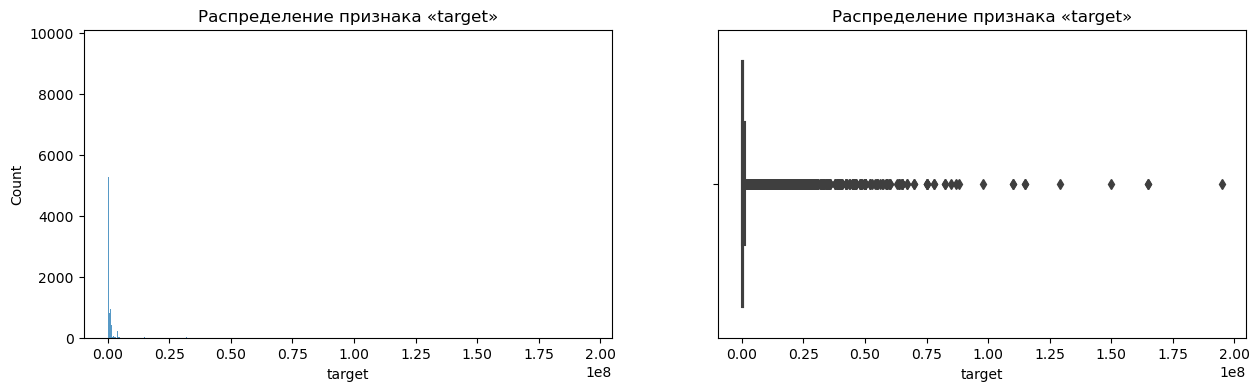

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_v14, x='target', ax=axes[0]);
histplot.set_title('Распределение признака «target»');
# histplot.axvline(df_v14['target'].mean(), color='red', lw=2)

boxplot = sns.boxplot(data=df_v14, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака «target»');

Посмотрим на распределение нашего целевого признака в логарифмическом масштабе

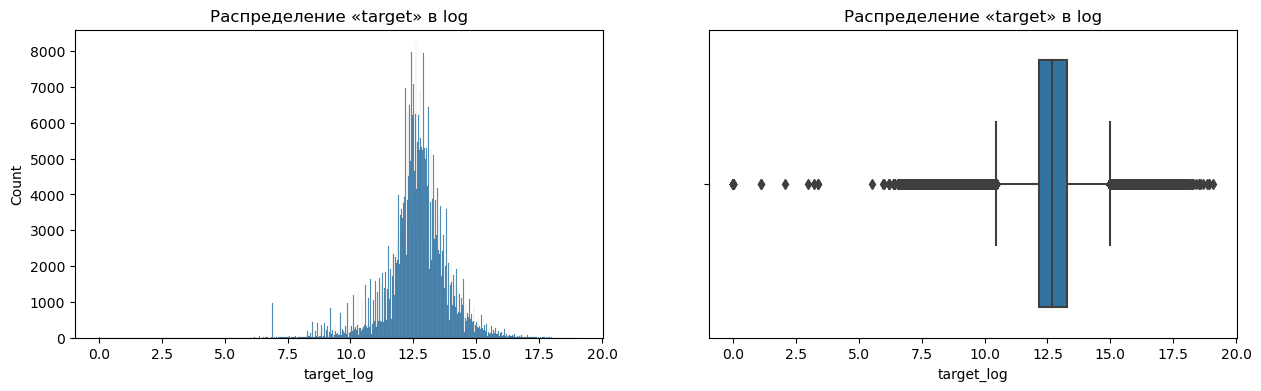

In [7]:
df_v14['target_log'] = np.log(df_v14['target']) # смысла прибавлять +1 нету, т.к. нулевых значений нет

# посмотрю на графики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_v14, x='target_log', ax=axes[0]);
histplot.set_title('Распределение «target» в log');
boxplot = sns.boxplot(data=df_v14, x='target_log', ax=axes[1]);
boxplot.set_title('Распределение «target» в log');

Проведем проверку на нормальность при помощи графиков квантилей QQ из библиотеки scipy

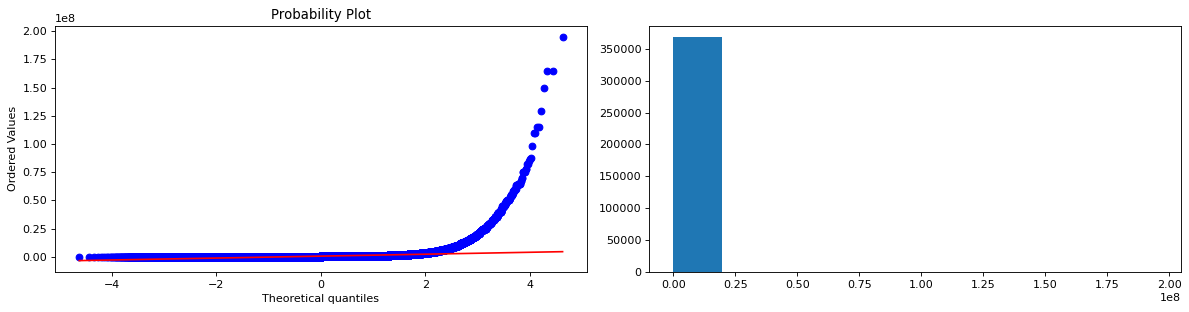

In [8]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df_v14['target'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
plt.hist(df_v14['target']) # гистограмма распределения признака

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout
plt.show()

Также, мы можем использовать функцию qqplot() из библиотеки statsmodels. Правда тут я не смог найти как управлять размерами графика. Поэтому scipy мне больше понравился.

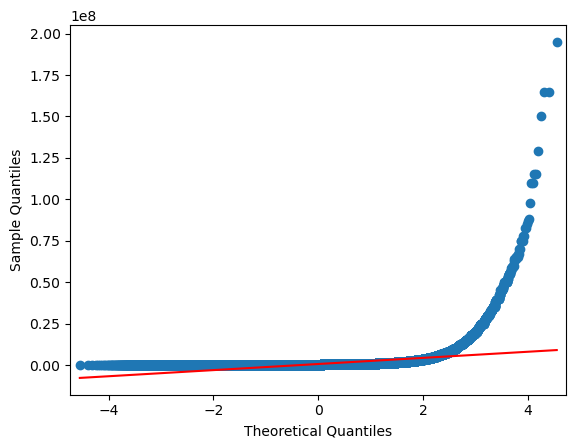

In [9]:
fig = sm.qqplot(df_v14['target'], line='s')
plt.show()

видим, что этот набор данных не соответствует нормальному распределению в районе правого хвоста.  
То есть по графическим тестам мы можем сказать, что данные не имеют нормальной тенденции.

Хотя график QQ не является формальным статистическим тестом, он предлагает простой способ визуально проверить, нормально ли распределен набор данных.

Проверка на нормальность с помощью тестов

Существует целый ряд статистических тестов, специально разработанных для проверки нормальности распределения данных. В общем виде проверяемую при помощи этих тестов нулевую гипотезу можно сформулировать так: «Анализируемая выборка происходит из генеральной совокупности, имеющей нормальное распределение». Если получаемая при помощи того или иного теста вероятность ошибки Р оказывается меньше некоторого заранее принятого уровня значимости (например, 0.05), нулевая гипотеза отклоняется.

Тест Шапиро-Уилка является тестом на нормальность. Он используется для определения того, соответствует ли выборка нормальному распределению .

Этот тип теста полезен для определения того, исходит ли данный набор данных из нормального распределения, что является распространенным предположением, используемым во многих статистических тестах, включая регрессию , дисперсионный анализ , t-тесты и многие другие.

Чтобы выполнить тест Шапиро-Уилка, мы можем использовать функцию scipy.stats.shapiro()

Эта функция возвращает тестовую статистику и соответствующее p-значение.

Если p-значение ниже определенного уровня значимости, то у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

In [8]:
stats.shapiro(df_v14['target'])

/home/patriot/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.2141023874282837, pvalue=0.0)

Из вывода мы видим, что статистика теста равна 0.21389 , а соответствующее значение pvalue=0.0 .

Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

Но мы видим предупреждение, что размер выборки должен до 5000, чтобы функция shapiro.test() работала корректно.

Тест Колмогорова-Смирнова используется для проверки того, происходит ли выборка из определенного распределения.

Выполним тест Колмогорова-Смирнова для наших данных, чтобы определить, являются ли они результатом нормального распределения:

In [9]:
stats.kstest(df_v14['target'], 'norm')

KstestResult(statistic=0.9999538986801456, pvalue=0.0)

Видим, что статистика теста равна 0.99995 , а соответствующее значение pvalue=0.0. Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

Проверим является ли распределение признака в логарифмическом масштабе нормальным?

Проверьте свою гипотезу с помощью теста Д’Агостино-Пирсона (scipy.stats.normaltest) при уровне значимости $\alpha=0.05$.

In [11]:
_, p = stats.normaltest(df_v14.target_log)
#normaltest возвращает двустороннюю вероятность для проверки гипотезы поэтому уровень значимости делим на 2
print('p=%.2f' % p)

if p > 0.05/2:
    print('Тест на нормальность данных пройден успешно!')
else:
    print('Тест на нормальность данных НЕ пройден!')

p=0.00
Тест на нормальность данных НЕ пройден!


Наш очищенный и подготовленный набор данных еще раз прогоним через ProfileReport

In [362]:
# проведу еще раз анализ на финальном датасете
profile = ydata_profiling.ProfileReport(df_v14, title="Profiling Report after EDA")
profile.to_file("data/df_v14_report.html")

/home/patriot/.local/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/patriot/.local/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
df_v14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368753 entries, 0 to 368752
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        368753 non-null  object 
 1   propertyType  368753 non-null  object 
 2   baths         368753 non-null  object 
 3   city          368753 non-null  object 
 4   sqft          368753 non-null  int64  
 5   zipcode       368753 non-null  object 
 6   state         368753 non-null  object 
 7   target        368753 non-null  int64  
 8   Pool          368753 non-null  bool   
 9   Year built    368753 non-null  object 
 10  r_sch_mean    368753 non-null  float64
 11  dist_sch_min  368753 non-null  float64
 12  target_log    368753 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 34.1+ MB


Из отчета наблюдаем, что существует сильная корреляция между признаками state и zipcode, что вполне логично. Также считаю, что признак city имеет слишком много уникальных значений и по логике он также должен коррелировать с zipcode.  
Поэтому принимаю решение оставить только zipcode, а state и city - удалить

Перед удалением посмотрю, ради интереса, рапределение количества лотов по штатам.

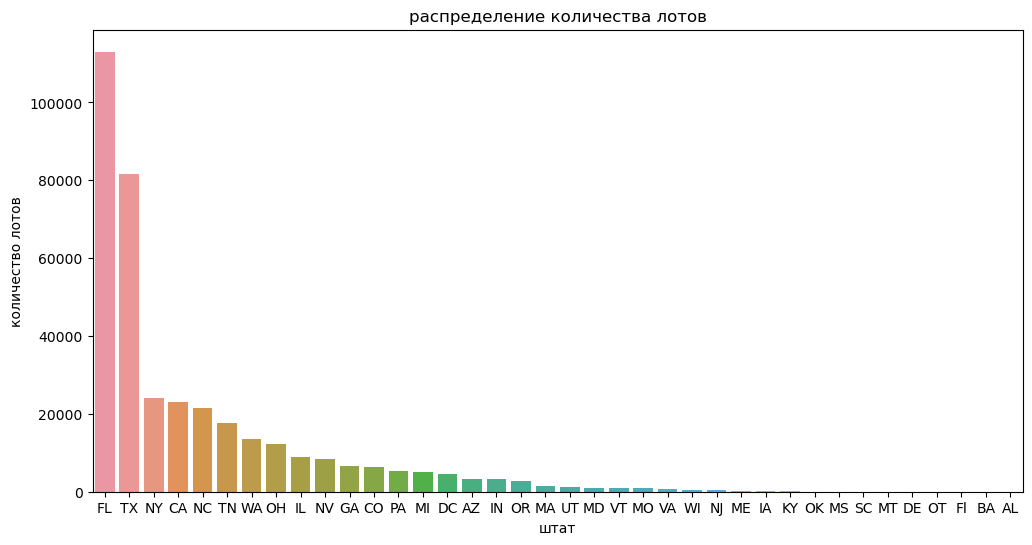

In [11]:
# Переведем признак state в категориальный тип
df_v14.state = df_v14.state.astype("category")
order=df_v14.value_counts('state')

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
bar = sns.barplot(data=df_v14, x="state", y='target', estimator=len, order=order.index)
bar.set_title("распределение количества лотов")
bar.set_xlabel("штат")
bar.set_ylabel("количество лотов")
plt.show()

In [12]:
df_v15 = df_v14.drop(['state'], axis=1)

In [13]:
# на всякий случай проверю не появились ли дубли
df_v15.duplicated().sum() 

0

In [16]:
df_v15

,status,propertyType,baths,city,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,single family,3.5,Southern Pines,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,single family,3,Spokane Valley,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,single family,2,Los Angeles,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,single family,8,Dallas,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,Palm Bay,-1,32908,5000,False,None,4.7,3.03,8.517193
...,...,...,...,...,...,...,...,...,...,...,...,...
368748,undefined,single family,6.0,Miami,4017,33180,1249000,True,1990,5.0,1.10,14.037854
368749,forsale,condo,3,Chicago,2000,60657,674999,False,1924,4.3,0.40,13.422466
368750,forsale,single family,3,Jamaica,1152,11434,528000,False,1950,4.5,0.48,13.176852
368751,undefined,unknown,unknown,Houston,-1,77028,34500,False,None,-1.0,0.50,10.448715


In [376]:
test15 = df_v15[df_v15.drop(['city'], axis=1).duplicated(keep=False)]

In [385]:
df_v14.loc[test15.index].sort_values('zipcode')

,status,propertyType,baths,city,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
253944,forsale,multi family,3,Astoria,1232,11102,NY,1268000,False,1920,4.3,0.24
47051,forsale,multi family,3,Queens,1232,11102,NY,1268000,False,1920,4.3,0.24
55583,forsale,multi family,4,Long Island City,4050,11105,NY,1725000,False,1955,4.0,0.19
149589,forsale,multi family,4,Astoria,4050,11105,NY,1725000,False,1955,4.0,0.19
269620,forsale,single family,2,Bayside,1328,11361,NY,759000,False,1930,7.7,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
359158,forsale,lot/land,unknown,Salt Lake City,-1,84121,UT,289900,False,None,4.7,0.30
240535,forsale,single family,3,Salt Lake City,3906,84121,UT,689900,False,2019,4.7,0.18
103918,forsale,lot/land,unknown,Salt Lake City,-1,84121,UT,375000,False,None,-1.0,-1.00
159865,forsale,condo,unknown,Venice,811,90292,CA,695000,True,2003,6.0,0.59


In [398]:
df_v12.loc[df_v12.city=='Venice'][50:]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,target,Pool,Year built
156388,forsale,single family,1647 Crescent Pl,3,Venice,"[{'rating': ['8/10', '4/10', '7/10'], 'data': ...","2,900 sqft",90291,3 Beds,CA,2.0,"$5,650,000",True,1921
158899,forsale,single family,1601 Oakwood Ave,2,Venice,"[{'rating': ['8/10', '4/10', '7/10'], 'data': ...","1,782 sqft",90291,4 Beds,CA,NaN,"$1,975,000",True,1968
159987,forsale,single family,2318 Clement Ave,3,Venice,"[{'rating': ['9/10', '4/10', '7/10'], 'data': ...","3,100 sqft",90291,4 Beds,CA,NaN,"$3,685,000",False,1922
162310,forsale,condo,13700 Marina Pointe Dr #1126,unknown,Venice,"[{'rating': ['9/10', '2/10', '7/10'], 'data': ...",811 sqft,90292,NaN,CA,9.0,"$695,000",True,2003
168627,forsale,single family,2335 Louella Ave,3,Venice,"[{'rating': ['5/10', '4/10', '7/10'], 'data': ...","1,830 sqft",90291,3 Beds,CA,1.0,"$2,098,000",False,1955
172078,forsale,single family,2218 Grand Canal,5,Venice,"[{'rating': ['9/10', '4/10', '7/10'], 'data': ...","3,488 sqft",90291,3 Beds,CA,NaN,"$4,985,000",False,1939
173542,forsale,condo,13700 Marina Pointe Dr #1819,3,Venice,"[{'rating': ['9/10', '2/10', '7/10'], 'data': ...","1,333 sqft",90292,2 Beds,CA,9.0,"$1,388,000",True,2003
181945,forsale,single family,2020 Alberta Ave,4,Venice,"[{'rating': ['4/10', '4/10', '7/10'], 'data': ...","2,735 sqft",90291,3 Beds,CA,4.0,"$2,495,000",False,2017
182557,forsale,single family,2319 Penmar Ave,6,Venice,"[{'rating': ['5/10', '4/10', '7/10'], 'data': ...","4,511 sqft",90291,4 Beds,CA,NaN,"$4,200,000",True,1924
196053,forsale,apartment,538 Brooks Ave,8,Venice,"[{'rating': ['8/10', '4/10', '7/10'], 'data': ...","3,824 sqft",90291,9 Beds,CA,2.0,"$4,925,000",False,1961


Вобщем признак города придется тоже удалять. Из-за ошибочных написаний вместо города названия района или названия локации появились дубли.

In [14]:
df_v15 = df_v15.drop(['city'], axis=1)

In [15]:
# видим, что появились дубли
df_v15.duplicated().sum() 

76

In [16]:
# Удалим дубли
df_v15 = df_v15.drop_duplicates(ignore_index=True)

In [20]:
df_v15

,status,propertyType,baths,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,single family,3.5,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,single family,3,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,single family,2,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,single family,8,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,-1,32908,5000,False,None,4.7,3.03,8.517193
...,...,...,...,...,...,...,...,...,...,...,...
368672,undefined,single family,6.0,4017,33180,1249000,True,1990,5.0,1.10,14.037854
368673,forsale,condo,3,2000,60657,674999,False,1924,4.3,0.40,13.422466
368674,forsale,single family,3,1152,11434,528000,False,1950,4.5,0.48,13.176852
368675,undefined,unknown,unknown,-1,77028,34500,False,None,-1.0,0.50,10.448715


In [17]:
df_v15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368677 entries, 0 to 368676
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        368677 non-null  object 
 1   propertyType  368677 non-null  object 
 2   baths         368677 non-null  object 
 3   sqft          368677 non-null  int64  
 4   zipcode       368677 non-null  object 
 5   target        368677 non-null  int64  
 6   Pool          368677 non-null  bool   
 7   Year built    368677 non-null  object 
 8   r_sch_mean    368677 non-null  float64
 9   dist_sch_min  368677 non-null  float64
 10  target_log    368677 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 28.5+ MB


## 2. Отбор и преобразование признаков

In [18]:
df_v16 = df_v15.copy()

In [19]:
# сохраним
df_v16.to_pickle("data/df_v16.pkl")

In [2]:
# считаем
df_v16 = pd.read_pickle("data/df_v16.pkl")  

Закодируем категориальные признаки в наших данных

In [3]:
cols_to_code = ['status','propertyType','Year built','zipcode','baths']

In [24]:
df_ohe = pd.get_dummies(df_v16)

In [25]:
# сохраним
df_ohe.to_pickle("data/df_ohe.pkl")

In [4]:
# считаем
df_ohe = pd.read_pickle("data/df_ohe.pkl")  

Данный енкодер нам не подходит, так как у нас очень много признаков получается и модель на последующих шагах будет крашится из-за недостатка ОЗУ (а у меня ОЗУ 32ГБ). Да и файл df_ohe.pkl стал весить 1.8ГБ.

Поэтому применим BinaryEncoder

In [4]:
enc = ce.BinaryEncoder(cols=cols_to_code)

In [5]:
df_be = enc.fit_transform(df_v16.drop(['target', 'target_log'], axis=1))

In [6]:
df_be

,status_0,status_1,status_2,status_3,status_4,status_5,status_6,propertyType_0,propertyType_1,propertyType_2,...,Year built_0,Year built_1,Year built_2,Year built_3,Year built_4,Year built_5,Year built_6,Year built_7,r_sch_mean,dist_sch_min
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,5.2,2.70
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,4.0,1.01
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,6.7,1.19
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,9.0,0.10
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368672,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,5.0,1.10
368673,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,4.3,0.40
368674,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,1,1,1,4.5,0.48
368675,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,-1.0,0.50


In [31]:
# сохраним
df_be.to_pickle("data/df_be.pkl")

Ну вот! другое дело! Файл всего 140Мб

In [ ]:
# считаем


Еще одним методом кодирования так называемых high-dimensional data является метод feature hashing. В библиотеке scikit-learn это класс sklearn.feature_extraction.FeatureHasher. У данного метода есть небольшое ухудшение accuracy из-за возможных коллизий, это происходит, когда два значения элемента в конечном итоге хэшируются по одному и тому же индексу в векторе. Но из плюсов данного метода - это скорость и небольшое потребление вычислительных ресурсов.  
Еще один метод кодирования подобных данных является Bayesian Target Encoding. У него тоже помимо определенных плюсов есть и минус - склонность к переобучению. Данный метод реализован в библиотеке bayte.  
Так что при желании можно попробовать эти методы и в итоге сравнить, как это повлияет на конечный score нашей модели. Но оставлю эту идею, для факультативного решения :=)

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. 

In [7]:
X = df_be
y = df_v16['target']
y_log = df_v16['target_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. Так как его распределение  ближе к нормальному. Не знаю имеет ли логику это мое предположение..?

Разобьём выборку на обучающую и валидационную в соотношении 70/30:

In [8]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [9]:
X_train.shape

(258073, 47)

*При первом варианте кодирования, когда я использовал One-Hot Encoder, можно было отобрать с помощью SelectKBest важные признаки. Но по моему мнению после BinaryEncoder уже нельзя отбирать таким способом признаки, по причине логики самого енкодера. Верно ли мое мнение, нужно уточнить у менторов.*

На данный момент у нас слишком много признаков — скорее всего, не все из них будут важны. Оставлю лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберу 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализую по обучающей выборке, используя параметр score_func = f_regression.

In [36]:
from sklearn.feature_selection import f_regression

select = feature_selection.SelectKBest(score_func = f_regression, k=25)
z = select.fit_transform(X_train,y_train_log)

In [38]:
filter_kb = select.get_support()

features = X_train.columns
print(features[filter_kb])

Index(['status_2', 'status_5', 'propertyType_1', 'propertyType_2',
       'propertyType_5', 'propertyType_7', 'baths_0', 'baths_1', 'baths_2',
       'baths_3', 'baths_4', 'baths_5', 'baths_6', 'sqft', 'zipcode_8',
       'zipcode_12', 'Pool', 'Year built_2', 'Year built_3', 'Year built_4',
       'Year built_5', 'Year built_6', 'Year built_7', 'r_sch_mean',
       'dist_sch_min'],
      dtype='object')


Хотя код SelectKBest конечно же ошибку не даст и проведет отбор, но еще раз повторюсь, считаю это не верным решением и применять его не буду в дальнейшем.

Немасштабированные данные будут вредными при вычислении оптимальных весов. Поэтому при работе с линейной моделью и числовыми данными, как правило, рекомендуется масштабировать данные. Применим StandardScaler к нашим данным.

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Решение задачи регрессии:

Измерять качество наших моделей будем по метрике RMSLE (Root Mean Squared Log Error)

$RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (log (y_i) - log (\hat{y}_i))^2}$

Для начала воспользуемся самой простой моделью регрессии, которая нам известна — классическая линейная регрессия по методу OLS (ordinary least squares).

In [59]:
reg = linear_model.LinearRegression()
reg.fit(X_train_scaled, y_train_log)
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

In [60]:
# исходя из формулы RMSLE нужно взять корень от MSE
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred))))

Train RMSLE score: 1.04
Test RMSLE score: 1.04


Попробую уменьшить ошибку прогноза, воспользовавшись полиномиальной регрессией

Сгенерирую полиномиальные признаки второй степени с помощью PolynomialFeatures

In [61]:
poly = preprocessing.PolynomialFeatures(include_bias=False) # degree=2 по-умолчанию
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для валидационной выборки
X_test_poly = poly.transform(X_test_scaled)

Построю модель полиномиальной регрессии второй степени на обучающей выборке

In [62]:
#Создаём объект класса LinearRegression
reg_poly = linear_model.LinearRegression()
#Обучаем модель 
reg_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = reg_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
y_test_predict_poly = reg_poly.predict(X_test_poly)

In [63]:
# метрики для полиноминальной регрессии
print('Polynomial Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Polynomial Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly))))

Polynomial Train RMSLE score: 0.89
Polynomial Test RMSLE score: 629573876.43


Метрика уменьшились для тренировочной выборки, но сильно увеличилась для тестовой. Поэтому построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией 

In [70]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.2) # alpha=1 по-умолчанию
#Обучаем модель
ridge_lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly_r = ridge_lr.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly_r = ridge_lr.predict(X_test_poly)

In [71]:
# метрики для полиноминальной регрессии
print('Polynomial-L2 Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly_r))))
print('Polynomial-L2 Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly_r))))

Polynomial-L2 Train RMSLE score: 0.89
Polynomial-L2 Test RMSLE score: 0.91


Теперь попробую модель дерева решений

In [73]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)

y_train_predict_dtr = dtr.predict(X_train_scaled)
y_test_predict_dtr = dtr.predict(X_test_scaled)

In [74]:
# метрики для DecisionTreeRegressor
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_dtr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_dtr))))

DecisionTreeRegressor Train RMSLE score: 0.16
DecisionTreeRegressor Test RMSLE score: 0.93


Явно видем признак переобучения модели!

Поиграемся с глубиной дерева решений в диапазоне от 7 до 20:

In [75]:
# Задам словарь гиперпараметров для GridSearchCV
param_grid_DTR = {
              'max_depth': list(np.arange(6,21)) # максимальная глубина дерева
              }

In [100]:
#Создаем объект класса            
grid_search_DTR = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(), 
    param_grid=param_grid_DTR,
    n_jobs = -1,
    scoring='neg_mean_squared_error')

In [101]:
# Запускаем подбор гиперпараметров
grid_search_DTR.fit(X_train_scaled, y_train_log) 

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [102]:
# посмотрим наилучшую найденную комбинацию гиперпараметров
grid_search_DTR.best_params_

{'max_depth': 12}

In [103]:
grid_search_DTR.best_score_

-0.6586554006403391

In [104]:
# раз мы явно указали метрику -MSLE, то теперь можно посмотреть ее через данный метод
_MSLE = grid_search_DTR.score(X_test_scaled, y_test_log)
_MSLE

-0.6465888920100568

In [105]:
# ну и наша метрика
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(-_MSLE)))

DecisionTreeRegressor Test RMSLE score: 0.80


Посмотрим на графики, как менялись метрики в зависимости от глубины дерева

In [90]:
RMSLE_tr=[]
RMSLE_test=[]
for n in np.arange(6,21):
    dtr2 = tree.DecisionTreeRegressor(max_depth=n)
    dtr2.fit(X_train_scaled, y_train_log)
    y_train_predict_dtr2 = dtr2.predict(X_train_scaled)
    y_test_predict_dtr2 = dtr2.predict(X_test_scaled)
    mse_gs_train = metrics.mean_squared_error(y_train_predict_dtr2, y_train_log)
    mse_gs_test = metrics.mean_squared_error(y_test_predict_dtr2, y_test_log)
    RMSLE_tr.append(round(mse_gs_train**0.5, 2))
    RMSLE_test.append(mse_gs_test**0.5) #округление лучше не использовать, график тогда ломаный получается

In [93]:
# создадим фрейм
rmsle = pd.DataFrame({"depth":np.arange(6,21),"train":RMSLE_tr,"test":RMSLE_test})

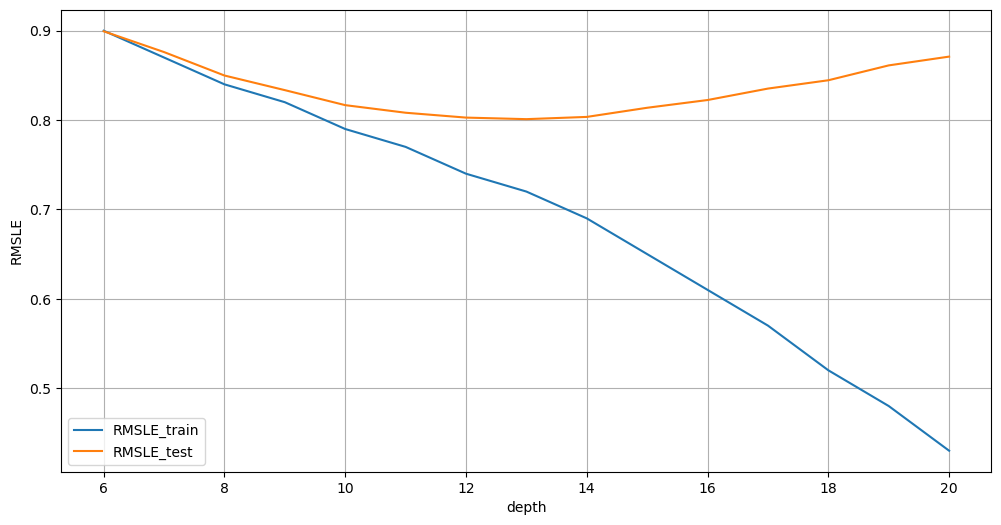

In [94]:
fig, axs = plt.subplots()
line = sns.lineplot(data=rmsle,x="depth",y="train",label="RMSLE_train")
line2 = sns.lineplot(data=rmsle,x="depth",y="test",label="RMSLE_test")
line.set_ylabel("RMSLE")
axs.grid()

## 4. Решение задачи регрессии: ансамблевые методы

Построим модель случайного леса с найденной нами ранее наилучшим параметром глубины. Парметр criterion = 'squared_error' установлен в модели по-умолчанию

In [69]:
rfr = ensemble.RandomForestRegressor(max_depth=12,
                                  n_estimators=200,
                                  min_samples_split = 20,
                                  random_state=42,
                                    n_jobs = -1)

rfr.fit(X_train_scaled, y_train_log)

y_train_predict_rfr = rfr.predict(X_train_scaled)
y_test_predict_rfr = rfr.predict(X_test_scaled)

# метрики 
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_rfr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_rfr))))

DecisionTreeRegressor Train RMSLE score: 0.73
DecisionTreeRegressor Test RMSLE score: 0.76


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Посмотрим, что будет при последовательном ансамблировании ↓

Построю модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) 

In [11]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики 
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

DecisionTreeRegressor Train RMSLE score: 0.66
DecisionTreeRegressor Test RMSLE score: 0.69


Наблюдаем существенное улучшение метрик!

Посмотрим на важность факторов для наилучшей ансамблевой модели.

<AxesSubplot: >

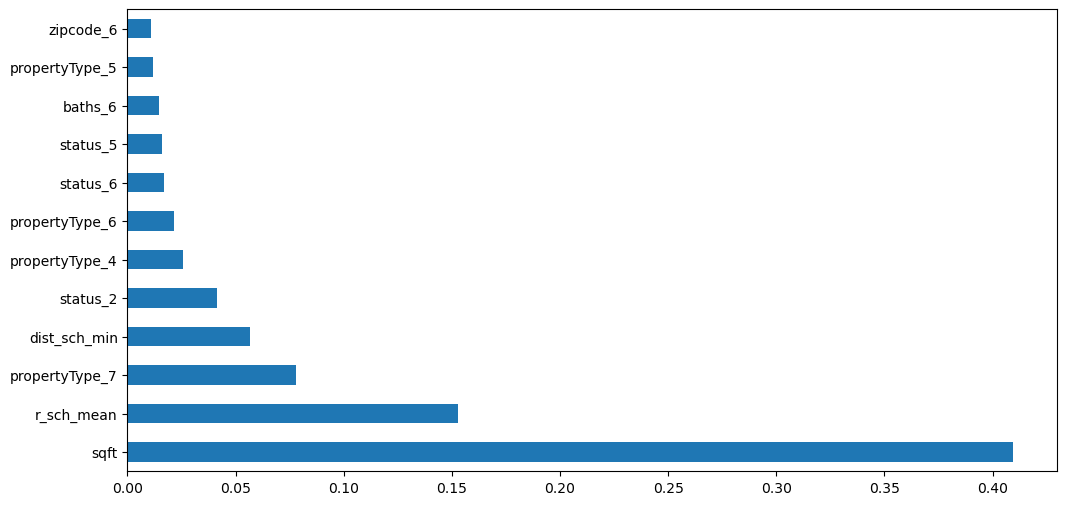

In [108]:
# есть возможность вывести самые важные признаки для модели через атрибут feature_importances_
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

Поскольку категориальные признаки кодировал бинарным кодированием, то не представляется возможным оценить важность этих признаков. Но а вот иерархию важности числовых признаков мы можем наблюдать. Видим, что больше всего на цену влияет параметр полезной площади, что собственно логично. Далее по важности идут параметры: средний рейтинг ближайших школ и расстояние до ближайшей школы.

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Поэтому для лучшей из построенных моделей рассчитаю медианную абсолютную ошибку (MeAE, в sklearn — функция median_absolute_error) 

In [110]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

mae_test = metrics.median_absolute_error(y_test, y65_test_predict)
mae_test

92869.26593938365

Ну вывод какой-то не утешительный-)))) Ошибка модели в 92 т.$ - так себе результат

Могу объяснить это только тем, что в наших входных данных целевой признак имеет диапазон от 1$ до более чем 2 млн.

## 5. построение прогноза

Перед созданием прогноза для новых объектов необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой. Но! Считаю это не совсем логичным. Поскольку при анализе начальных данных многие признаки были признаны не пригодными для будущей модели и отброшены, то логичнее построить сервис предсказания, запрашивая только те признаки, которые явно участвуют в модели предсказания. То есть запрос входных данных для новых объектов перед подачей на вход модели должен иметь формат нашего очищенного фрейма df_v16.

In [6]:
df_v16.head()

,status,propertyType,baths,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,single family,3.5,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,single family,3,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,single family,2,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,single family,8,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,-1,32908,5000,False,None,4.7,3.03,8.517193


In [5]:
df_v16.columns

Index(['status', 'propertyType', 'baths', 'sqft', 'zipcode', 'target', 'Pool',
       'Year built', 'r_sch_mean', 'dist_sch_min', 'target_log'],
      dtype='object')

In [77]:
# Структура должна быть такая
df_v16.drop(['target','target_log'],axis=1).loc[1].values

array(['forsale', 'single family', '3', 1947, '99216', False, '2019', 4.0,
       1.01], dtype=object)

In [12]:
cols = df_v16.drop(['target','target_log'],axis=1).columns

In [47]:
# Создадим первый запрос
request = [['active', 'single family', '3.5', 2900, '28387', True, '2019', 5.2, 2.7]]

Далее проводим последовательно те-же самые манипуляции, что и над тестовой выборкой:
 - BinaryEncoder,
 - StandardScaler,
 - непосредственно само предсказание с помощью GradientBoostingRegressor

In [48]:
req = pd.DataFrame(request, columns=cols)

In [49]:
req

,status,propertyType,baths,sqft,zipcode,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,3.5,2900,28387,True,2019,5.2,2.7


In [62]:
# Первый шаг - BinaryEncoder
req_be = enc.transform(req)

In [63]:
req_be

,status_0,status_1,status_2,status_3,status_4,status_5,status_6,propertyType_0,propertyType_1,propertyType_2,...,Year built_0,Year built_1,Year built_2,Year built_3,Year built_4,Year built_5,Year built_6,Year built_7,r_sch_mean,dist_sch_min
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,5.2,2.7


In [67]:
# Второй шаг - StandardScaler
req_ss = scaler.transform(req_be)

In [68]:
req_ss

array([[-0.01349638, -0.04113762, -0.15887867, -0.15900681, -0.23394976,
        -1.42117549,  1.20161271, -0.0165889 , -0.06748517, -0.14325964,
        -0.2632709 , -0.58385166, -0.49217336, -0.6289556 ,  0.38767074,
        -0.02619777, -0.13741722, -0.35145695, -0.46904309, -0.92598167,
        -1.06968652,  0.63795802,  0.01639186, -0.02887546, -0.3681234 ,
        -0.65866113, -0.82613311, -0.8827927 , -0.93628801, -0.96725455,
        -0.97948372, -1.01848739, -0.97600399, -0.98567642, -1.03598995,
         0.95418932,  2.86295811, -0.09739455, -0.55083458, -0.76727985,
        -0.66875279, -0.76902073, -1.04177904, -0.81941174,  1.01228518,
         0.18438112,  0.25026036]])

In [72]:
# Третий шаг - предсказание
req_predict_log = rfr.predict(req_ss)

In [73]:
req_predict_log

array([12.93702653])

In [74]:
# перевод из логарифмической шкалы в изначальную
req_predict = np.exp(req_predict_log)

In [75]:
req_predict

array([415412.18974643])

Можно все это обернуть в функцию для удобства

In [30]:
def final_predict(rec_list):
    req_f = pd.DataFrame([rec_list], columns=cols)
    req_be_f = enc.transform(req_f)
    req_ss_f = scaler.transform(req_be_f)
    req_predict_log_f = rfr.predict(req_ss_f)
    return round(np.exp(req_predict_log_f[0]))

Попробую второй запрос прогнать через данную функцию

In [82]:
request2 = ['forsale', 'single family', '3', 1947, '99216', True, '2019', 4.0, 1.01]

In [83]:
final_predict(request2)

364651

In [84]:
request3 = ['foreclosure', 'condo','3', 1780, '46250', False, '1989',  3.7, 1.71]
final_predict(request3)

240733

## 6. Подготовка модели к продакшену

Теперь, когда модель отработана и проверена, можно готовить ее к запуску в production

Поразмыслив, я пришел в выводу, что на этом этапе деление наших подготовленных данный на выборки train и test уже не имеет смысла, раз модель уже отточена. И поэтому подготовку пайплайна можно делать на полном наборе данных.  
**Вопрос к проверяющим менторам** - верен ли этот мой вывод?

Наши подготовленные данные находятся в переменной df_v16

In [17]:
df_v16

,status,propertyType,baths,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,single family,3.5,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,single family,3,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,single family,2,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,single family,8,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,-1,32908,5000,False,None,4.7,3.03,8.517193
...,...,...,...,...,...,...,...,...,...,...,...
368672,undefined,single family,6.0,4017,33180,1249000,True,1990,5.0,1.10,14.037854
368673,forsale,condo,3,2000,60657,674999,False,1924,4.3,0.40,13.422466
368674,forsale,single family,3,1152,11434,528000,False,1950,4.5,0.48,13.176852
368675,undefined,unknown,unknown,-1,77028,34500,False,None,-1.0,0.50,10.448715


In [23]:
# Создаём пайплайн, который включает все наши шаги по подготовке данных и обучению модели
pipe = Pipeline([  
  ('BinaryEncoder', enc),
  ('StandardScaler', scaler),
  ('GradientBoostingRegressor', gbr)
  ])

In [24]:
# Входными данными для пайплайна будут
X_p = df_v16.drop(['target', 'target_log'], axis=1)
y_p = df_v16['target_log']

In [25]:
# Обучаем пайплайн
pipe.fit(X_p, y_p)

Pipeline(steps=[('BinaryEncoder',
                 BinaryEncoder(cols=['status', 'propertyType', 'Year built',
                                     'zipcode', 'baths'],
                               mapping=[{'col': 'status',
                                         'mapping':      status_0  status_1  status_2  status_3  status_4  status_5  status_6
 1          0         0         0         0         0         0         1
 2          0         0         0         0         0         1         0
 3          0         0         0         0         0         1         1
 4          0         0         0         0         1         0         0
 5          0         0         0         0         1         0         1
..        ...       ...       ...       ...       ...       ...       ...
 92         1         0         1         1         1         0         0
 93         1         0         1         1         1         0         1
 94         1         0         1         1         1         1         0
-1          0         0         0         0         0         0         0
-2          0         0         0         0         0         0         0

[96 rows x 7 columns]},
                                        {'col': 'propertyType',
                                         'm...
                                         'mapping':       baths_0  baths_1  baths_2  baths_3  baths_4  baths_5  baths_6
 1          0        0        0        0        0        0        1
 2          0        0        0        0        0        1        0
 3          0        0        0        0        0        1        1
 4          0        0        0        0        1        0        0
 5          0        0        0        0        1        0        1
...       ...      ...      ...      ...      ...      ...      ...
 112        1        1        1        0        0        0        0
 113        1        1        1        0        0        0        1
 114        1        1        1        0        0        1        0
-1          0        0        0        0        0        0        0
-2          0        0        0        0        0        0        0

[116 rows x 7 columns]}])),
                ('StandardScaler', StandardScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

Сериализуем нашу обученную модель.

In [28]:
# Сериализуем и записываем результат в файл
with open('diplom_pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

Проверю работоспособность

In [29]:
# Десериализуем pipeline из файла
with open('diplom_pipeline.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [37]:
# сделаю предсказание
request3 = ['foreclosure', 'condo','3', 1780, '46250', False, '1989',  3.7, 1.71]
req_f = pd.DataFrame([request3], columns=cols)
log_pred = loaded_pipe.predict(req_f)

In [38]:
# Переведем из логарифмического предсказания в обычные доллары
round(np.exp(log_pred[0]))

34938

Сразу есть мысли для дальнейшего улучшения логики работы сервиса. Если например пользователь не знает некоторые признаки. Можно в финальный пайплайн добавить кастомный трансформер, в который занести список наиболее часто используемых значений по каждому признаку, и тогда, когда пользователь передаст на вход модели список с некоторыми пустыми значениями, то можно проанализировать наличие таких пустых значений и произвести подстановку из этого заранее подготовленного списка. Реализовывать сейчас это не стану, но логику пропишу для понимания. Выглядеть будет примерно так.

In [14]:
class MyTransformer(TransformerMixin, BaseEstimator):
    '''Шаблон кастомного трансформера'''

    def __init__(self):
        '''Здесь прописывается инициализация параметров, не зависящих от данных.'''
        pass


    def fit(self, X, y=None):
        '''
        Здесь прописывается «обучение» трансформера.
        Вычисляются необходимые для работы трансформера параметры (если они нужны).
        '''
        return self


    def transform(self, rec_list):
        '''Здесь прописываются действия с данными.'''
        # тут будет код по заполнению пропущенных значений по каждому признаку - значениями из заданного словаря.
        return req_f

Тогда итоговый пайплайн будет выглядеть так

In [ ]:
pipe2 = Pipeline([  
  ('FeatureEngineering', MyTransformer()),
  ('BinaryEncoder', enc),
  ('StandardScaler', scaler),
  ('GradientBoostingRegressor', gbr)
  ])

### Воспроизводимость и контейнеризация

Выполним важное для вывода модели в production требование по изоляции зависимостей и создадим файл requirements.txt 

In [46]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Контейнеризация Docker

Базовый образ, который буду использовать для своего контейнера — tiangolo/uwsgi-nginx-flask.  
Образ этот создан на базе ОС Linux, и в нём уже настроено взаимодействие серверов uWSGI и NGINX через сокеты.

Вся необходимая структура и сам конфигурационный файл для создания Docker образа находится в директории diplom_web.

Образ создаем командой, находясь в терминале нашего проекта:

     docker build -t diplom . 

Теперь нужно запустить, созданный контейнер.  
Делается это с помощью команды docker run. Запустим контейнер на 80 порту:

    docker run -it --rm --name=diplom -p=80:80 diplom

Далее выполним POST-запрос.  
Запустим в соседнем терминале скрипт для отправки запросов на 'http://localhost/predict'. В скрипте прописаны параметры гипотетического нового объекта недвижимости.

    python3 test/client.py


Меняя в строке запроса в файле client.py параметры предполагаемого объекта мы будем получать новое предсказание.

Ответ на запрос будет выглядеть таким образом:
![prediction](img/Screenshot_1.png)

Подготовленный контейнер с обученной моделью размещен в моем репозитории https://hub.docker.com/r/patriot009/diplom

## Заключение

Таким образом на данном этапе мы имеем рабочий сервис с обученной моделью по поставленной нам задаче предсказания цены нового лота недвижимости.  
Далее, при необходимости можно будет обернуть данный сервис в дружелюбный для пользователя интерфейс.

На этом работу над проектом считаю законченной.